In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
#Import libraries
import numpy as np
from scipy import integrate
from scipy import interpolate
import scipy
import matplotlib.pyplot as plt 
import matplotlib.cm as cm # colormaps
import matplotlib.colors as colors
import astropy.io.fits as pyfits
from matplotlib.gridspec import GridSpec
import matplotlib as mpl

import pandas as pd
import math 
from astropy.table import Table
from astropy.io import ascii
from astropy.wcs import WCS


from astropy.convolution import Gaussian2DKernel
from scipy.signal import convolve as scipy_convolve
from astropy.convolution import convolve_fft
from scipy import ndimage, misc

from reproject import reproject_interp

In [3]:
##Calculate the opacity by interpolating from Ossenkopf (1994)
##thin ice mantles that have undergone coagulation for 10^5 years at a density of ∼ 10^6 cm−3
##Eqn 6##
#k0, k11, k13 are the mass absorption coeffs in cm2/g for gas densities at the initial distribution, 10^6, and 10^8 
#as described in table 1, for each wavelength you want to consider

def LOG_opacity(v, k0, k11, k13):
    nH = 10**6
    t_coag = 10**5
    
    a = (1./2) * (np.log10(k0)**2 - 4*(np.log10(k11)**2) + 3*(np.log10(k13)**2)) \
                  /(np.log10(k0) - 4*np.log10(k11) + 3*np.log10(k13))
                    
    b = (1./4) * ((np.log10(k13)-np.log10(k11))*(np.log10(k13)-np.log10(k0))*(np.log10(k11)-np.log10(k0)))\
                    /(np.log10(k0) - 4*np.log10(k11) + 3*np.log10(k13))
                      
    lgk = a - np.sqrt( (a-np.log10(k13))**2 + b*(np.log10(nH*t_coag)-13)**2  )
    
    return v, lgk
    

##Calculate lgk for wavelengths in the table around what you want to find. 
#Then use scipy.interpolate 

#Read in the txt files
v_um, k0 = np.loadtxt('ExtvsEm_ColDen/Ossenkopf1994_coag_initdist.txt').T
v_um, k11 = np.loadtxt('ExtvsEm_ColDen/Ossenkopf1994_coag_106cm-3.txt').T
v_um, k13 = np.loadtxt('ExtvsEm_ColDen/Ossenkopf1994_coag_108cm-3.txt').T

v_um, log_k = LOG_opacity(v_um, k0,k11,k13)


logk_interp = interpolate.interp1d(v_um, log_k)



In [4]:
#Col Den where 8um becomes optically thick
N_thick = 1./(11.7 *2.8 *1.67e-24)
print(N_thick)

1.827846139223385e+22


# Spitzer 8um calculations

In [5]:
#Feb 27th, 2023 Redid all the dumb geometry that was previous done Feb 27th, 2009...
#GAH! Law of cosines!

#Distribution of stars proportional to e^-(R/h_{R})
def disk_dist(d, n0, l):
    R_sun = 8.4 #kpc
    h_R = 3.5 #Galactic radial scale in kpc
    R = np.sqrt(d**2 + R_sun**2 -(2*d*R_sun*np.cos(np.deg2rad(l))))    

    return n0 * np.exp(-R/h_R)##Function to automate 8um fits##

#define extinction function
#f_fore is the fraction of LOS emission from foreground
#I_0_obs is intensity behind cloud
#I_1_obs is intensity in front of cloud
def Sigma_8um(f_fore, I_0_obs, I_1_obs):
    s = 0.3 #scattering correction
    k_v = 11.7 #cm^2/g #dust opacity for 8um
    return (-1./k_v) * np.log(  ((s+1)*I_1_obs - (s+1)*f_fore*I_0_obs) / ( (1-f_fore)*I_0_obs  ) ) #g/cm^2???


#If the front of cloud intensity is much larger than the assumed background, the log() will be positive
#And the sigma will come out negative

#Will return nans if doing log of negative number (i.e. if the background is MUCH higher than the front of
#the cloud)

In [6]:
#Convert to col den = (Sigma/mu*m_H)
def N(sig):
    mu = 2.8
    m_H = 1.67e-24 #g
    return sig/(mu*m_H)



def cloud_extinction_calc_8um(hers, f_fore, smoothed, obs):
    #Create list to populate 
    Sigma = np.zeros(shape=(len(hers),len(hers[0])))
    ext_N = np.zeros(shape=(len(hers),len(hers[0])))
    
    #For-loop for 2D array, first y then x
    for i in np.arange(len(hers)):

        for j in np.arange(len(hers[0])):
            if smoothed[i][j] == np.NaN:
                Sigma[i][j] = np.NaN
                ext_N[i][j] = np.NaN

            else:
                sig = Sigma_8um(f_fore, smoothed[i][j], obs[i][j])
                Sigma[i][j] = sig
                ext_N[i][j] = N(sig)
                
    #frac_nan_pix = len(np.where(ext_N==np.nan)[0])
                
    return ext_N





In [7]:
##Function to calculate and create plots##
ext_list = []
em_list = []
EXT_EM_RATIO_DATA = []
    
def cloud_EmvsExt(cloud, f_fore):


    #Herscehl 8um
    cloud_herschel_regrid_fits = pyfits.open('./Cloud_masks/{}/{}_herschel_cutout_isolated_regrid_to_spitzer.fits'.format(cloud, cloud))

    cloud_8um_fits = pyfits.open('./Cloud_masks/{}/{}_spitzer_cutout_isolated.fits'.format(cloud, cloud))
    cloud_8um_smoothed_fits = pyfits.open('./Cloud_masks/{}/{}_smoothed_cutout_isolated.fits'.format(cloud, cloud))

    # copy the FITS data into a numpy array
    cloud_8um = cloud_8um_fits[0].data
    cloud_8um_smoothed = cloud_8um_smoothed_fits[0].data
    cloud_hers_regrid = cloud_herschel_regrid_fits[0].data


    h_cloud_8um = pyfits.getheader('./Cloud_masks/{}/{}_herschel_cutout_isolated_regrid_to_spitzer.fits'.format(cloud, cloud))

    #Get the avg column density from herschel
    cloud_avg_hers= np.nanmean(cloud_hers_regrid) #finds average ignoring nans

    #Calculate a 2D array for the whole cloud#
    cloud_ext_N = cloud_extinction_calc_8um(cloud_hers_regrid, f_fore, cloud_8um_smoothed, cloud_8um)

  #  print("{} avg Hi-GAL col den = {} cm^-2".format(cloud, cloud_avg_hers))
  #  print(" ")
  #  print("{} avg 8um extinction col den = {} cm^-2".format(cloud, np.nanmean(cloud_ext_N) ))
    
    
    em_list.append(np.nanmedian(cloud_hers_regrid)/10**22)
    ext_list.append(np.nanmedian(cloud_ext_N)/10**22)

    pyfits.writeto('./Cloud_masks/{}/{}_8umExtN_ffore{:.2f}.fits'.format(cloud, cloud, f_fore), cloud_ext_N, h_cloud_8um, overwrite=True)

    
    ext_em_ratio = (cloud_hers_regrid/cloud_ext_N).flatten()
    
    xy = pd.DataFrame({'Herschel': cloud_hers_regrid.flatten(), 'Ext Col Den': cloud_ext_N.flatten()})
    corr_coeff = xy['Herschel'].corr(xy['Ext Col Den'], method='pearson')
    
    
    #find the fraction of pixels that are now nans
    num_ExtN_notnans = len(np.where(np.isnan(cloud_ext_N).flatten()==False)[0])
    num_smoothed_notnans = len(np.where(np.isnan(cloud_8um_smoothed).flatten()==False)[0])
    print(1- (num_ExtN_notnans/num_smoothed_notnans))

    
    #Make plot similar to Fig 3 in Battersby 2010

    fig = plt.figure(figsize = (10,10))
    ax1 = fig.add_subplot()
    plt.rcParams.update({'font.size': 17})

    x = np.arange(-1,30)
    y = np.arange(-1,30)

    ax1.scatter(cloud_hers_regrid/10**22,cloud_ext_N/10**22, marker='+', color = 'k', alpha=0.5, label = "f_fore={}".format(f_fore))
    plt.plot(x,y, c='black')
    plt.hlines(0,-1, 30, linestyle='--', color='gray')
    #plt.title(r"Herschel vs. $8\mu m$ Column Density for the Brick")
    #plt.ylim(-1,10)
    #plt.xlim(0,30)
    plt.xlabel(r"$N(H_{2})$ [$x10^{22} cm^{-2}$] from Hi-GAL")
    plt.ylabel(r"$N(H_{2})$ [$x10^{22} cm^{-2}$] from Spitzer 8 $\mu$m")
    #plt.legend(loc=2)
    plt.text(.02, .99, '{}  '.format(cloud), ha='left', va='top', transform=ax1.transAxes)
    plt.text(.02, .93, 'f_fore = {}'.format(f_fore), ha='left', va='top', transform=ax1.transAxes)
    plt.text(.02, .89, 'r = {:.3f}'.format(corr_coeff), ha='left', va='top', transform=ax1.transAxes)

    plt.savefig('./Cloud_masks/{}/{}_colden_vs_8um_colden.pdf'.format(cloud, cloud))

    plt.show()
    
    


    

    
    return EXT_EM_RATIO_DATA.append(ext_em_ratio)





/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_51654/3066601015.py:19: RuntimeWarning: invalid value encountered in log
  return (-1./k_v) * np.log(  ((s+1)*I_1_obs - (s+1)*f_fore*I_0_obs) / ( (1-f_fore)*I_0_obs  ) ) #g/cm^2???


0.5712438954323471


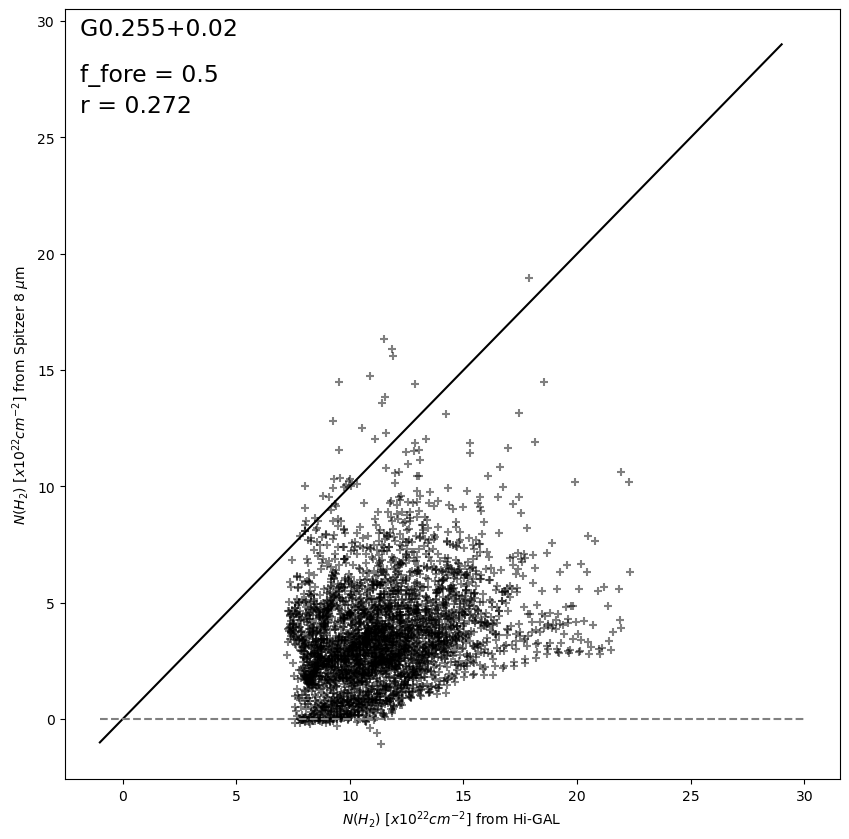

In [10]:
cloud_EmvsExt("G0.255+0.02", 0.5)

# Smooth 8um ExtN to Hi-GAL Col Den Resolution!

# Convolve Step

/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_24489/3066601015.py:19: RuntimeWarning: invalid value encountered in log
  return (-1./k_v) * np.log(  ((s+1)*I_1_obs - (s+1)*f_fore*I_0_obs) / ( (1-f_fore)*I_0_obs  ) ) #g/cm^2???


0.062022090059473234


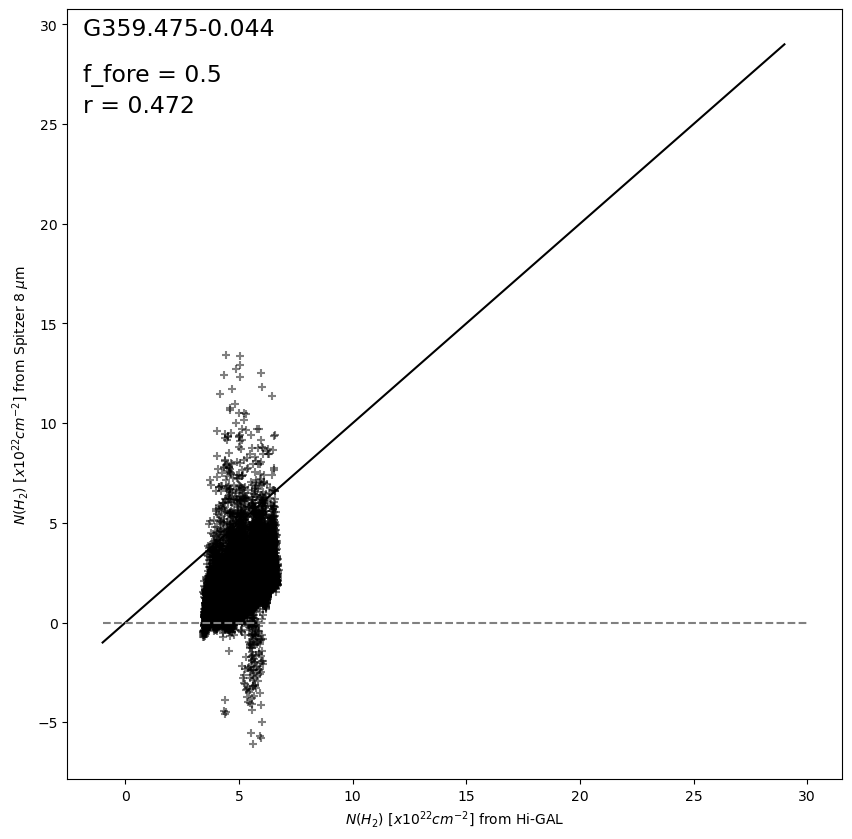

/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_24489/3066601015.py:19: RuntimeWarning: invalid value encountered in log
  return (-1./k_v) * np.log(  ((s+1)*I_1_obs - (s+1)*f_fore*I_0_obs) / ( (1-f_fore)*I_0_obs  ) ) #g/cm^2???


0.0020563959548156596


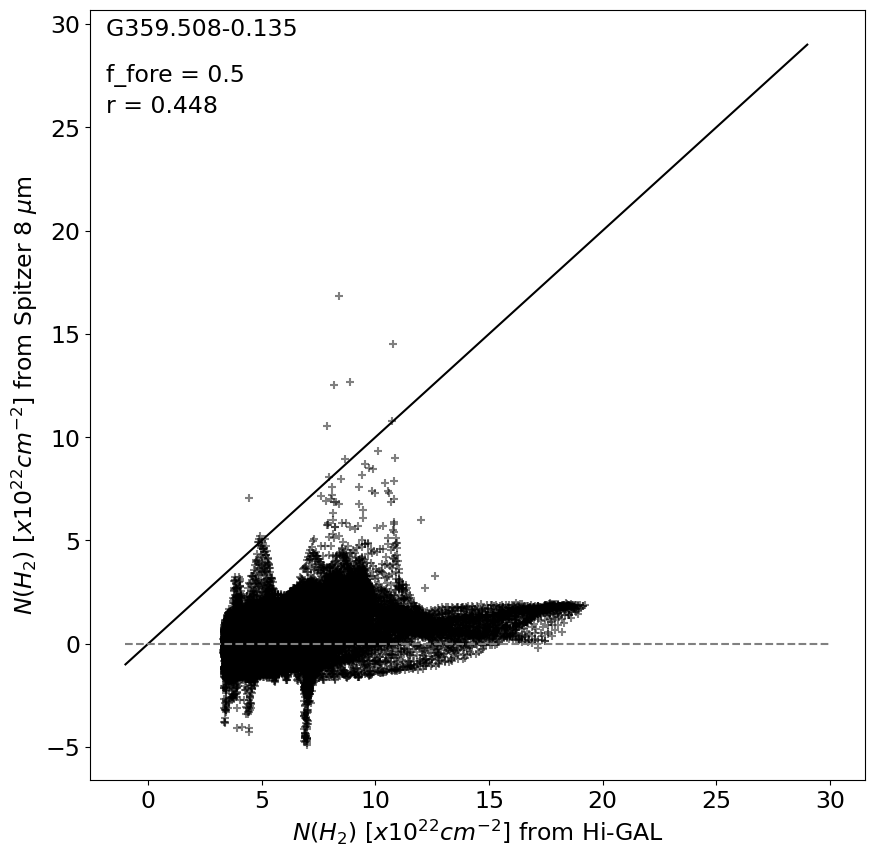

/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_24489/3066601015.py:19: RuntimeWarning: invalid value encountered in log
  return (-1./k_v) * np.log(  ((s+1)*I_1_obs - (s+1)*f_fore*I_0_obs) / ( (1-f_fore)*I_0_obs  ) ) #g/cm^2???


0.007163757441226881


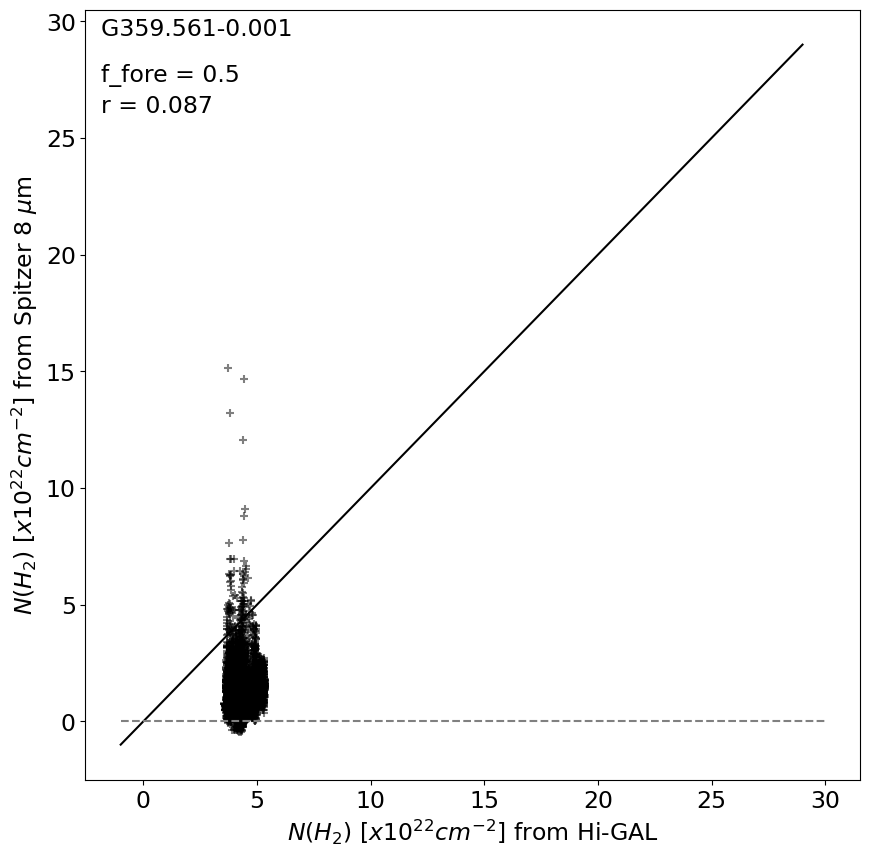

/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_24489/3066601015.py:19: RuntimeWarning: invalid value encountered in log
  return (-1./k_v) * np.log(  ((s+1)*I_1_obs - (s+1)*f_fore*I_0_obs) / ( (1-f_fore)*I_0_obs  ) ) #g/cm^2???


0.023163535237061605


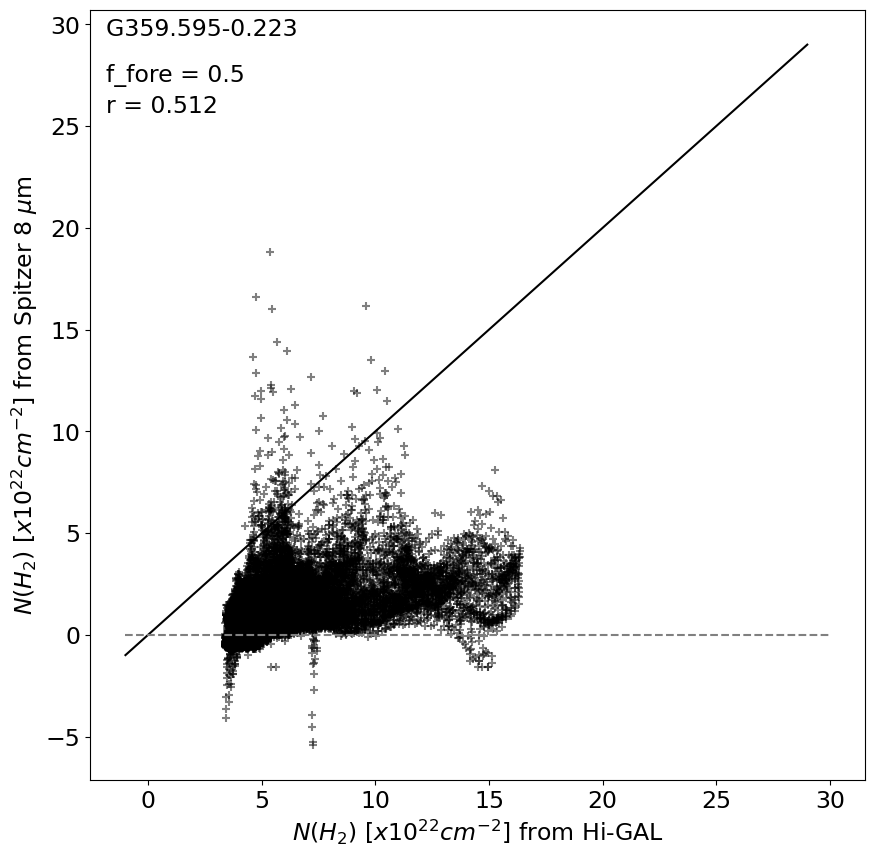

/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_24489/3066601015.py:19: RuntimeWarning: invalid value encountered in log
  return (-1./k_v) * np.log(  ((s+1)*I_1_obs - (s+1)*f_fore*I_0_obs) / ( (1-f_fore)*I_0_obs  ) ) #g/cm^2???


0.000341705108491408


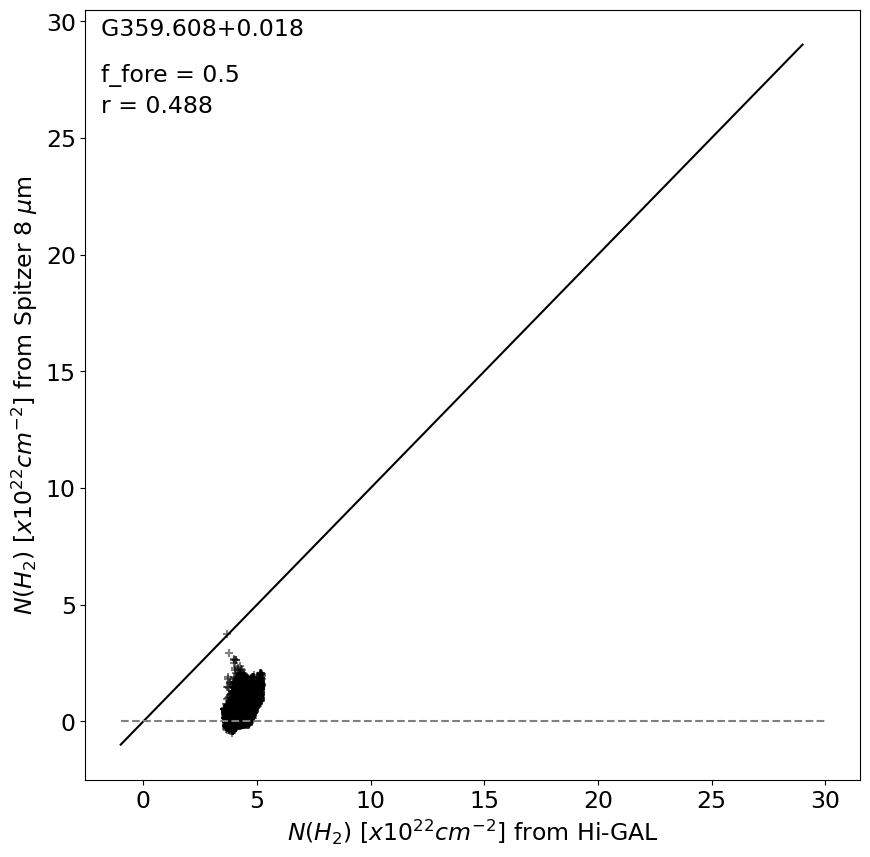

/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_24489/3066601015.py:19: RuntimeWarning: invalid value encountered in log
  return (-1./k_v) * np.log(  ((s+1)*I_1_obs - (s+1)*f_fore*I_0_obs) / ( (1-f_fore)*I_0_obs  ) ) #g/cm^2???


0.00011422044545972287


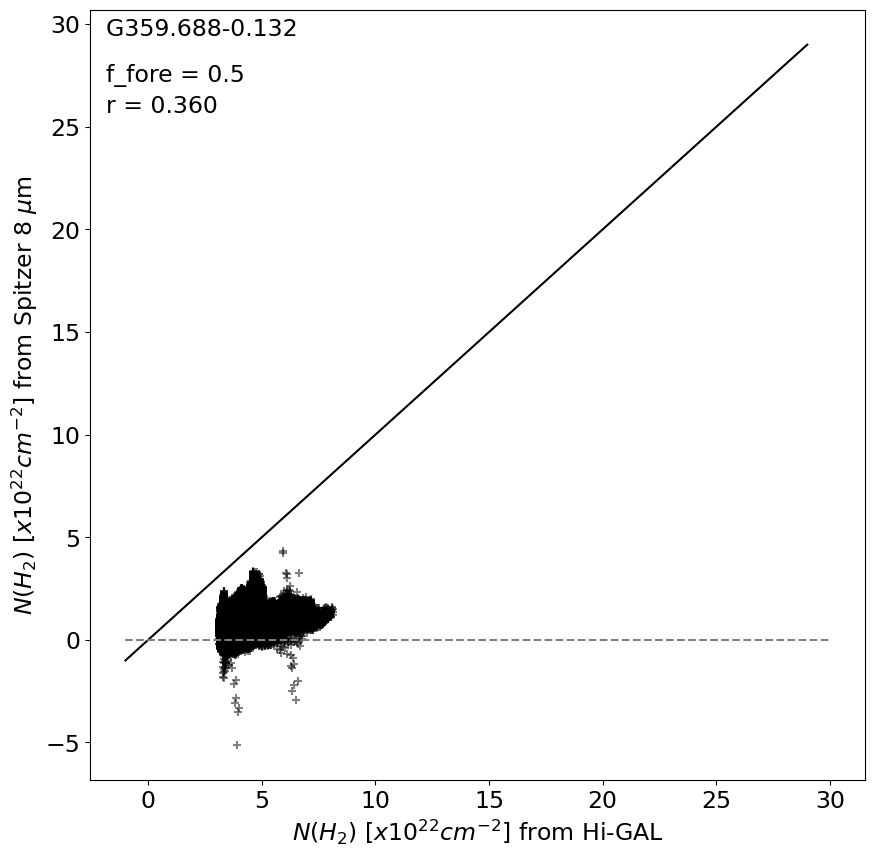

0.0


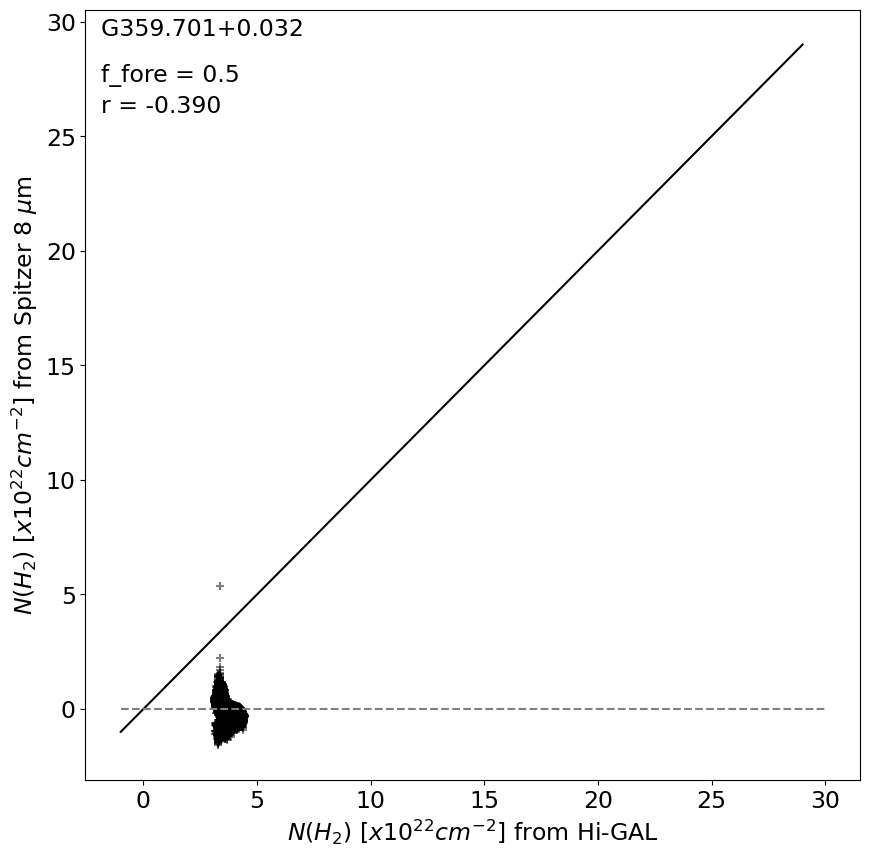

0.0


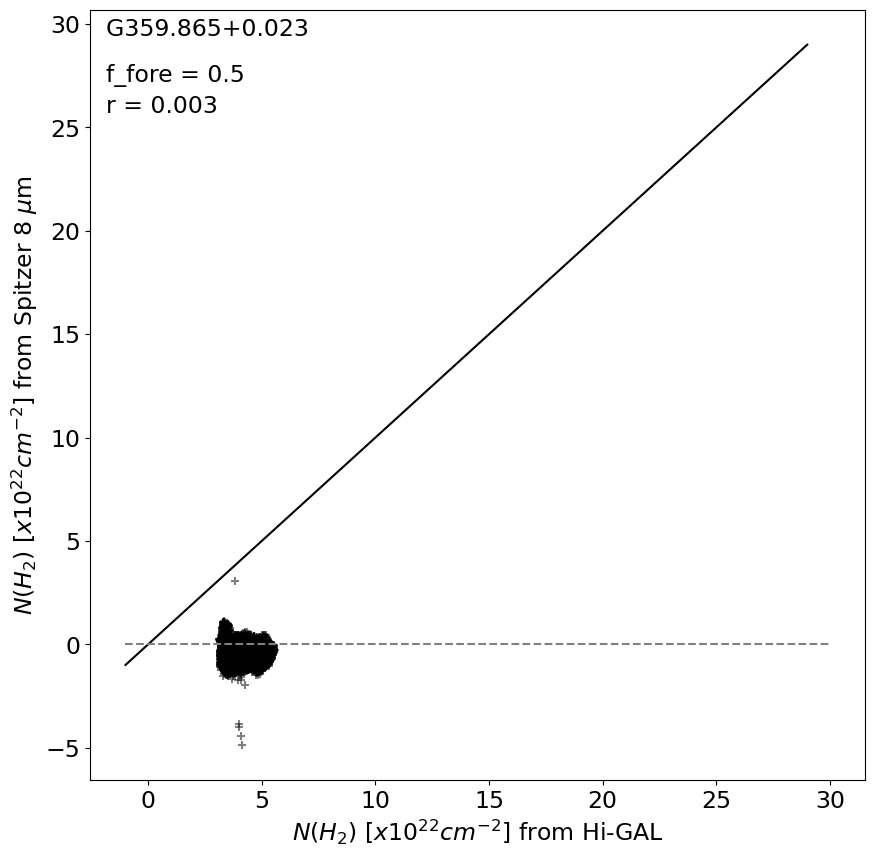

/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_24489/3066601015.py:19: RuntimeWarning: invalid value encountered in log
  return (-1./k_v) * np.log(  ((s+1)*I_1_obs - (s+1)*f_fore*I_0_obs) / ( (1-f_fore)*I_0_obs  ) ) #g/cm^2???


0.030890455933993755


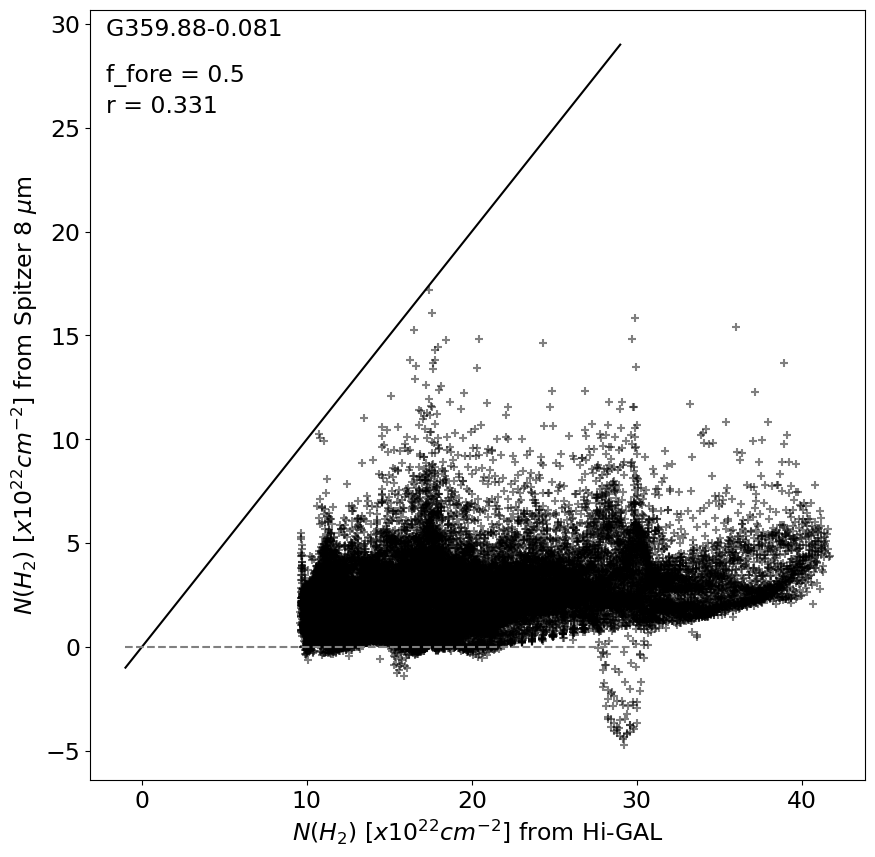

/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_24489/3066601015.py:19: RuntimeWarning: invalid value encountered in log
  return (-1./k_v) * np.log(  ((s+1)*I_1_obs - (s+1)*f_fore*I_0_obs) / ( (1-f_fore)*I_0_obs  ) ) #g/cm^2???


0.04732839703822289


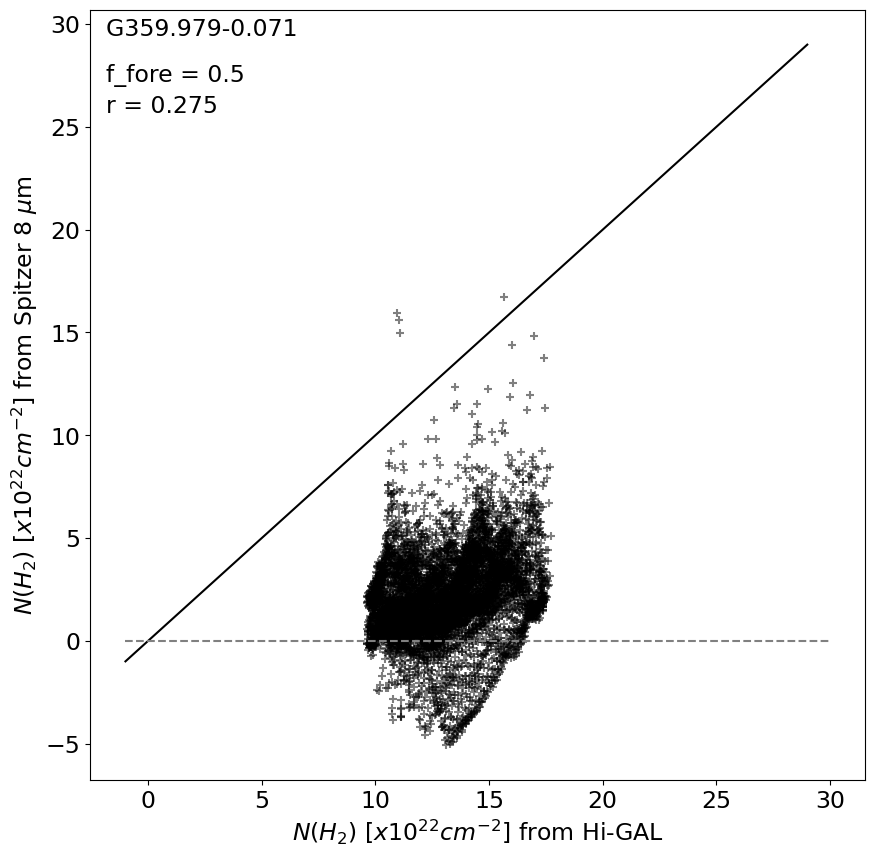

0.0


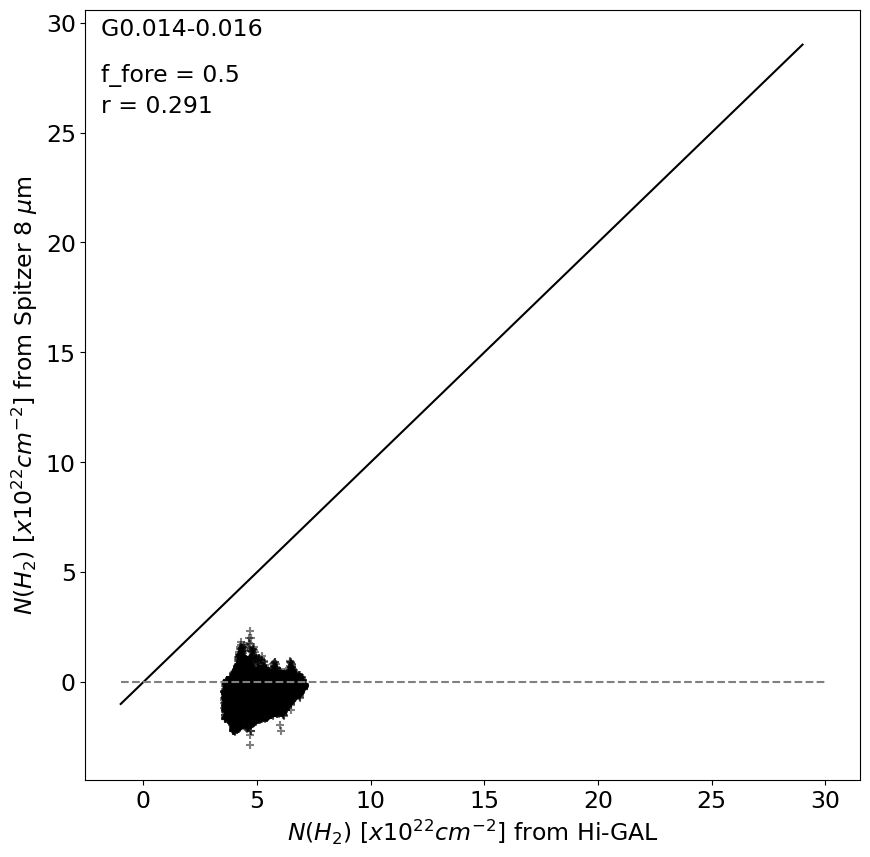

0.0


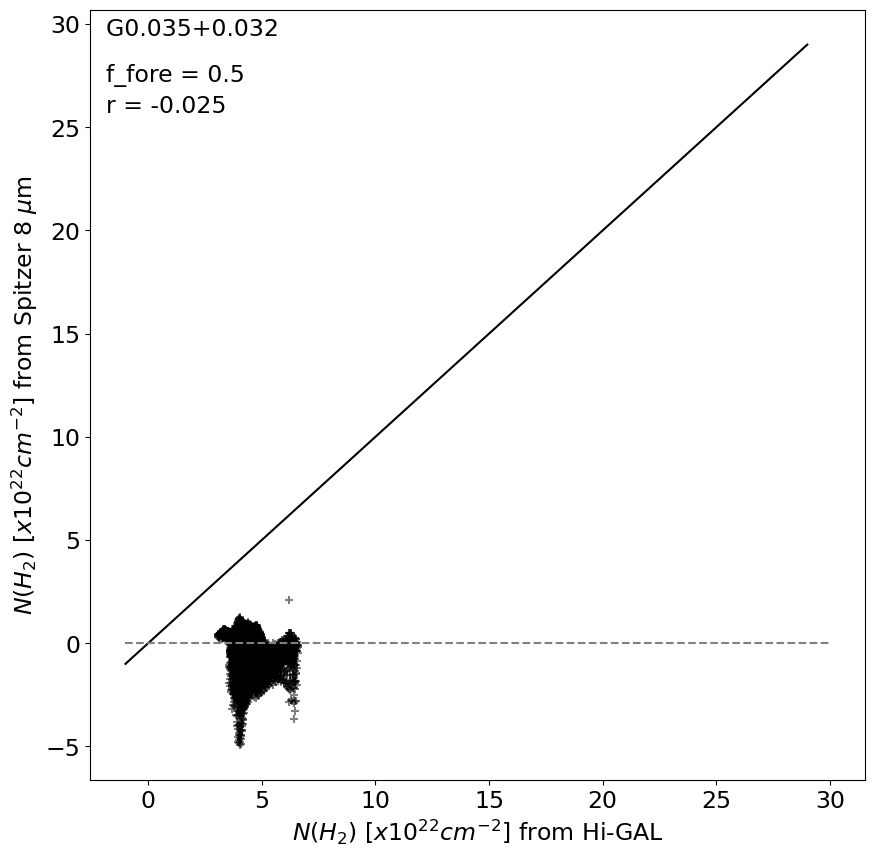

0.0


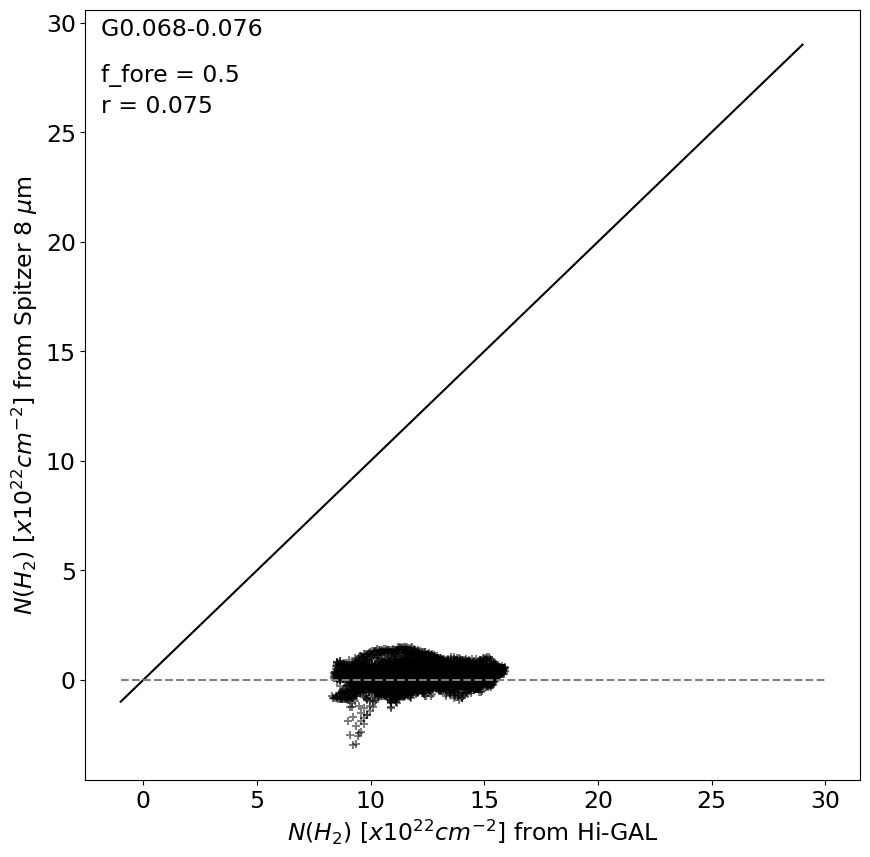

/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_24489/3066601015.py:19: RuntimeWarning: invalid value encountered in log
  return (-1./k_v) * np.log(  ((s+1)*I_1_obs - (s+1)*f_fore*I_0_obs) / ( (1-f_fore)*I_0_obs  ) ) #g/cm^2???


0.0014634146341463428


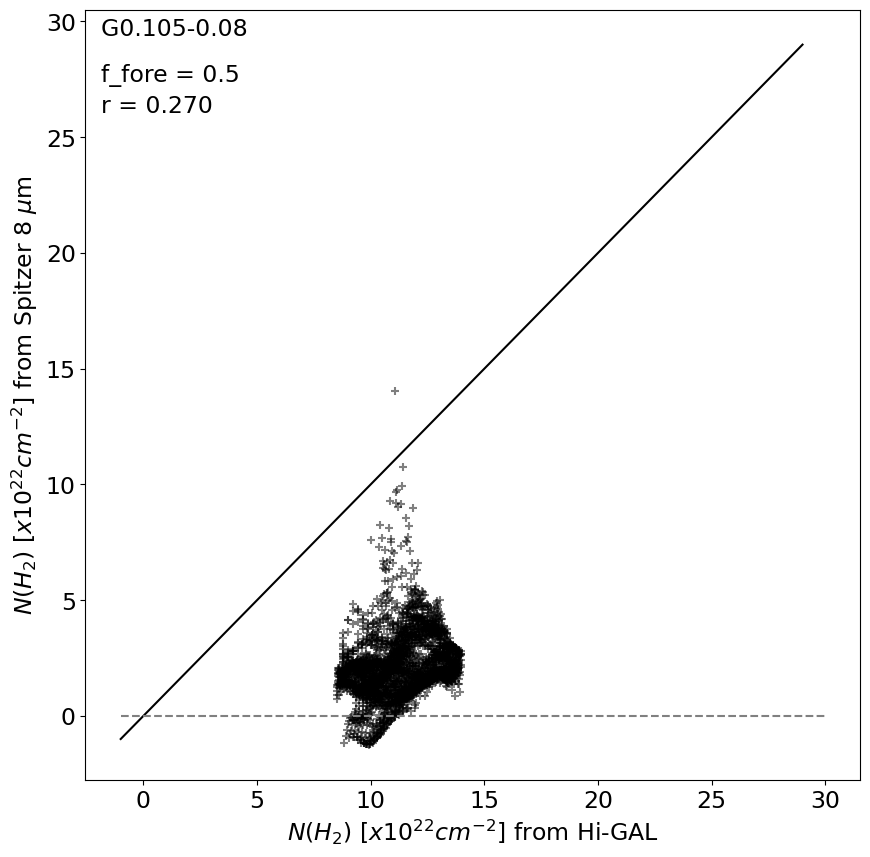

/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_24489/3066601015.py:19: RuntimeWarning: invalid value encountered in log
  return (-1./k_v) * np.log(  ((s+1)*I_1_obs - (s+1)*f_fore*I_0_obs) / ( (1-f_fore)*I_0_obs  ) ) #g/cm^2???


4.5158959537605625e-05


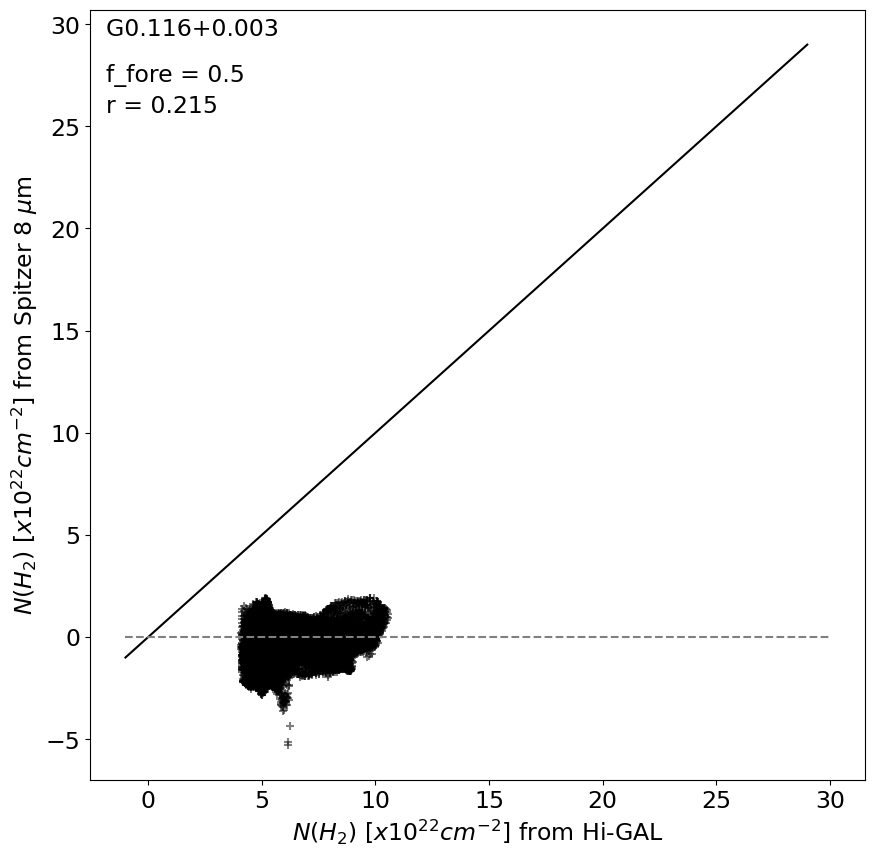

0.0


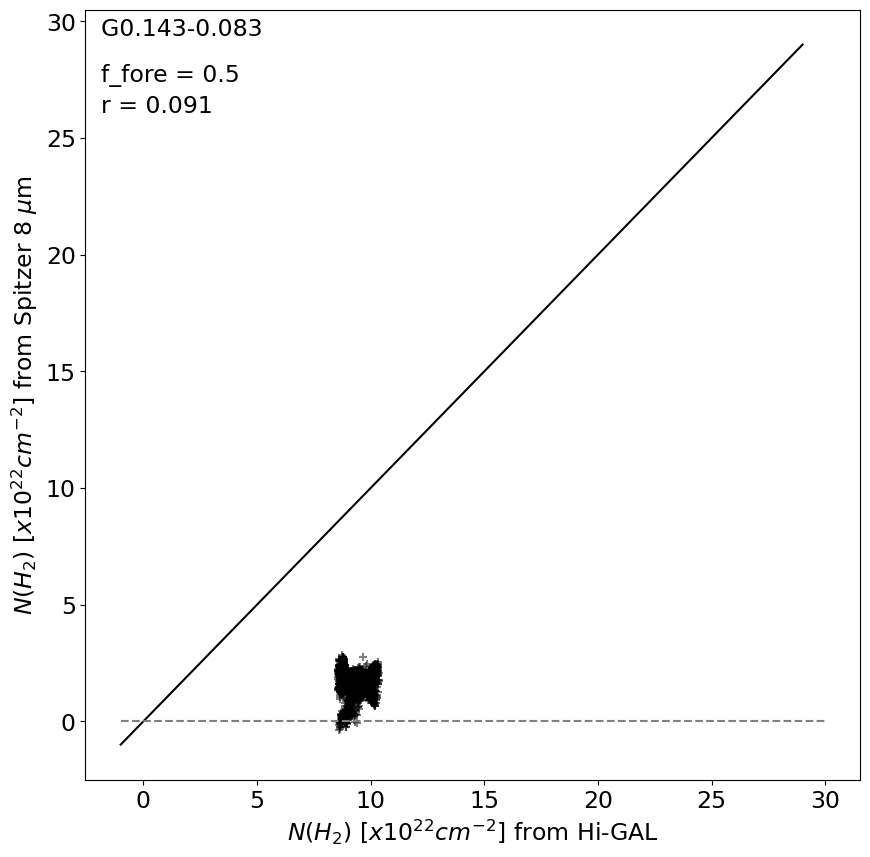

/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_24489/3066601015.py:19: RuntimeWarning: invalid value encountered in log
  return (-1./k_v) * np.log(  ((s+1)*I_1_obs - (s+1)*f_fore*I_0_obs) / ( (1-f_fore)*I_0_obs  ) ) #g/cm^2???


0.5712438954323471


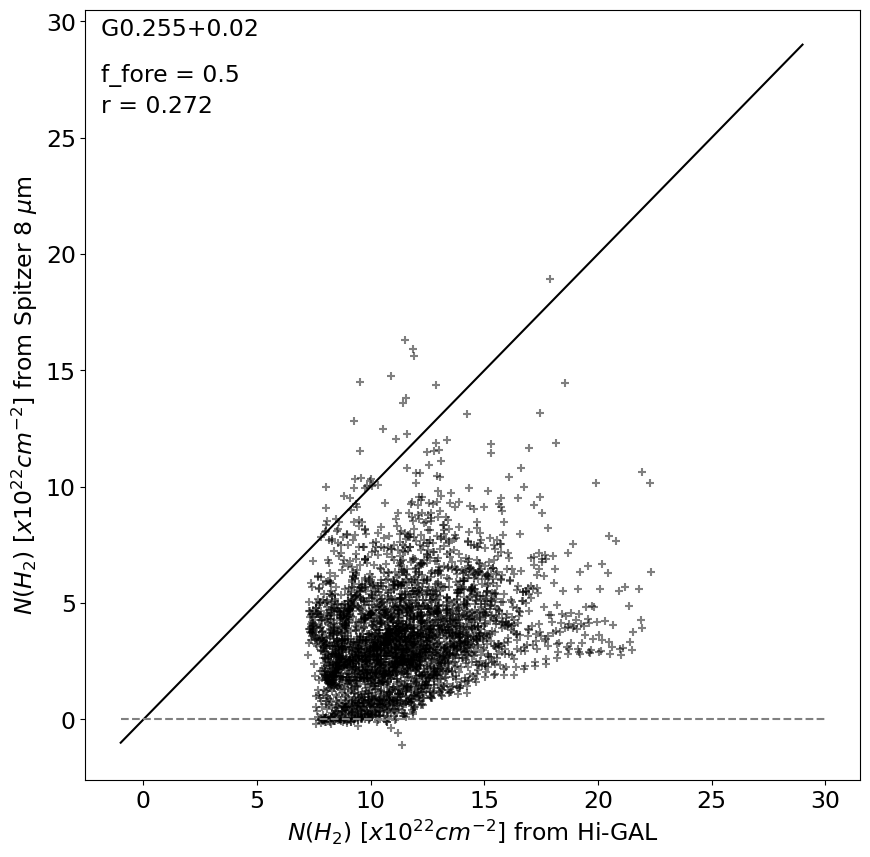

/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_24489/3066601015.py:19: RuntimeWarning: invalid value encountered in log
  return (-1./k_v) * np.log(  ((s+1)*I_1_obs - (s+1)*f_fore*I_0_obs) / ( (1-f_fore)*I_0_obs  ) ) #g/cm^2???


0.0011419359172432086


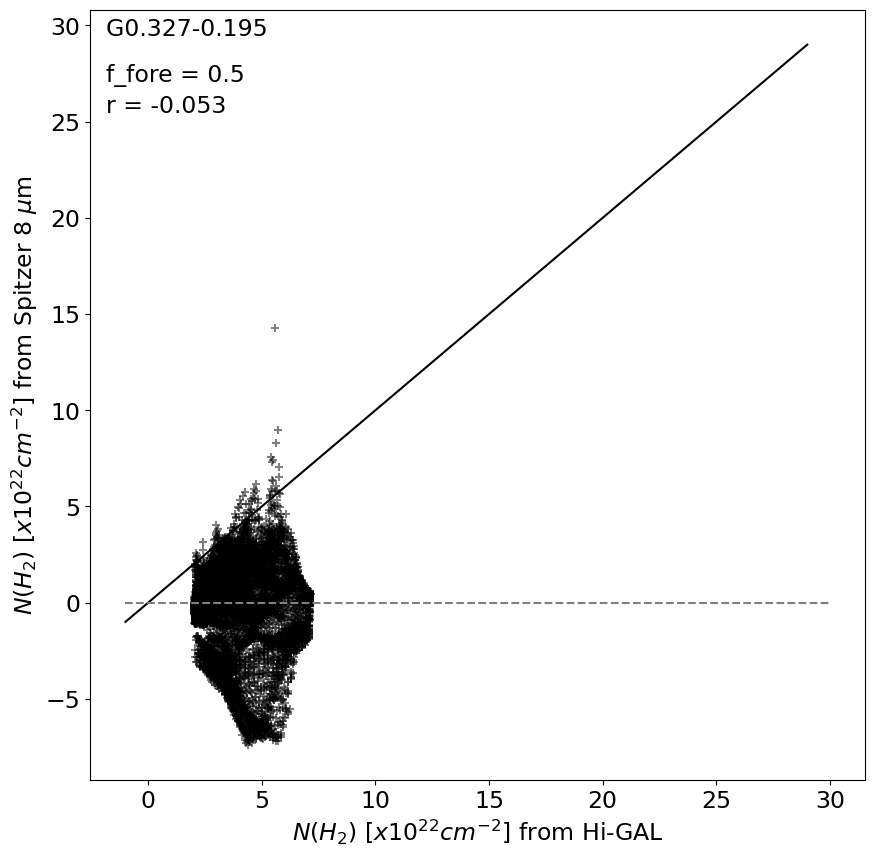

/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_24489/3066601015.py:19: RuntimeWarning: invalid value encountered in log
  return (-1./k_v) * np.log(  ((s+1)*I_1_obs - (s+1)*f_fore*I_0_obs) / ( (1-f_fore)*I_0_obs  ) ) #g/cm^2???


0.06870978296433639


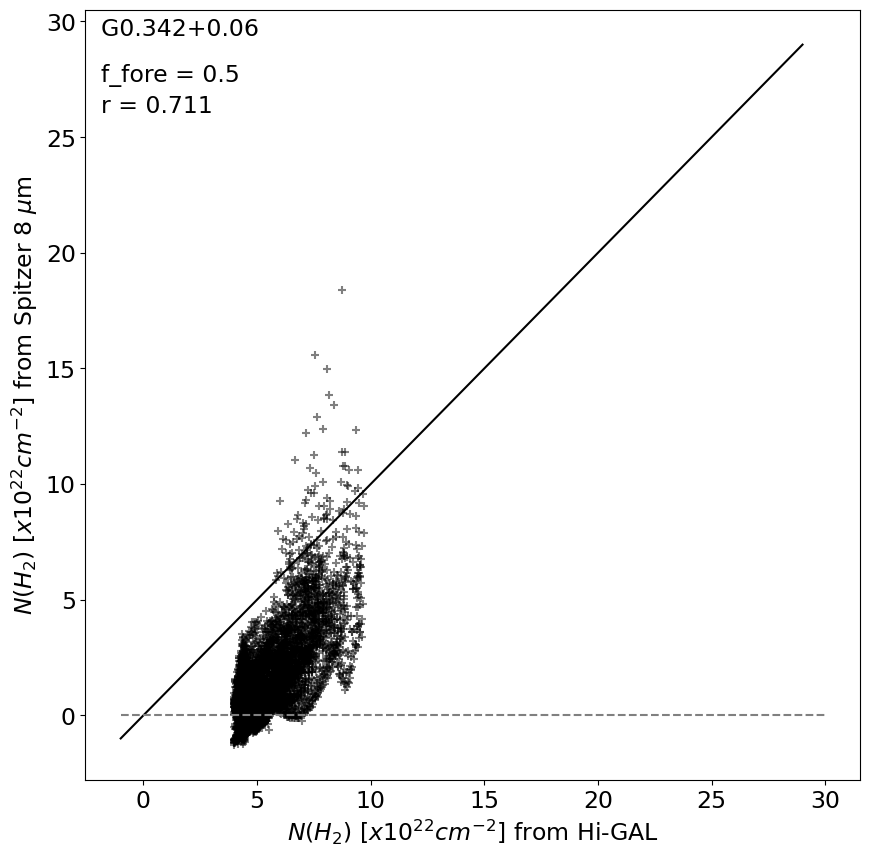

/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_24489/3066601015.py:19: RuntimeWarning: invalid value encountered in log
  return (-1./k_v) * np.log(  ((s+1)*I_1_obs - (s+1)*f_fore*I_0_obs) / ( (1-f_fore)*I_0_obs  ) ) #g/cm^2???


3.194888178914557e-05


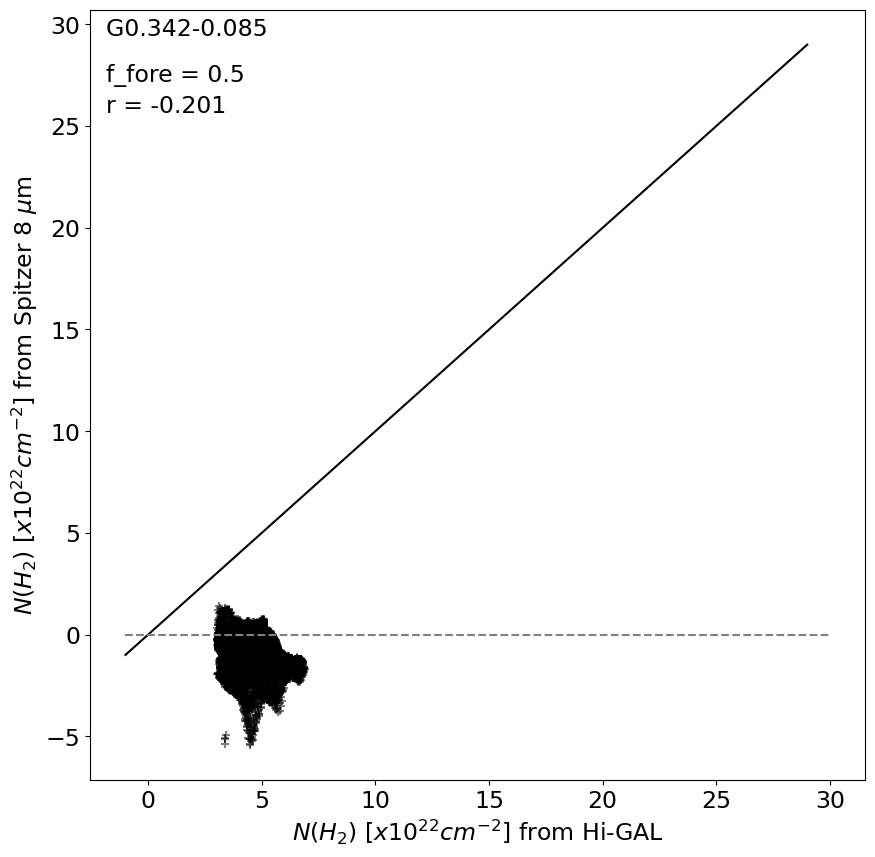

/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_24489/3066601015.py:19: RuntimeWarning: invalid value encountered in log
  return (-1./k_v) * np.log(  ((s+1)*I_1_obs - (s+1)*f_fore*I_0_obs) / ( (1-f_fore)*I_0_obs  ) ) #g/cm^2???


0.024832855778414542


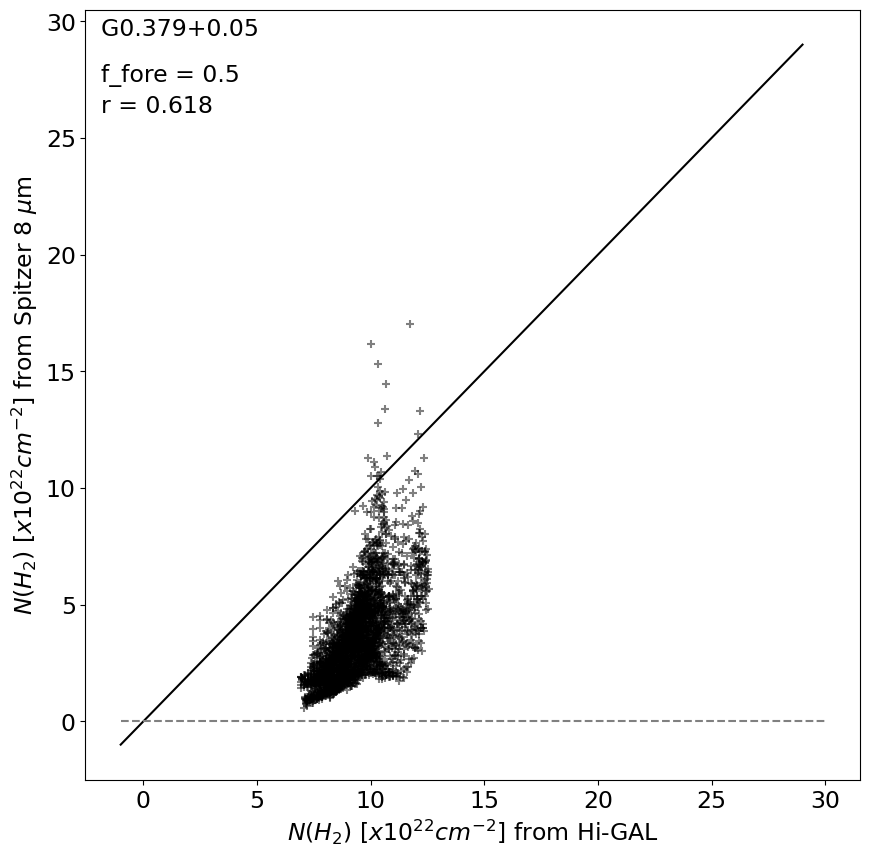

/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_24489/3066601015.py:19: RuntimeWarning: invalid value encountered in log
  return (-1./k_v) * np.log(  ((s+1)*I_1_obs - (s+1)*f_fore*I_0_obs) / ( (1-f_fore)*I_0_obs  ) ) #g/cm^2???


0.006910253088019402


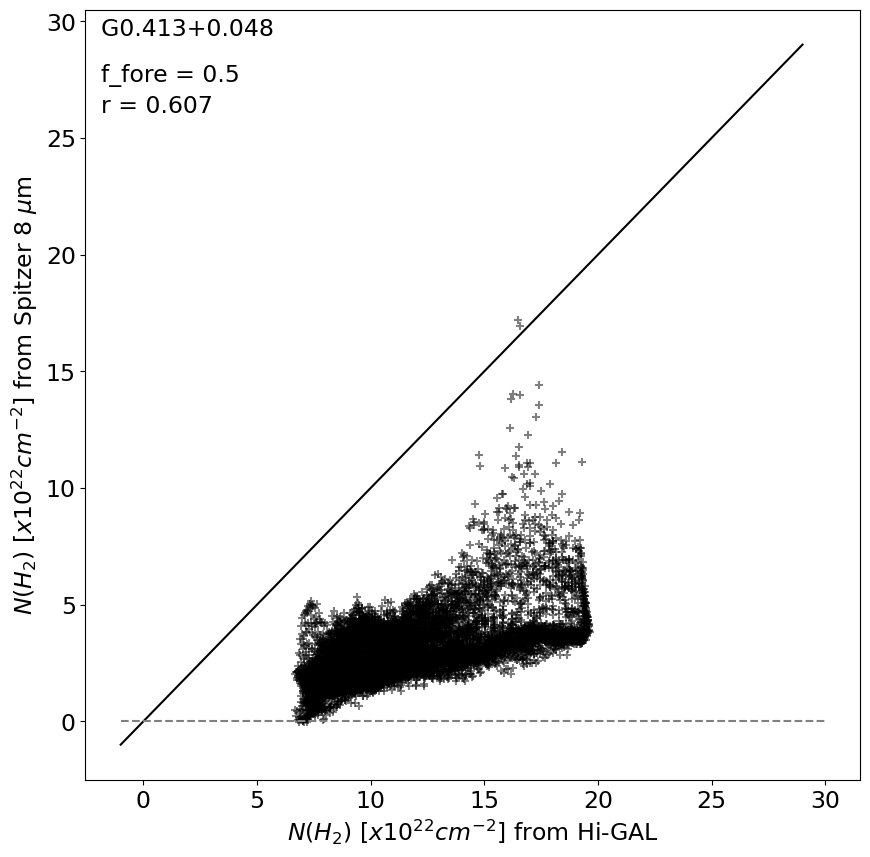

/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_24489/3066601015.py:19: RuntimeWarning: invalid value encountered in log
  return (-1./k_v) * np.log(  ((s+1)*I_1_obs - (s+1)*f_fore*I_0_obs) / ( (1-f_fore)*I_0_obs  ) ) #g/cm^2???


0.12132685817762778


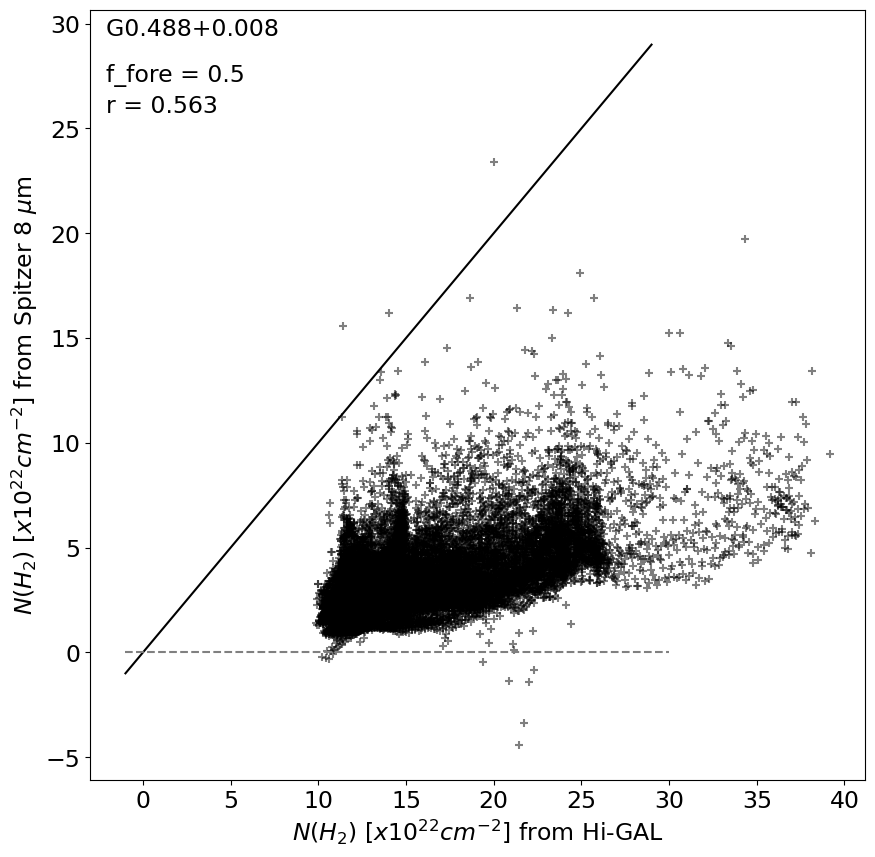

0.0


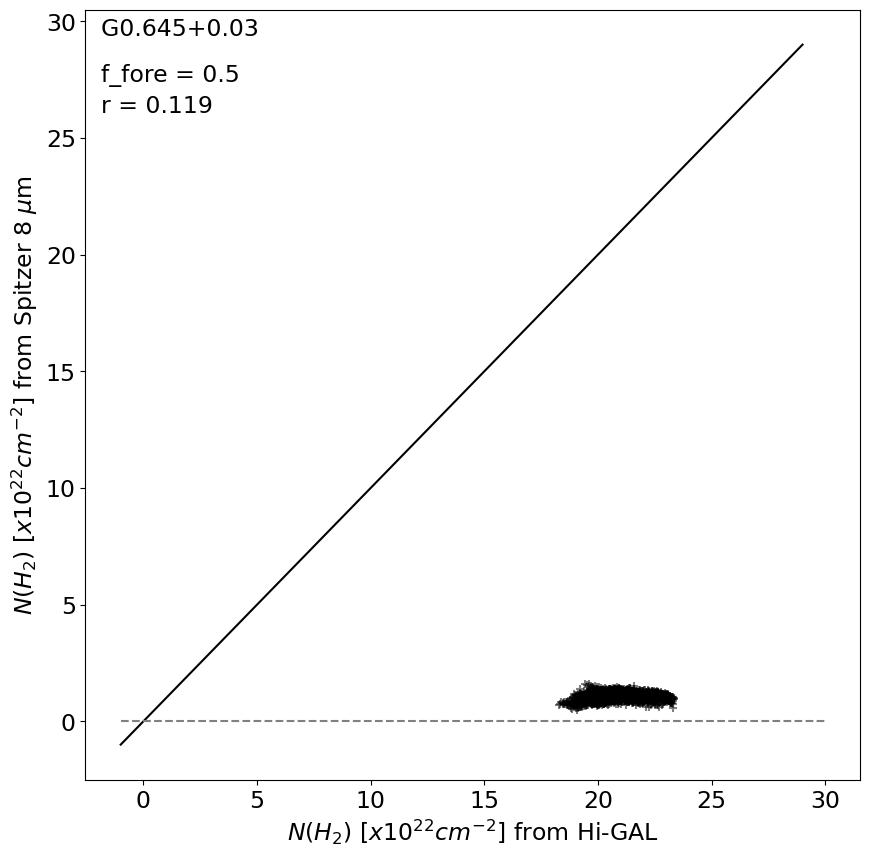

/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_24489/3066601015.py:19: RuntimeWarning: invalid value encountered in log
  return (-1./k_v) * np.log(  ((s+1)*I_1_obs - (s+1)*f_fore*I_0_obs) / ( (1-f_fore)*I_0_obs  ) ) #g/cm^2???


0.0007259218139504808


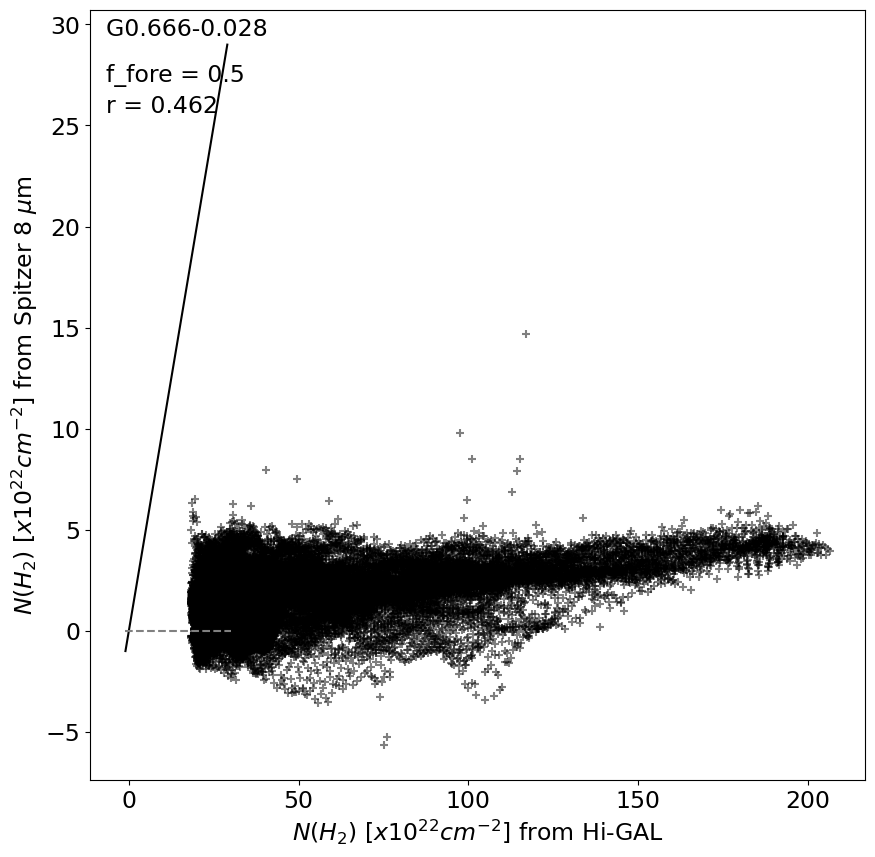

/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_24489/3066601015.py:19: RuntimeWarning: invalid value encountered in log
  return (-1./k_v) * np.log(  ((s+1)*I_1_obs - (s+1)*f_fore*I_0_obs) / ( (1-f_fore)*I_0_obs  ) ) #g/cm^2???


0.0010966114705559526


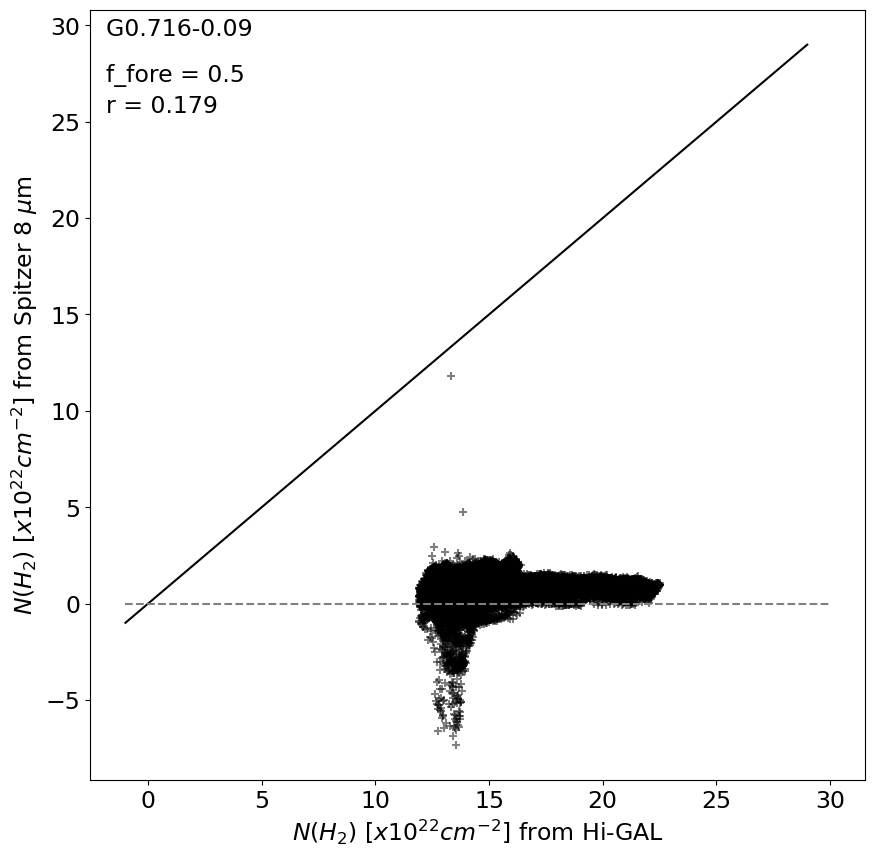

/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_24489/3066601015.py:19: RuntimeWarning: invalid value encountered in log
  return (-1./k_v) * np.log(  ((s+1)*I_1_obs - (s+1)*f_fore*I_0_obs) / ( (1-f_fore)*I_0_obs  ) ) #g/cm^2???


0.00040111614928495243


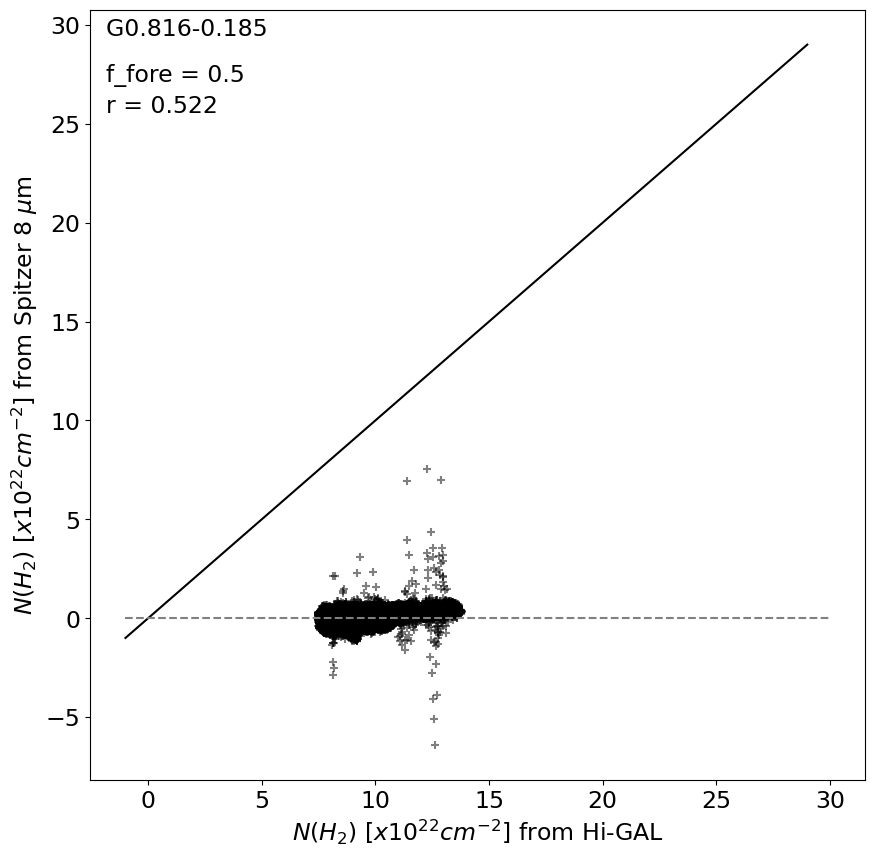

/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_24489/3066601015.py:19: RuntimeWarning: invalid value encountered in log
  return (-1./k_v) * np.log(  ((s+1)*I_1_obs - (s+1)*f_fore*I_0_obs) / ( (1-f_fore)*I_0_obs  ) ) #g/cm^2???


0.00016593754714133713


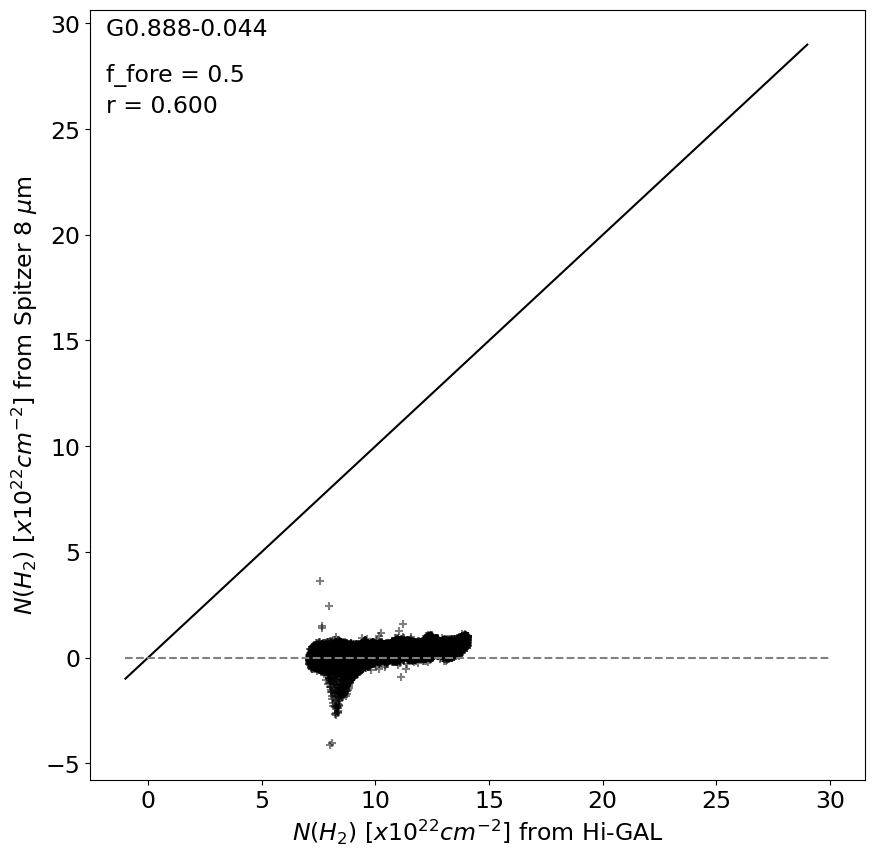

/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_24489/3066601015.py:19: RuntimeWarning: invalid value encountered in log
  return (-1./k_v) * np.log(  ((s+1)*I_1_obs - (s+1)*f_fore*I_0_obs) / ( (1-f_fore)*I_0_obs  ) ) #g/cm^2???


0.0013578127576207022


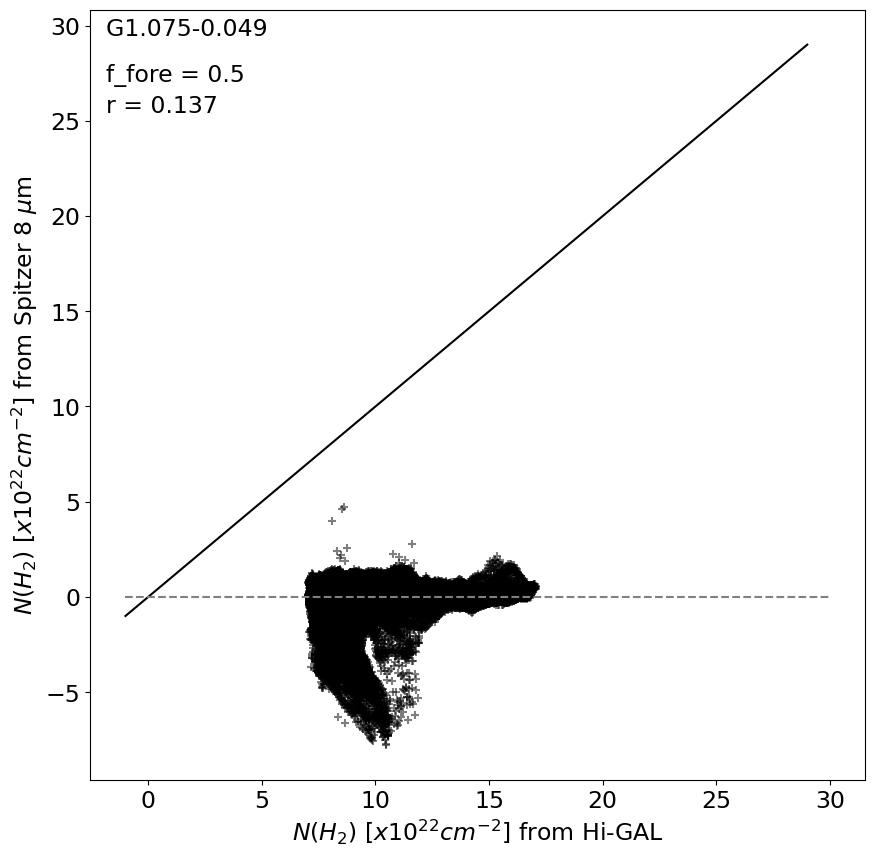

/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_24489/3066601015.py:19: RuntimeWarning: invalid value encountered in log
  return (-1./k_v) * np.log(  ((s+1)*I_1_obs - (s+1)*f_fore*I_0_obs) / ( (1-f_fore)*I_0_obs  ) ) #g/cm^2???


0.00020042088385607837


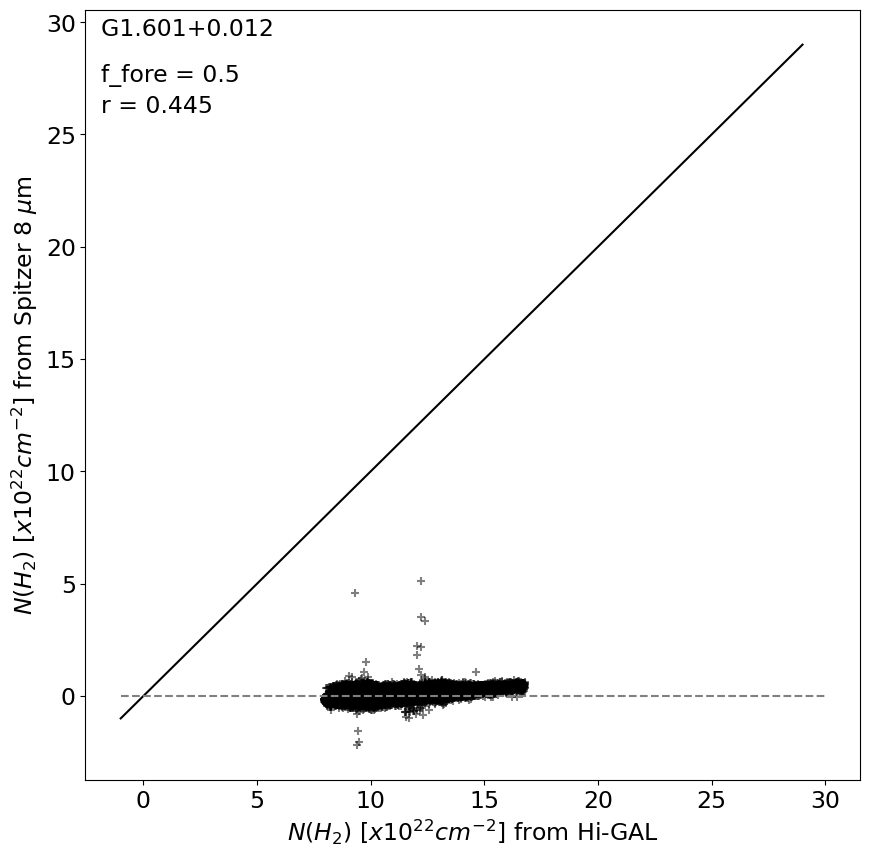

/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_24489/3066601015.py:19: RuntimeWarning: invalid value encountered in log
  return (-1./k_v) * np.log(  ((s+1)*I_1_obs - (s+1)*f_fore*I_0_obs) / ( (1-f_fore)*I_0_obs  ) ) #g/cm^2???


0.00015464714676016733


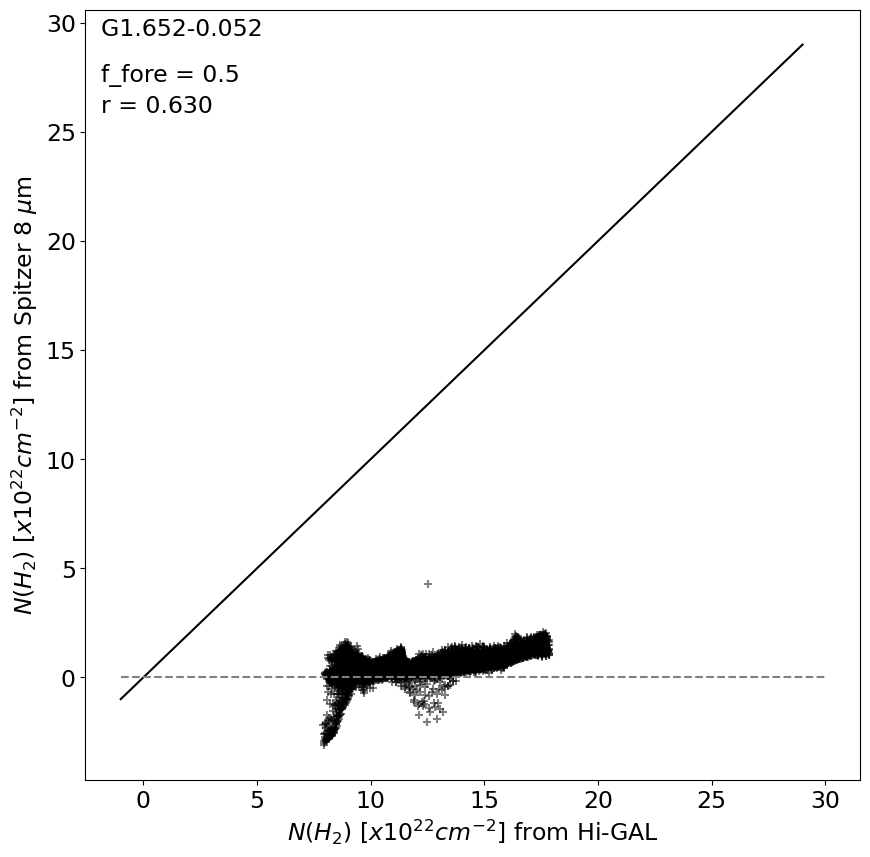

In [10]:
cloud_list = ["G359.475-0.044", "G359.508-0.135", "G359.561-0.001", "G359.595-0.223","G359.608+0.018",
              "G359.688-0.132", "G359.701+0.032", "G359.865+0.023", "G359.88-0.081", "G359.979-0.071",
              "G0.014-0.016","G0.035+0.032", "G0.068-0.076", "G0.105-0.08", "G0.116+0.003", "G0.143-0.083",
              "G0.255+0.02", "G0.327-0.195", "G0.342+0.06",  "G0.342-0.085", "G0.379+0.05", "G0.413+0.048", 
              "G0.488+0.008", "G0.645+0.03",  "G0.666-0.028", "G0.716-0.09", "G0.816-0.185" , "G0.888-0.044",
              "G1.075-0.049","G1.601+0.012", "G1.652-0.052"  ]

#cloud_list = ["G0.413+0.048"]

#f_fore_list = np.linspace(0.4,0.6,14)

f_fore_list=[0.5]

#Make your Gaussian
# sigma_gauss = sqrt( resolution you want^2 - resolution you have^2) = gaussian sigma
# gaussian sigma / number of arcseconds per pixel = 2 pixels # Your number will be different


#Want to match 36" convolution, Spitz 8um resolution is 1.2"
higal_colden_res = 36 /2.355 #sigma = FWHM/sqrt(8ln2) = FWHM/2.355
spitz8_res = 1.98/2.355

sig_gauss = np.sqrt(higal_colden_res**2 - spitz8_res**2 )
kern = sig_gauss/(1.2) #arcsec/pix

for Cloud in cloud_list:

    for f_fore in f_fore_list:
        
        cloud_EmvsExt(Cloud, f_fore)
        
        file = './Cloud_masks/{}/{}_8umExtN_ffore{:.2f}.fits'.format(Cloud, Cloud,f_fore)
        data = pyfits.open(file)[0].data

        hers8um = './paper_figs/Figs/GLM_8um.fits'
        
        h_file = pyfits.getheader(file)
        h_hers8um = pyfits.getheader(hers8um)

    
        #Convolve to 36" resoltuion
        
        smoothed = convolve_fft(data, Gaussian2DKernel(x_stddev=kern), normalize_kernel=True, preserve_nan=True, allow_huge=True)

        #Write to FITS

        pyfits.writeto('./Cloud_masks/{}/{}_ExtN8um_ffore{:.2f}_cutout_smoothed_conv36.fits'.format(Cloud,Cloud, f_fore), smoothed, h_file, overwrite=True) 
        
        
        
        
                
        ###REGRIDDING####
        
        #Load in the convolved file
        conv_file = pyfits.open('./Cloud_masks/{}/{}_ExtN8um_ffore{:.2f}_cutout_smoothed_conv36.fits'.format(Cloud,Cloud, f_fore))[0]
        
        
        #load in the cutout herschel file we want to regrid to
        cloud_hers_cutout = pyfits.open('./Cloud_masks/{}/{}_herschel_cutout_isolated.fits'.format(Cloud, Cloud))[0]
        
        regrid_array, regrid_footprint = reproject_interp(conv_file, cloud_hers_cutout.header)
        
        
        pyfits.writeto('./Cloud_masks/{}/{}_ExtN8um_ffore{:.2f}_cutout_smoothed_conv36_regrid_isolated.fits'.format(Cloud, Cloud, f_fore), 
                   regrid_array, cloud_hers_cutout.header, overwrite=True)       


# REGRIDDED COMPARISONS

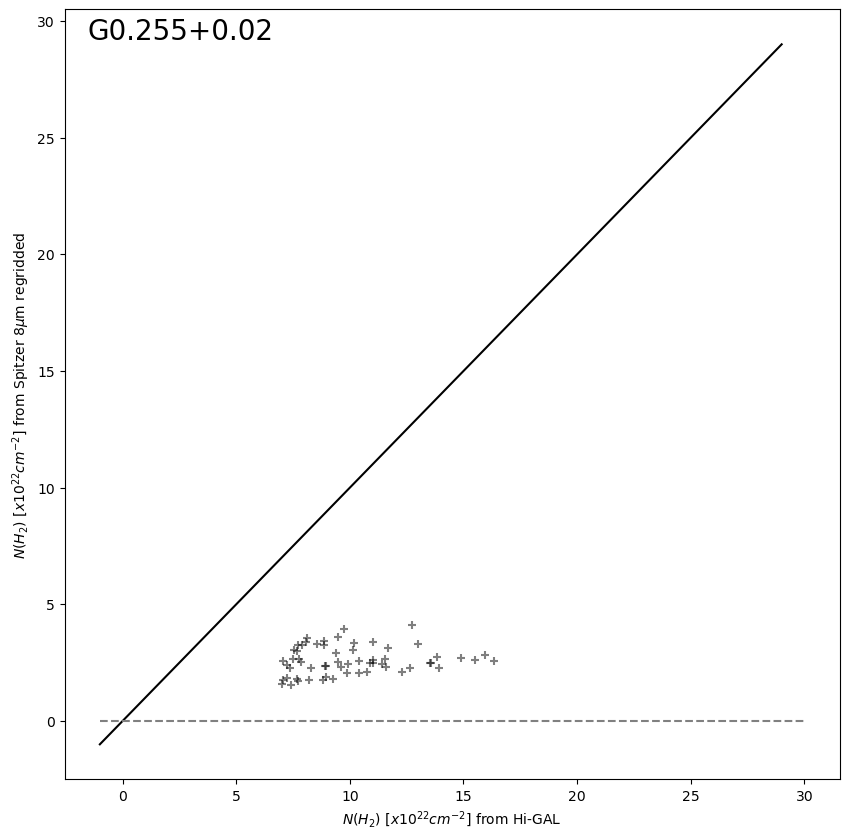

corr of optically thin points:  0.5984706621771546
corr of all points:  0.15954015526851303


In [13]:
#cloud_list = ['G0.488+0.008', 'G0.255+0.02','G359.701+0.032','G0.342+0.06','G0.342-0.085']
cloud_list = ["G359.475-0.044", "G359.508-0.135", "G359.561-0.001", "G359.595-0.223","G359.608+0.018",
              "G359.688-0.132", "G359.701+0.032", "G359.865+0.023", "G359.88-0.081", "G359.979-0.071",
              "G0.014-0.016","G0.035+0.032", "G0.068-0.076", "G0.105-0.08", "G0.116+0.003", "G0.143-0.083",
              "G0.255+0.02", "G0.327-0.195", "G0.342+0.06",  "G0.342-0.085", "G0.379+0.05", "G0.413+0.048", 
              "G0.488+0.008", "G0.645+0.03",  "G0.666-0.028", "G0.716-0.09", "G0.816-0.185" , "G0.888-0.044",
              "G1.075-0.049" ,"G1.601+0.012", "G1.652-0.052" ]

#cloud_list=["G1.601+0.012", "G1.652-0.052"]
cloud_list = ["G0.255+0.02"]
#cloud_list = ["G0.342-0.085"]

ext_list_8_conv = []
em_list_8_conv = []


f_fore=0.5

for Cloud in cloud_list:

    
    regrid_file = './Cloud_masks/{}/{}_ExtN8um_ffore{:.2f}_cutout_smoothed_conv36_regrid_isolated.fits'.format(Cloud, Cloud, f_fore)

    regrid_data = pyfits.open(regrid_file)[0].data

    cloud_hers = './Cloud_masks/{}/{}_herschel_cutout_isolated.fits'.format(Cloud,Cloud)
    cloud_hers_data = pyfits.open(cloud_hers)[0].data
    
    wcs = WCS(pyfits.open(regrid_file)[0].header)
    
    em_list_8_conv.append(np.nanmedian(cloud_hers_data)/10**22)
    ext_list_8_conv.append(np.nanmedian(regrid_data)/10**22)
    
    #print(np.shape(regrid_to_nans_data))
    #print(np.shape(cloud_hers_data))
    
    #Make plot similar to Fig 3 in Battersby 2010

    fig = plt.figure(figsize = (10,10))
    ax1 = fig.add_subplot()
    plt.rcParams.update({'font.size': 17})

    x = np.arange(-1,30)
    y = np.arange(-1,30)

    thin_pts = np.where(regrid_data/10**22<1.8)
    thick_pts = np.where(regrid_data/10**22>=1.8)
    
    ax1.scatter(cloud_hers_data[thin_pts]/1E22,regrid_data[thin_pts]/1E22, 
                marker='+', color = 'k', alpha=0.5, )
    
    ax1.scatter(cloud_hers_data[thick_pts]/1E22,regrid_data[thick_pts]/1E22, 
                marker='+', color = 'k', alpha=0.5, )
    
    

    
    plt.plot(x,y, c='black')
    plt.hlines(0,-1, 30, linestyle='--', color='gray')
    #plt.hlines(1.8,-1, 30, linestyle='--', color='red', label = "8um tau=1")
    plt.xlabel(r"$N(H_{2})$ [$x10^{22} cm^{-2}$] from Hi-GAL")
    plt.ylabel(r"$N(H_{2})$ [$x10^{22} cm^{-2}$] from Spitzer 8$\mu$m regridded")
    #plt.legend(loc=2)
    plt.text(.03, .99, '{}'.format(Cloud), ha='left', va='top', fontsize = 20, transform=ax1.transAxes)

    plt.show()
    
    xy_thin = pd.DataFrame({'Herschel thin': cloud_hers_data[thin_pts].flatten(), 'Ext Col Den thin': regrid_data[thin_pts].flatten()})

    
    print('corr of optically thin points: ', xy_thin['Herschel thin'].corr(xy_thin['Ext Col Den thin']))
    
    xy_all = pd.DataFrame({'Herschel': cloud_hers_data.flatten(), 'Ext Col Den': regrid_data.flatten()})
    print('corr of all points: ',xy_all['Herschel'].corr(xy_all['Ext Col Den']))
    



# COMPARE CORR COEFF WITH NEW METHODS

In [10]:
###Make new .txt file will the corr_coeffs 


tab = Table.read("./paper_figs/Tables/CMZ_cat_flux_method_corr_coeff.tex")

tab['Cloud_name'] = ["G359.475-0.044", "G359.508-0.135", "G359.561-0.001", "G359.595-0.223","G359.608+0.018",
              "G359.688-0.132", "G359.701+0.032", "G359.865+0.023", "G359.88-0.081", "G359.979-0.071", 
              "G0.014-0.016","G0.035+0.032", "G0.068-0.076", "G0.105-0.08", "G0.116+0.003","G0.143-0.083", 
              "G0.255+0.02", "G0.327-0.195", "G0.342+0.06",  "G0.342-0.085", "G0.379+0.05", "G0.413+0.048", 
              "G0.488+0.008", "G0.645+0.03",  "G0.666-0.028", "G0.716-0.09", "G0.816-0.185" , "G0.888-0.044",
              "G1.075-0.049", "G1.601+0.012", "G1.652-0.052"  ]


#df.to_csv("./paper_figs/Tables/CMZ_cat_flux_method_corr_coeff.tex", sep='\t', index = False)
 
    
tab


<Table length=31>
leaf id    l       b     I\_cloud   I\_model  Flux Ratio Extinction Fraction Flux Difference  Min Flux    Cloud_name  
 int64  float64 float64  float64    float64    float64         float64           float64      float64       str14     
------- ------- ------- ---------- ---------- ---------- ------------------- --------------- ---------- --------------
      1  -0.525  -0.044 212.666931 317.106415   0.506382             0.99216       31.669484  82.970551 G359.475-0.044
      2  -0.492  -0.135 224.208832 276.371979    0.62278            0.814856      -20.606853 117.933815 G359.508-0.135
      3  -0.439  -0.001 197.054138 263.149902    0.55088            0.997175       -6.674236 106.364929 G359.561-0.001
      4  -0.405  -0.223 181.048737 231.695618   0.556587            0.938479      -22.123119 100.902725 G359.595-0.223
      5  -0.392   0.018 185.011978 230.971039   0.575492            0.997266      -26.810939 123.727791 G359.608+0.018
      6  -0.312  -0.132 205.725388 273.478363   0.561783            0.993192       -5.017025  151.44519 G359.688-0.132
      7  -0.299   0.032 206.212036 234.486603   0.657274               0.771      -44.495433 154.551041 G359.701+0.032
      8  -0.135   0.023 329.555237 315.286926    0.88004            0.400181      -87.038311 197.791824 G359.865+0.023
      9   -0.12  -0.081 195.590393 315.943146   0.454197            0.995689       47.582753 126.201447  G359.88-0.081
     10  -0.021  -0.071 314.436798 478.219635   0.548591            0.918061       91.012837 161.220474 G359.979-0.071
     11   0.014  -0.016 560.763062 538.628357   0.944386            0.393568      -94.904705 249.024414   G0.014-0.016
     12   0.035   0.032 495.001648 463.882416   0.954793            0.393717     -103.889232  213.75351   G0.035+0.032
     13   0.068  -0.076 307.207092 366.652771     0.6958            0.851852      -13.324321 201.310287   G0.068-0.076
     14   0.105   -0.08 205.482986 316.897095   0.484047            0.945854       38.644108 146.993408    G0.105-0.08
     15   0.116   0.003 477.385193 458.666077   0.927244             0.45019      -91.489116 199.740631   G0.116+0.003
     16   0.143  -0.083  208.19548 317.109406   0.492276            0.991053       36.143925 126.956001   G0.143-0.083
     17   0.255    0.02 168.451981 364.086182     0.3196             0.99763      122.864201  65.540863    G0.255+0.02
     18   0.327  -0.195 160.250061 187.323807   0.577396            0.687916      -45.696254  69.896095   G0.327-0.195
     19   0.342    0.06 182.745941 250.177673   0.522253            0.937725       -5.338268   66.59774    G0.342+0.06
     20   0.342  -0.085 299.492981  298.69516   0.828279            0.438562      -73.567821 133.011276   G0.342-0.085
     21   0.379    0.05 132.239624 224.107422   0.357639                 1.0       19.097798   61.89188    G0.379+0.05
     22   0.413   0.048  114.22377 190.316147   0.326477                 1.0        3.322377  59.849129   G0.413+0.048
     23   0.488   0.008 111.192307 197.490112   0.299267            0.998806       13.527806  49.439621   G0.488+0.008
     24   0.645    0.03  71.227654  99.076164   0.193161                 1.0      -44.921489  45.608364    G0.645+0.03
     25   0.666  -0.028  74.038536 121.164352   0.181147            0.932788      -25.644184  38.642666   G0.666-0.028
     26   0.716   -0.09  76.240822  97.509834   0.247676            0.965692      -51.500988  42.910172    G0.716-0.09
     27   0.816  -0.185  66.862381  75.243546   0.196328            0.929264      -64.388835  41.467106   G0.816-0.185
     28   0.888  -0.044  72.633331  84.835541   0.242155             0.98413      -60.567791  44.973209   G0.888-0.044
     29   1.075  -0.049  84.128036  94.111717   0.340426            0.792828      -62.786319  40.376869   G1.075-0.049
     30   1.601   0.012  51.997845  59.258743  -0.001555            0.988776      -65.509101  45.475452   G1.601+0.012
     31   1.652  -0.052  48.751091  59.838257  -0.05579

In [11]:
corr_coeff_f05_thin = []
corr_coeff_f05_all = []


ext_list_8_conv = []
em_list_8_conv = []

cloud_list_works = ["G359.475-0.044", "G359.508-0.135", "G359.561-0.001", "G359.595-0.223","G359.608+0.018",
              "G359.688-0.132", "G359.701+0.032", "G359.865+0.023", "G359.88-0.081", "G359.979-0.071",
              "G0.014-0.016","G0.035+0.032", "G0.068-0.076", "G0.105-0.08", "G0.116+0.003", "G0.143-0.083",
              "G0.255+0.02", "G0.327-0.195", "G0.342+0.06",  "G0.342-0.085", "G0.379+0.05", "G0.413+0.048", 
              "G0.488+0.008", "G0.645+0.03",  "G0.666-0.028", "G0.716-0.09", "G0.816-0.185" , "G0.888-0.044",
              "G1.075-0.049" ,"G1.601+0.012", "G1.652-0.052" ]

cloud_ids_works = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16, 17,18,19,20,21,22,23,24,25,26,27,28,29,30,31]

#bad_list = [ "G1.601+0.012", "G1.652-0.052" ]

for Cloud in cloud_list_works:

    
    #ffore = 0.5
    regrid_file = './Cloud_masks/{}/{}_ExtN8um_ffore{:.2f}_cutout_smoothed_conv36_regrid_isolated.fits'.format(Cloud, Cloud, 0.5)
    regrid_data = pyfits.open(regrid_file)[0].data

    cloud_hers = './Cloud_masks/{}/{}_herschel_cutout_isolated.fits'.format(Cloud,Cloud)
    cloud_hers_data = pyfits.open(cloud_hers)[0].data
    
    wcs = WCS(pyfits.open(regrid_file)[0].header)
    
    thin_pts = np.where(regrid_data/10**22<12.3)
    thick_pts = np.where(regrid_data/10**22>=12.3)
    

     
    xy_thin = pd.DataFrame({'Herschel thin': cloud_hers_data[thin_pts].flatten(), 'Ext Col Den thin': regrid_data[thin_pts].flatten()})
    corr_coeff_f05_thin.append(xy_thin['Herschel thin'].corr(xy_thin['Ext Col Den thin'], method='spearman'))
    
    xy_all = pd.DataFrame({'Herschel': cloud_hers_data.flatten(), 'Ext Col Den': regrid_data.flatten()})
    corr_coeff_f05_all.append(xy_all['Herschel'].corr(xy_all['Ext Col Den'], method='pearson'))
    #print(len(cloud_hers_data))
    
    
corr_coeff_table = Table([cloud_ids_works, cloud_list_works,  corr_coeff_f05_thin, corr_coeff_f05_all ], 
                         names = ('coeff_leaf_ids', 'cloud_list_works',  'p_f05_thin',  'p_f05_all'))


d = {'coeff leaf ids':cloud_ids_works, 
     'cloud list works':cloud_list_works,
     'p f05 thin':corr_coeff_f05_thin, 
     'p f05 all':corr_coeff_f05_all}
df = pd.DataFrame(data=d)

df.to_latex('corr_coeff_table_8um.tex',index=False, float_format='%.3f')

corr_coeff_table.round(decimals={ 'p_f05_thin':3, 'p_f05_all':3 })
corr_coeff_table.write('corr_coeff_table_8um.dat', format='ascii', overwrite=True)


corr_coeff_table['coeff_leaf_ids','cloud_list_works', 'p_f05_thin','p_f05_all'].pprint_all()

coeff_leaf_ids cloud_list_works p_f05_thin p_f05_all
-------------- ---------------- ---------- ---------
             1   G359.475-0.044      0.596     0.546
             2   G359.508-0.135      0.432     0.481
             3   G359.561-0.001      0.199     0.028
             4   G359.595-0.223      0.646     0.633
             5   G359.608+0.018      0.484     0.423
             6   G359.688-0.132      0.484     0.381
             7   G359.701+0.032     -0.412    -0.407
             8   G359.865+0.023     -0.127    -0.111
             9    G359.88-0.081      0.403     0.435
            10   G359.979-0.071      0.189     0.172
            11     G0.014-0.016      0.173     0.142
            12     G0.035+0.032     -0.171    -0.164
            13     G0.068-0.076      0.063     0.091
            14      G0.105-0.08      0.365     0.372
            15     G0.116+0.003      0.152     0.194
            16     G0.143-0.083     -0.038     0.124
            17      G0.255+0.02      0.205    

/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_42161/3623167279.py:56: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df.to_latex('corr_coeff_table_8um.tex',index=False, float_format='%.3f')


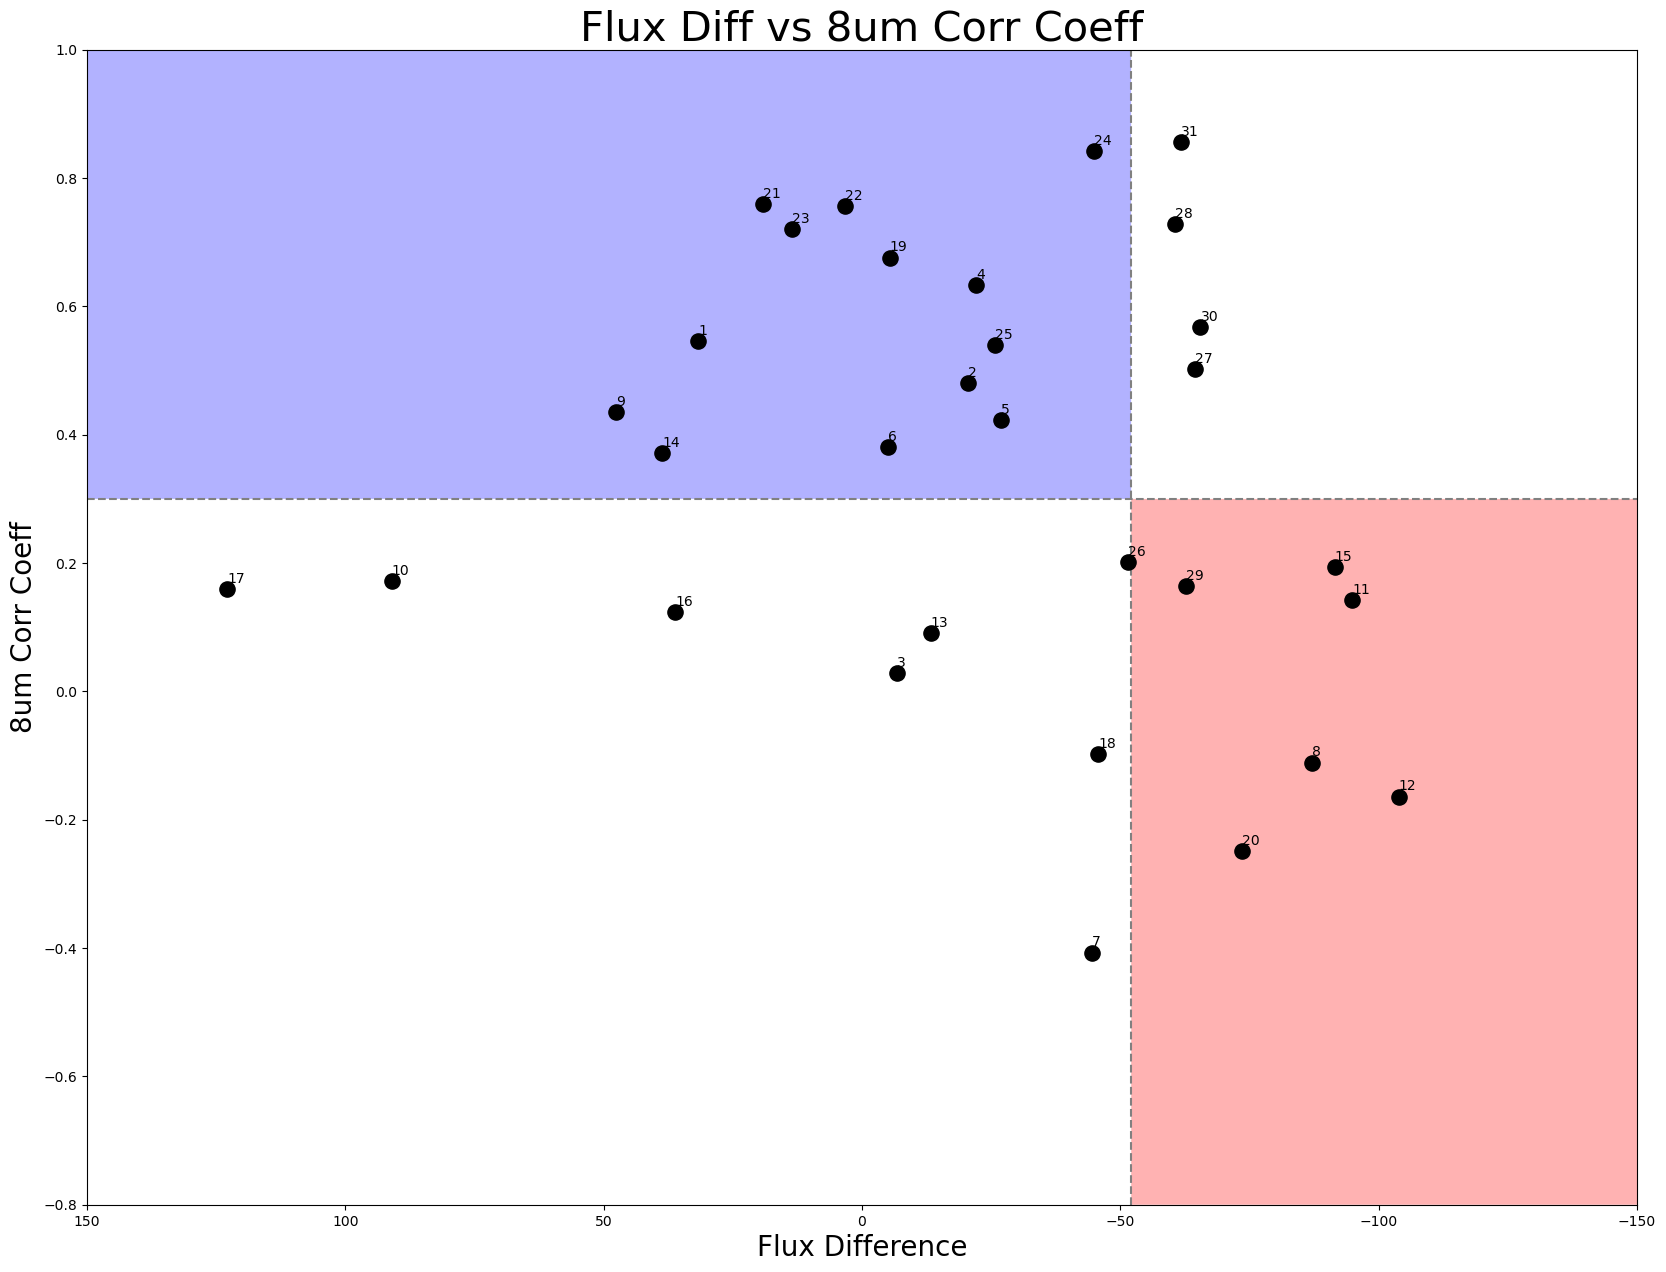

In [11]:
cat = pd.read_csv('./LBV_plots_stuff/CMZ_cloud_catalogue_data.csv')

absorp_tab = Table.read('./LBV_plots_stuff/absorption_comparison_table_Oct22.tex')
absorp_value = absorp_tab['fraction_value']
absorp_13co = absorp_tab['co_h2co_ratio']
absorp_index = absorp_tab['leaf_id']

flux_frac_tab = Table.read('./paper_figs/Tables/CMZ_cat_flux_method_vals.tex')
flux_frac_value = flux_frac_tab['Extinction Fraction']
flux_frac_index = flux_frac_tab['leaf id']
flux_diff = flux_frac_tab['Flux Difference'] 
flux_ratio_fore = flux_frac_tab['Flux Ratio']
min_flux = flux_frac_tab['Min Flux'] #Min flux from RAW spitzer image

corr_coeff_id = corr_coeff_table['coeff_leaf_ids']
corr_coeff_f05_all = corr_coeff_table['p_f05_all']


fore = 52.09
flux_ratio_center = 0.699

####FLUX DIFF vs FLUX RATIO###
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20,15))


for i in range(0,len(corr_coeff_table['coeff_leaf_ids'])):
    if corr_coeff_id[i] in cat['index']:
        sc = plt.scatter(flux_diff[np.where(flux_frac_index==corr_coeff_id[i])[0]], corr_coeff_f05_all[i], 
                         marker='o', c='k',s=120, edgecolor='k', zorder=3)
        plt.annotate(corr_coeff_id[i],(flux_diff[np.where(flux_frac_index==corr_coeff_id[i])[0]], corr_coeff_f05_all[i] + 0.01))



ax.invert_xaxis()
ax.axvline(x = -fore, linestyle ='--', color = 'grey' )
ax.axhline(y = 0.3,linestyle ='--', color = 'grey' ) #using 0.3 as the threshold for corr coeff


near_range = np.arange(-fore,150,.1)
far_range = np.arange(-150,-fore , 0.1)
ax.fill_between(near_range, 0.3 ,1.0, facecolor = 'blue', alpha=0.3)
ax.fill_between(far_range ,-0.8,0.3, facecolor = 'red', alpha=0.3)

plt.title("Flux Diff vs 8um Corr Coeff", fontsize=30)
ax.set_xlabel('Flux Difference', fontsize=20)
ax.set_ylabel('8um Corr Coeff', fontsize=20)
plt.xlim(150,-150)
plt.ylim(-0.8,1.0)

#plt.savefig('8um_corr_coeff_vs_flux_diff_updated.png')


plt.show()

# COMBINED PLOTS

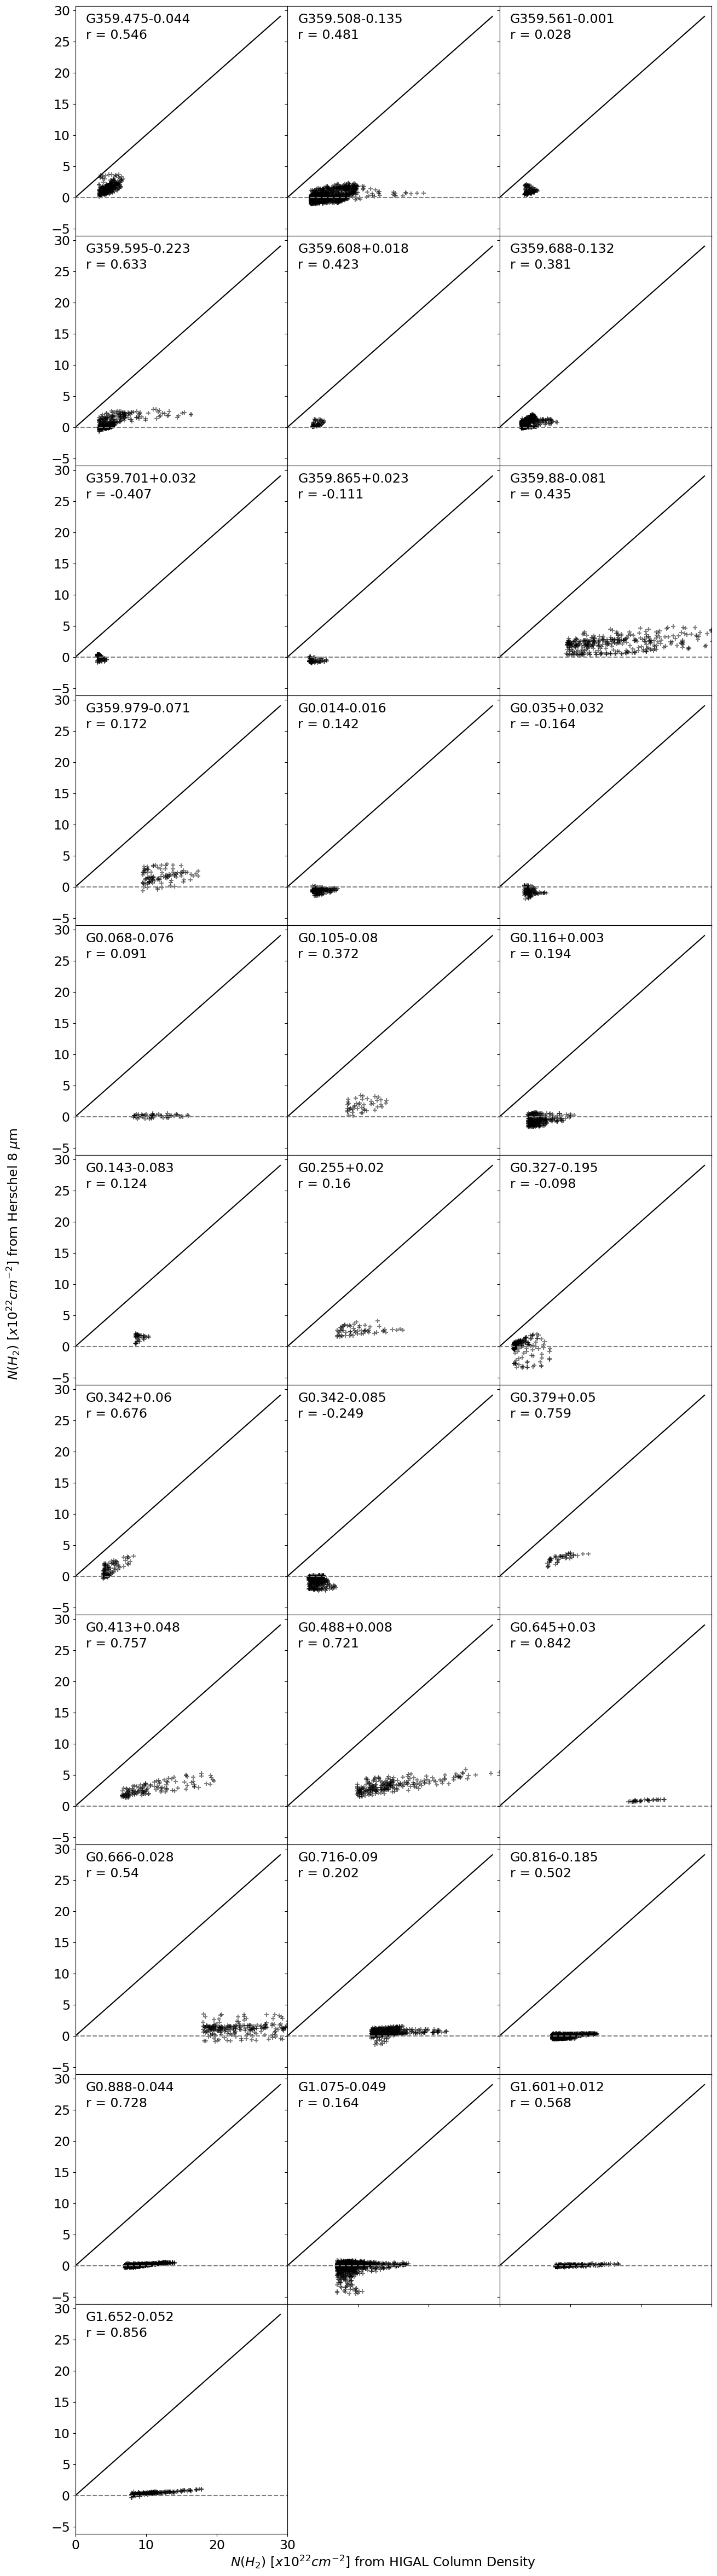

In [19]:
###ALL PLOTS####

plot_cloud_list = [ ["G359.475-0.044", "G359.508-0.135", "G359.561-0.001"], 
                   ["G359.595-0.223","G359.608+0.018", "G359.688-0.132"], 
                   ["G359.701+0.032", "G359.865+0.023", "G359.88-0.081"],
                   ["G359.979-0.071", "G0.014-0.016","G0.035+0.032" ], 
                   ["G0.068-0.076", "G0.105-0.08", "G0.116+0.003" ], 
                   ["G0.143-0.083", "G0.255+0.02", "G0.327-0.195"],
                   ["G0.342+0.06",  "G0.342-0.085", "G0.379+0.05" ], 
                   ["G0.413+0.048", "G0.488+0.008", "G0.645+0.03"],
                   ["G0.666-0.028", "G0.716-0.09", "G0.816-0.185" ], 
                   ["G0.888-0.044", "G1.075-0.049" ,"G1.601+0.012"],  
                   ["G1.652-0.052" ,"G1.652-0.052" ,"G1.652-0.052" ]]

corr_coeff_table = Table.read('./corr_coeff_table_8um.tex')
corr_coeff_id = corr_coeff_table['coeff leaf ids']
corr_coeff_f05_all = corr_coeff_table['p f05 all']
corr_coeff_f05_thin = corr_coeff_table['p f05 thin']
corr_coeff_cloud = corr_coeff_table['cloud list works']

f_fore=0.5

fig, ax = plt.subplots(11, 3, sharex=True, sharey=True, figsize = (15,60))
fig.delaxes(ax[10,1])
fig.delaxes(ax[10,2])
plt.subplots_adjust(wspace=0, hspace=0)
plt.xlim(0,30)

#plt.xlabel(r"$N(H_{2})$ [$x10^{22} cm^{-2}$] from Hi-GAL")
#plt.ylabel(r"$N(H_{2})$ [$x10^{22} cm^{-2}$] from Herschel 70 $\mu$m regridded")

for i in range(11):
    for j in range(3):
        
        ext_list_8_conv = []
        em_list_8_conv = []



        regrid_to_nans_file = './Cloud_masks/{}/{}_ExtN8um_ffore{:.2f}_cutout_smoothed_conv36_regrid_isolated.fits'.format(plot_cloud_list[i][j], plot_cloud_list[i][j], f_fore)

        regrid_to_nans_data = pyfits.open(regrid_to_nans_file)[0].data

        cloud_hers = './Cloud_masks/{}/{}_herschel_cutout_isolated.fits'.format(plot_cloud_list[i][j],plot_cloud_list[i][j])
        cloud_hers_data = pyfits.open(cloud_hers)[0].data

        wcs = WCS(pyfits.open(regrid_to_nans_file)[0].header)

        em_list_8_conv.append(np.nanmedian(cloud_hers_data)/10**22)
        ext_list_8_conv.append(np.nanmedian(regrid_to_nans_data)/10**22)



        plt.rcParams.update({'font.size': 17})
        

        x = np.arange(-1,30)
        y = np.arange(-1,30)

        thin_pts = np.where(regrid_to_nans_data/10**22<1.8)
        thick_pts = np.where(regrid_to_nans_data/10**22>=1.8)

        ax[i,j].scatter(cloud_hers_data[thin_pts]/1E22,regrid_to_nans_data[thin_pts]/1E22, 
                marker='+', color = 'k', alpha=0.5, label = "f_fore={} thin".format(f_fore))

        ax[i,j].scatter(cloud_hers_data[thick_pts]/1E22,regrid_to_nans_data[thick_pts]/1E22, 
                marker='+', color = 'k', alpha=0.5, label = "f_fore={} thick".format(f_fore))




        ax[i,j].plot(x,y, c='black')
        ax[i,j].hlines(0,-1, 30, linestyle='--', color='gray')
        #ax[i,j].hlines(1.8,-1, 30, linestyle='--', color='red', label = "8um tau=1")

        #plt.legend(loc=2)
        ax[i,j].text(.05, .97, '{}'.format(plot_cloud_list[i][j]), ha='left', va='top', transform=ax[i,j].transAxes)
        ax[i,j].text(.05, .90, 'r = {}'.format(corr_coeff_f05_all[np.where(corr_coeff_cloud==plot_cloud_list[i][j])][0]), ha='left', va='top', transform=ax[i,j].transAxes)
        #ax[i,j].text(.05, .83, 'r_thin = {}'.format(corr_coeff_f05_thin[np.where(corr_coeff_cloud==plot_cloud_list[i][j])][0]), ha='left', va='top', transform=ax[i,j].transAxes)

fig.text(0.5, 0.1, r"$N(H_{2})$ [$x10^{22} cm^{-2}$] from HIGAL Column Density", ha='center')
fig.text(0.04, 0.5, r"$N(H_{2})$ [$x10^{22} cm^{-2}$] from Herschel 8 $\mu$m", va='center', rotation='vertical')


plt.savefig('./paper_figs/Figs/8um_corr_coeff_ALL.png')

In [13]:
plot_cloud_id = np.arange(1,37,1)
plot_cloud_id = np.reshape(plot_cloud_id,(6,6))

plot_cloud_id

array([[ 1,  2,  3,  4,  5,  6],
       [ 7,  8,  9, 10, 11, 12],
       [13, 14, 15, 16, 17, 18],
       [19, 20, 21, 22, 23, 24],
       [25, 26, 27, 28, 29, 30],
       [31, 32, 33, 34, 35, 36]])

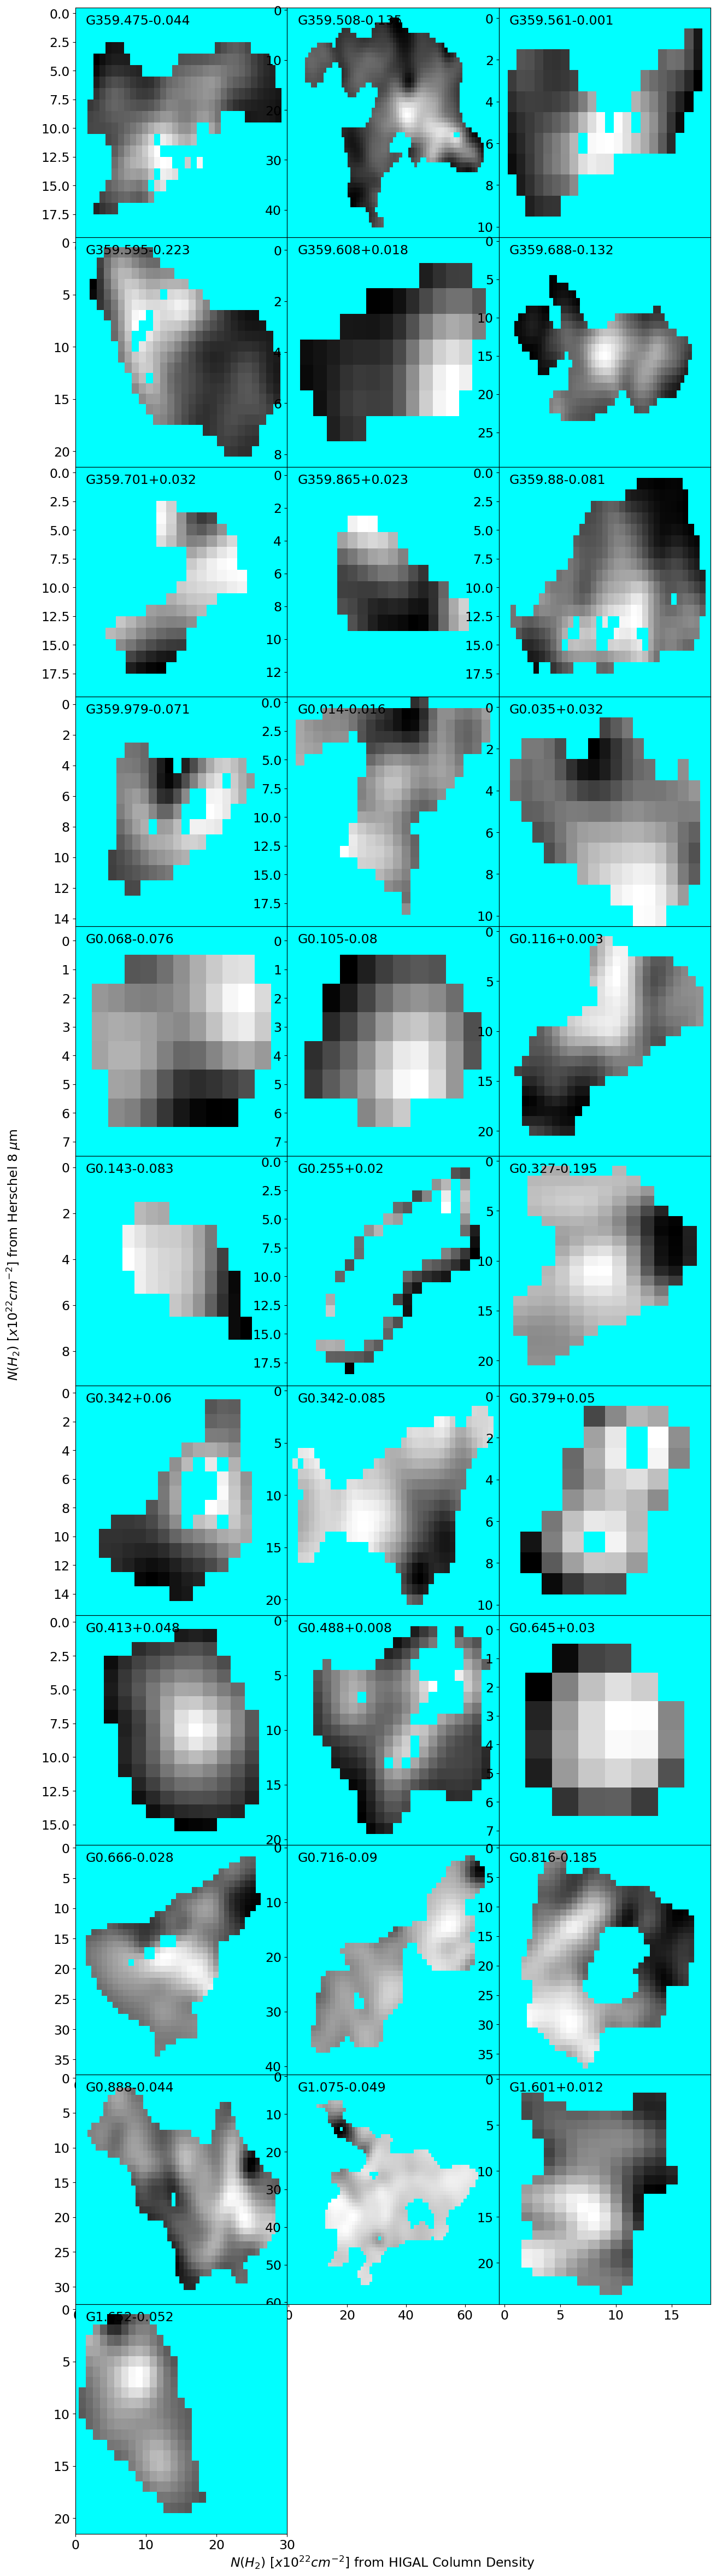

In [20]:
###ALL PLOTS####

plot_cloud_list = [ ["G359.475-0.044", "G359.508-0.135", "G359.561-0.001"], 
                   ["G359.595-0.223","G359.608+0.018", "G359.688-0.132"], 
                   ["G359.701+0.032", "G359.865+0.023", "G359.88-0.081"],
                   ["G359.979-0.071", "G0.014-0.016","G0.035+0.032" ], 
                   ["G0.068-0.076", "G0.105-0.08", "G0.116+0.003" ], 
                   ["G0.143-0.083", "G0.255+0.02", "G0.327-0.195"],
                   ["G0.342+0.06",  "G0.342-0.085", "G0.379+0.05" ], 
                   ["G0.413+0.048", "G0.488+0.008", "G0.645+0.03"],
                   ["G0.666-0.028", "G0.716-0.09", "G0.816-0.185" ], 
                   ["G0.888-0.044", "G1.075-0.049" ,"G1.601+0.012"],  
                   ["G1.652-0.052" ,"G1.652-0.052" ,"G1.652-0.052" ]]


f_fore=0.5

fig, ax = plt.subplots(11, 3, figsize = (15,60))
fig.delaxes(ax[10,1])
fig.delaxes(ax[10,2])
plt.subplots_adjust(wspace=0, hspace=0)
plt.xlim(0,30)


for i in range(11):
    for j in range(3):
        
 

        regrid_to_nans_file = './Cloud_masks/{}/{}_ExtN8um_ffore{:.2f}_cutout_smoothed_conv36_regrid_isolated.fits'.format(plot_cloud_list[i][j], plot_cloud_list[i][j], f_fore)

        regrid_to_nans_data = pyfits.open(regrid_to_nans_file)[0].data

        cloud_hers = './Cloud_masks/{}/{}_herschel_cutout_isolated.fits'.format(plot_cloud_list[i][j],plot_cloud_list[i][j])
        cloud_hers_data = pyfits.open(cloud_hers)[0].data

        wcs = WCS(pyfits.open(regrid_to_nans_file)[0].header)

        em_list_8_conv.append(np.nanmedian(cloud_hers_data)/10**22)
        ext_list_8_conv.append(np.nanmedian(regrid_to_nans_data)/10**22)



        plt.rcParams.update({'font.size': 17})
    
        ax[i,j].imshow(regrid_to_nans_data, cmap='gist_gray', aspect='auto')
        ax[i,j].set_facecolor('cyan')
        
        #plt.legend(loc=2)
        ax[i,j].text(.05, .97, '{}'.format(plot_cloud_list[i][j]), ha='left', va='top', transform=ax[i,j].transAxes)

fig.text(0.5, 0.1, r"$N(H_{2})$ [$x10^{22} cm^{-2}$] from HIGAL Column Density", ha='center')
fig.text(0.04, 0.5, r"$N(H_{2})$ [$x10^{22} cm^{-2}$] from Herschel 8 $\mu$m", va='center', rotation='vertical')


plt.savefig('./all_clouds_8umExtN.png')

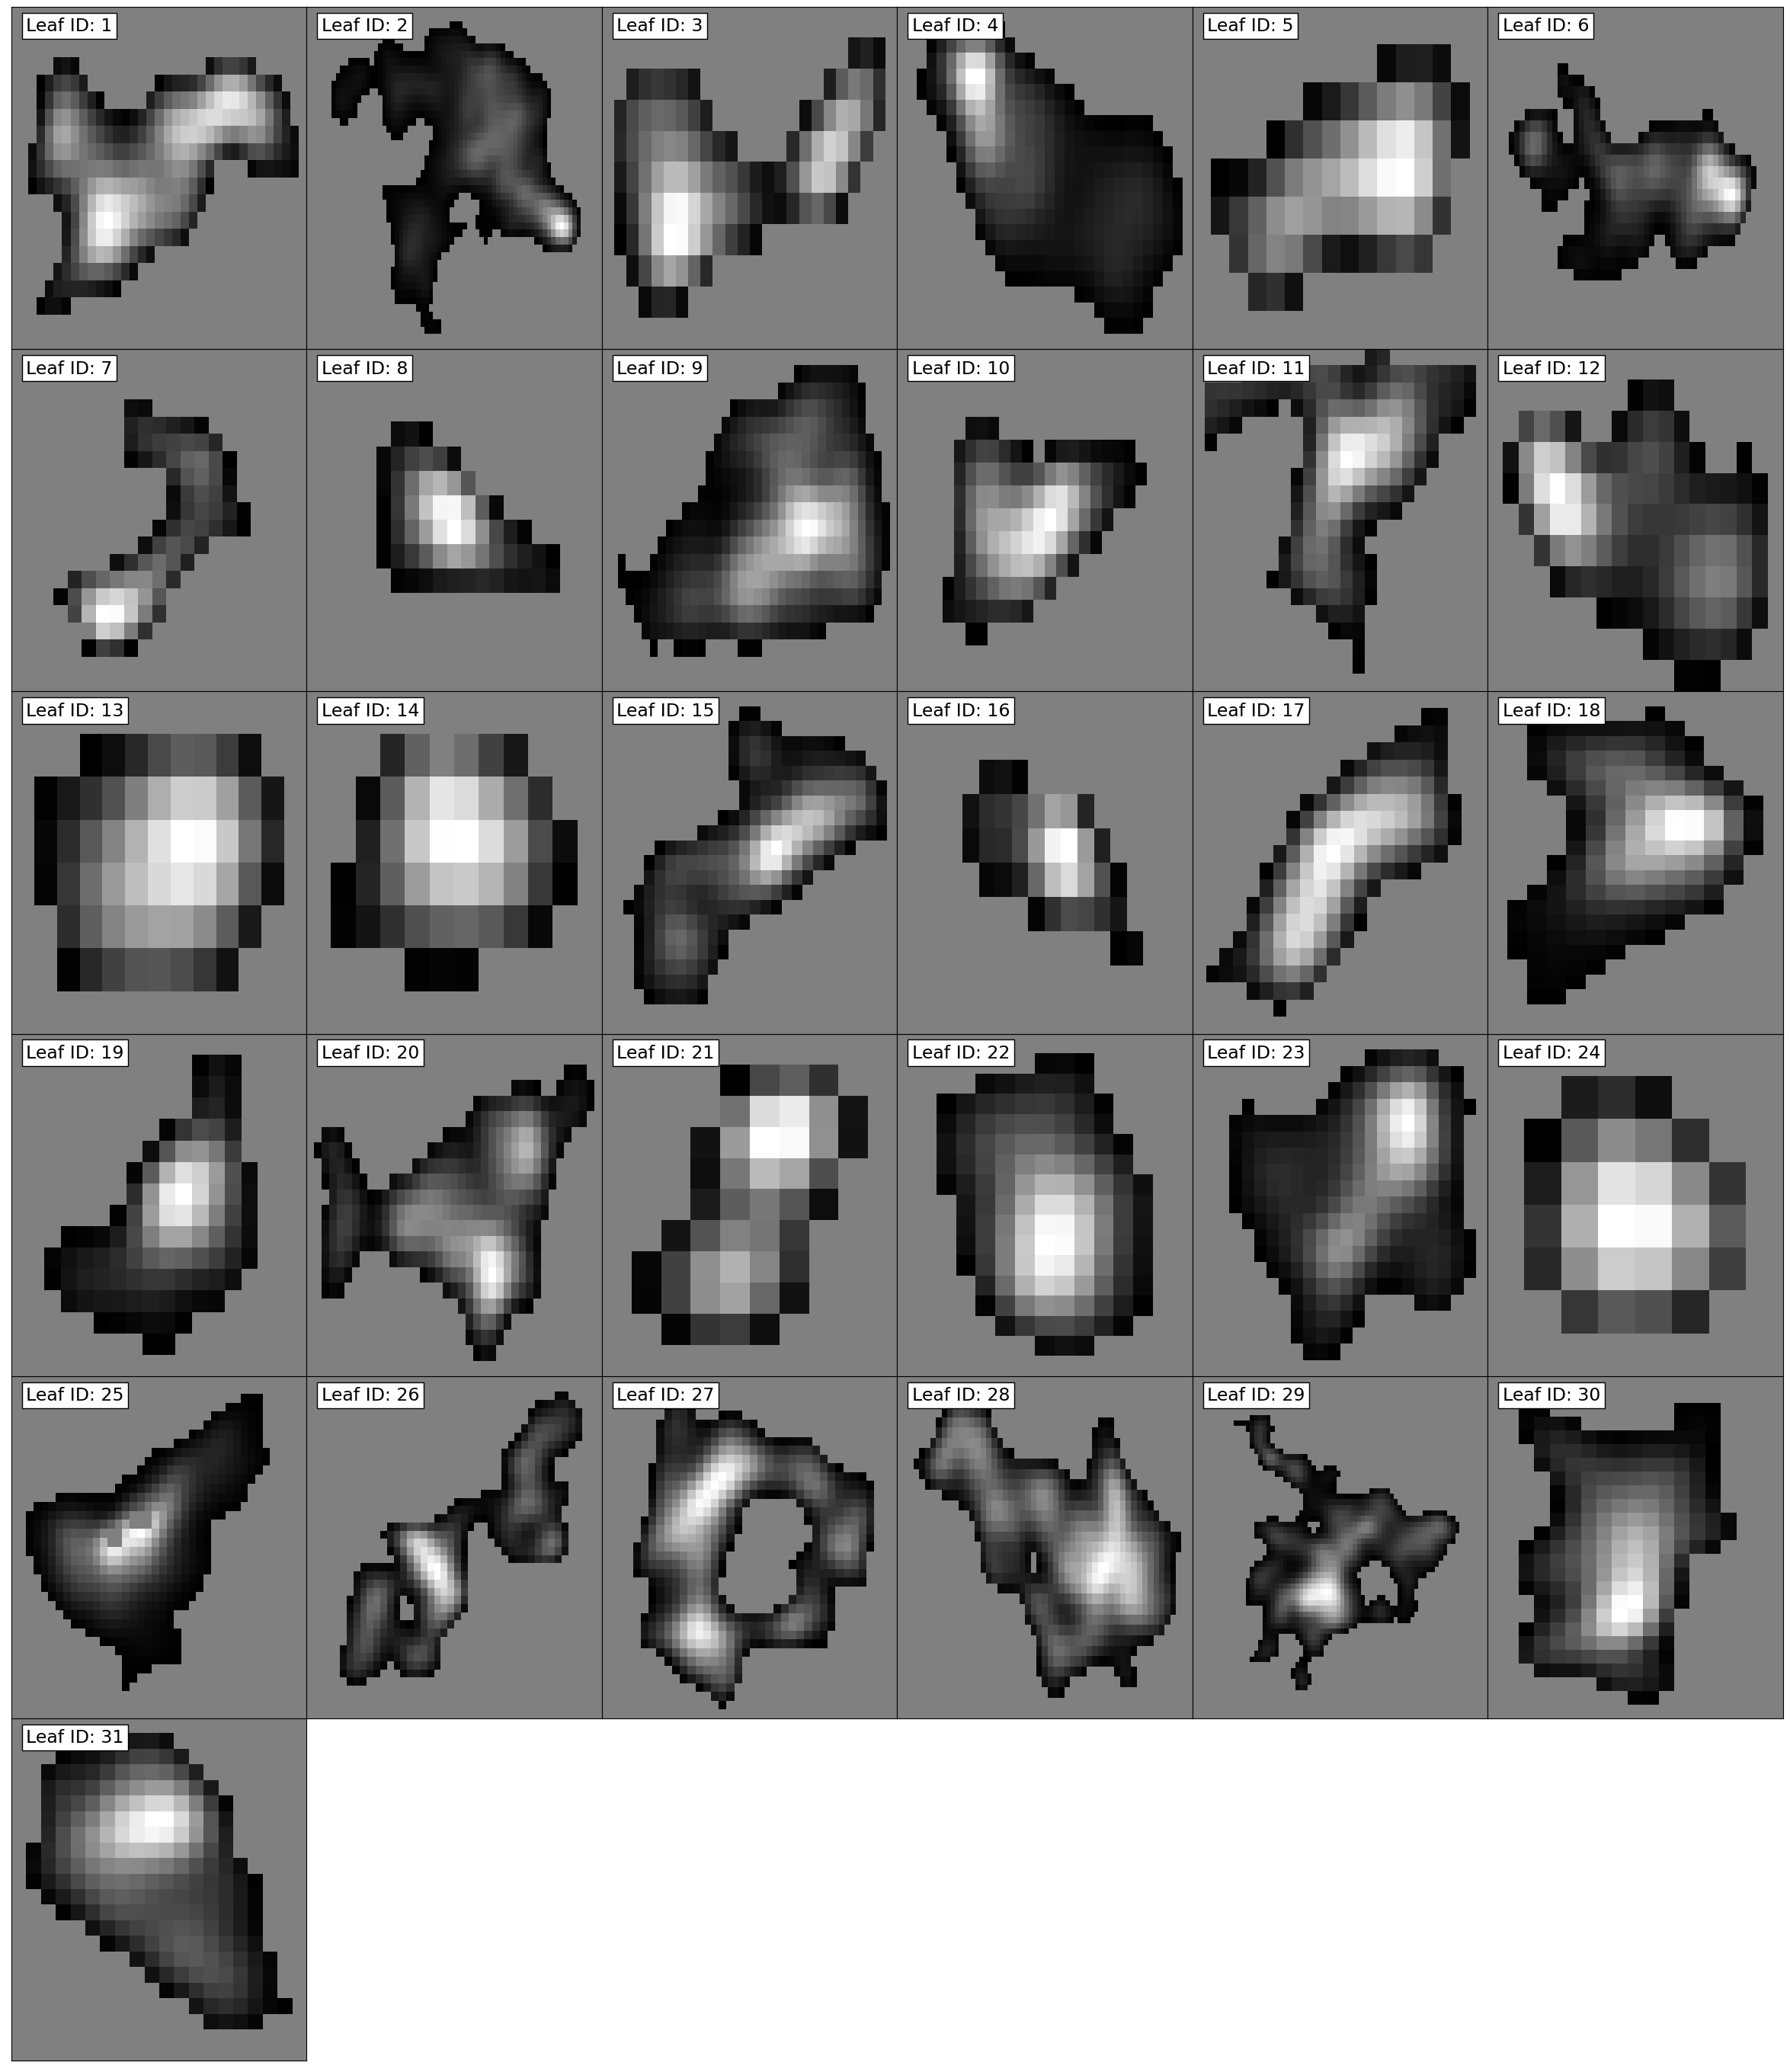

In [47]:
###ALL PLOTS####

plot_cloud_list = [ ["G359.475-0.044", "G359.508-0.135", "G359.561-0.001"], 
                   ["G359.595-0.223","G359.608+0.018", "G359.688-0.132"], 
                   ["G359.701+0.032", "G359.865+0.023", "G359.88-0.081"],
                   ["G359.979-0.071", "G0.014-0.016","G0.035+0.032" ], 
                   ["G0.068-0.076", "G0.105-0.08", "G0.116+0.003" ], 
                   ["G0.143-0.083", "G0.255+0.02", "G0.327-0.195"],
                   ["G0.342+0.06",  "G0.342-0.085", "G0.379+0.05" ], 
                   ["G0.413+0.048", "G0.488+0.008", "G0.645+0.03"],
                   ["G0.666-0.028", "G0.716-0.09", "G0.816-0.185" ], 
                   ["G0.888-0.044", "G1.075-0.049" ,"G1.601+0.012"],  
                   ["G1.652-0.052" ,"G1.652-0.052" ,"G1.652-0.052" ],
                  ["G1.652-0.052" ,"G1.652-0.052" ,"G1.652-0.052"] ]



plot_cloud_list = np.reshape(plot_cloud_list,(6,6))

f_fore=0.5

fig, ax = plt.subplots(6, 6, figsize = (30,35))
fig.delaxes(ax[5,5])
fig.delaxes(ax[5,4])
fig.delaxes(ax[5,3])
fig.delaxes(ax[5,2])
fig.delaxes(ax[5,1])
plt.subplots_adjust(wspace=0, hspace=0)
#plt.xlim(0,30)
#plt.ylim(0,30)

plt.rcParams.update({'font.size': 20})

for i in range(6):
    for j in range(6):
        
 

        regrid_to_nans_file = './Cloud_masks/{}/{}_ExtN8um_ffore{:.2f}_cutout_smoothed_conv36_regrid_isolated.fits'.format(plot_cloud_list[i][j], plot_cloud_list[i][j], f_fore)

        regrid_to_nans_data = pyfits.open(regrid_to_nans_file)[0].data

        cloud_hers = './Cloud_masks/{}/{}_herschel_cutout_isolated.fits'.format(plot_cloud_list[i][j],plot_cloud_list[i][j])
        cloud_hers_data = pyfits.open(cloud_hers)[0].data

        wcs = WCS(pyfits.open(regrid_to_nans_file)[0].header)

        em_list_8_conv.append(np.nanmedian(cloud_hers_data)/10**22)
        ext_list_8_conv.append(np.nanmedian(regrid_to_nans_data)/10**22)



        plt.rcParams.update({'font.size': 17})
    
        ax[i,j].imshow(cloud_hers_data, cmap='gist_gray', aspect='auto')
        ax[i,j].set_facecolor('gray')
        
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
        
        #plt.legend(loc=2)
        ax[i,j].text(.05, .97, 'Leaf ID: {}'.format(plot_cloud_id[i][j]), ha='left', va='top', transform=ax[i,j].transAxes, bbox=dict(facecolor='white', edgecolor='k', alpha=1))




plt.savefig('./all_clouds_herschel.png')

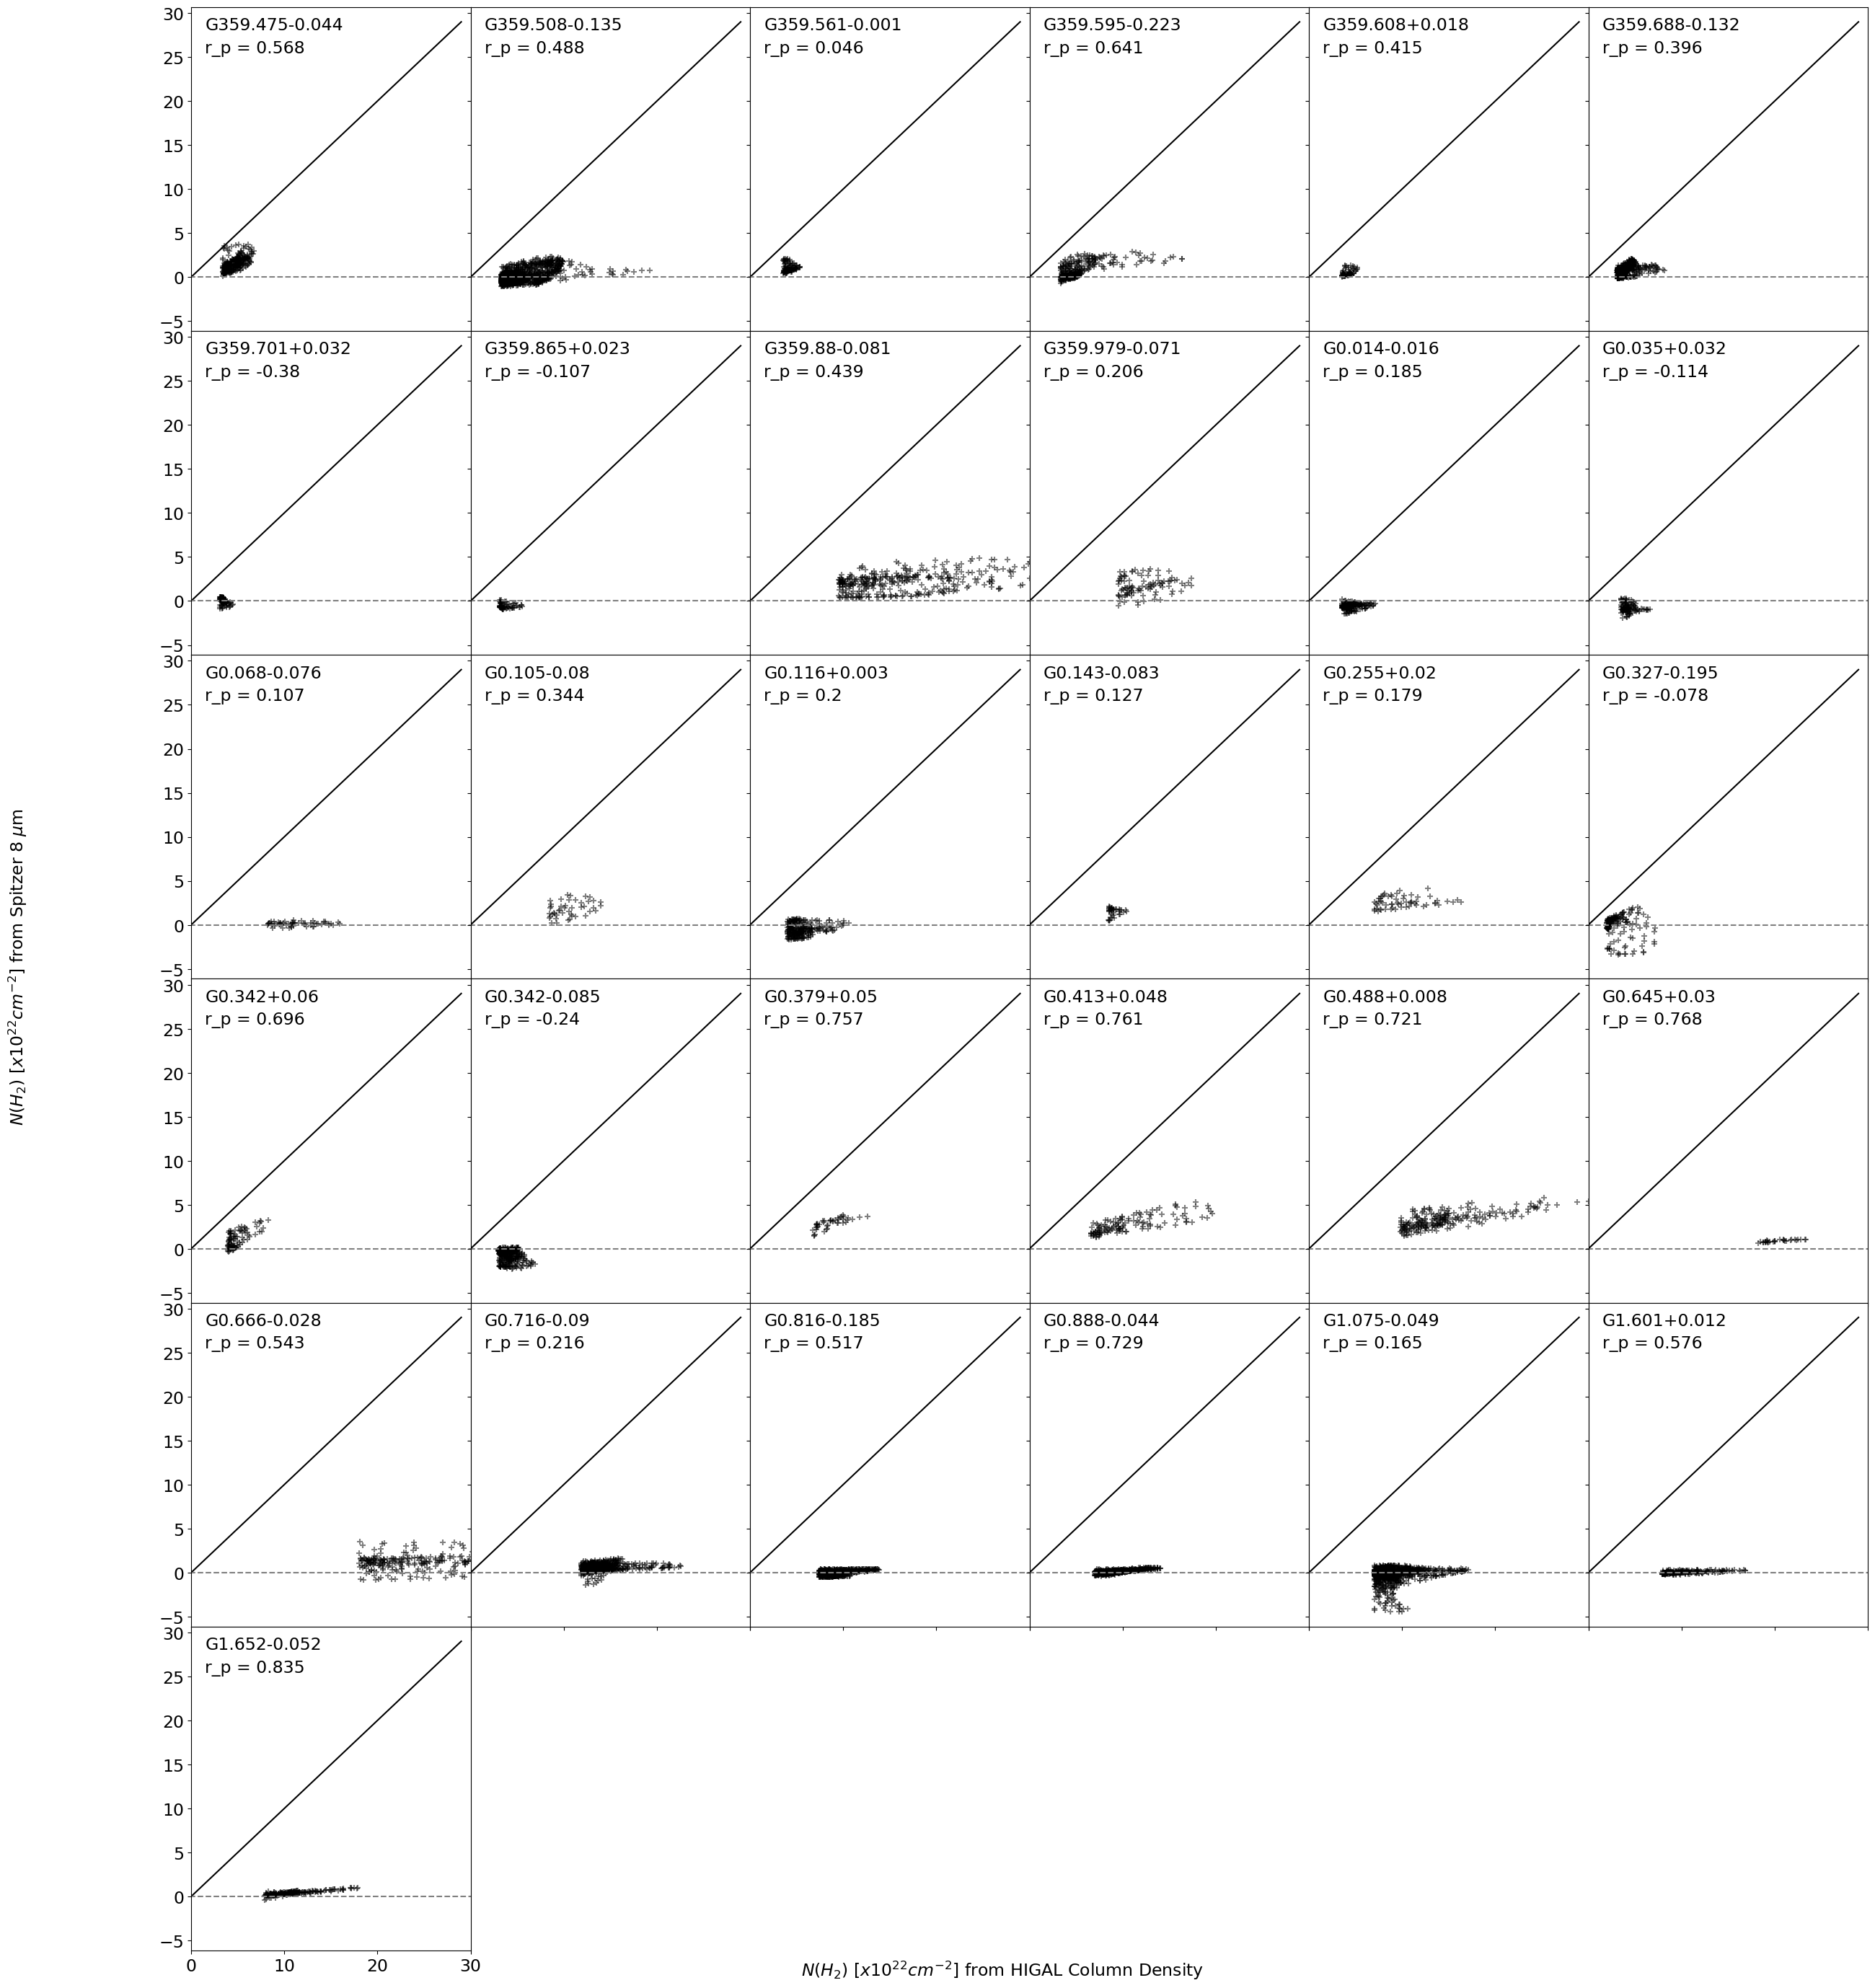

In [56]:
###Plot all correlations###

###ALL PLOTS####


plot_cloud_list = ["G359.475-0.044", "G359.508-0.135", "G359.561-0.001", "G359.595-0.223","G359.608+0.018",
              "G359.688-0.132", "G359.701+0.032", "G359.865+0.023", "G359.88-0.081", "G359.979-0.071",
              "G0.014-0.016","G0.035+0.032", "G0.068-0.076", "G0.105-0.08", "G0.116+0.003", "G0.143-0.083",
              "G0.255+0.02", "G0.327-0.195", "G0.342+0.06",  "G0.342-0.085", "G0.379+0.05", "G0.413+0.048", 
              "G0.488+0.008", "G0.645+0.03",  "G0.666-0.028", "G0.716-0.09", "G0.816-0.185" , "G0.888-0.044",
              "G1.075-0.049" ,
              "G1.601+0.012", "G1.652-0.052" ,"G1.652-0.052"  ,"G1.652-0.052"  ,"G1.652-0.052" ,"G1.652-0.052"  ,"G1.652-0.052" ]

plot_cloud_list = np.reshape(plot_cloud_list,(6,6))

corr_coeff_table = Table.read('./corr_coeff_table_8um.tex')
corr_coeff_id = corr_coeff_table['coeff leaf ids']
corr_coeff_f05_all = corr_coeff_table['p f05 all']
corr_coeff_cloud = corr_coeff_table['cloud list works']

f_fore=0.50

fig, ax = plt.subplots(6, 6, sharex=True, sharey=True, figsize = (30,35))
fig.delaxes(ax[5,5])
fig.delaxes(ax[5,4])
fig.delaxes(ax[5,3])
fig.delaxes(ax[5,2])
fig.delaxes(ax[5,1])
plt.subplots_adjust(wspace=0, hspace=0)
plt.xlim(0,30)

#plt.xlabel(r"$N(H_{2})$ [$x10^{22} cm^{-2}$] from Hi-GAL")
#plt.ylabel(r"$N(H_{2})$ [$x10^{22} cm^{-2}$] from Herschel 70 $\mu$m regridded")

for i in range(6):
    for j in range(6):



        regrid_to_nans_file = './Cloud_masks/{}/{}_ExtN8um_ffore{:.2f}_cutout_smoothed_conv36_regrid_isolated.fits'.format(plot_cloud_list[i][j], plot_cloud_list[i][j], f_fore)

        regrid_to_nans_data = pyfits.open(regrid_to_nans_file)[0].data

        cloud_hers = './Cloud_masks/{}/{}_herschel_cutout_isolated.fits'.format(plot_cloud_list[i][j],plot_cloud_list[i][j])
        cloud_hers_data = pyfits.open(cloud_hers)[0].data

        wcs = WCS(pyfits.open(regrid_to_nans_file)[0].header)



        plt.rcParams.update({'font.size': 17})
        

        x = np.arange(-1,30)
        y = np.arange(-1,30)


        ax[i,j].scatter(cloud_hers_data/1E22,regrid_to_nans_data/1E22, 
                marker='+', color = 'k', alpha=0.5, label = "f_fore={}".format(f_fore))





        ax[i,j].plot(x,y, c='black')
        ax[i,j].hlines(0,-1, 30, linestyle='--', color='gray')


        ax[i,j].text(.05, .97, '{}'.format(plot_cloud_list[i][j]), ha='left', va='top', transform=ax[i,j].transAxes)
        ax[i,j].text(.05, .90, 'r_p = {}'.format(corr_coeff_f05_all[np.where(corr_coeff_cloud==plot_cloud_list[i][j])][0]), ha='left', va='top', transform=ax[i,j].transAxes)

fig.text(0.5, 0.1, r"$N(H_{2})$ [$x10^{22} cm^{-2}$] from HIGAL Column Density", ha='center')
fig.text(0.04, 0.5, r"$N(H_{2})$ [$x10^{22} cm^{-2}$] from Spitzer 8 $\mu$m", va='center', rotation='vertical')


plt.savefig('./paper_figs/Figs/8um_r_p_mom0_corr_coeff_ALL.pdf')

# Foreground Fraction Calculations for clouds with approx distances

In [11]:
#Examples from Battersby 2010

gal_arr = np.arange(0,16,0.0001) #array from sun to 16kpc
ex_arr = np.arange(0,3.6,0.0001) 

gal_dist_ex = np.sum(disk_dist(gal_arr,1,22.35))
ex_dist = np.sum(disk_dist(ex_arr,1,22.35))

print("ex f_fore = ", ex_dist/gal_dist_ex)



ex f_fore =  0.1390151151447517


In [34]:
#Make linspaces of d values from 0 to brick, and from 0 to 16kpc. 
#sum up along those arrays, then divide them for the foreground fraction

gal_arr = np.arange(0,16,0.001)
brick_arr = np.arange(0,8.2-0.17,0.001)
sailfish_arr = np.arange(0,8.2+0.064,0.001)

gal_dist_brick = np.sum(disk_dist(gal_arr,1,0.225))
brick_dist = np.sum(disk_dist(brick_arr,1,0.225))

sailfish_dist = np.sum(disk_dist(sailfish_arr,1,0.342))
gal_dist_sailfish = np.sum(disk_dist(gal_arr,1,0.342))


print("brick f_fore = ", brick_dist/gal_dist_brick)
print("sailfish f_fore = ", sailfish_dist/gal_dist_sailfish)

brick f_fore =  0.4506276051108231
sailfish f_fore =  0.4853270444965334


In [13]:
np.arange(0.2,0.9, 0.05)


array([0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 , 0.65, 0.7 ,
       0.75, 0.8 , 0.85])

# CAN YOU SEE A DIFFERENCE BETWEEN FFORE?

/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_24489/3066601015.py:19: RuntimeWarning: invalid value encountered in log
  return (-1./k_v) * np.log(  ((s+1)*I_1_obs - (s+1)*f_fore*I_0_obs) / ( (1-f_fore)*I_0_obs  ) ) #g/cm^2???


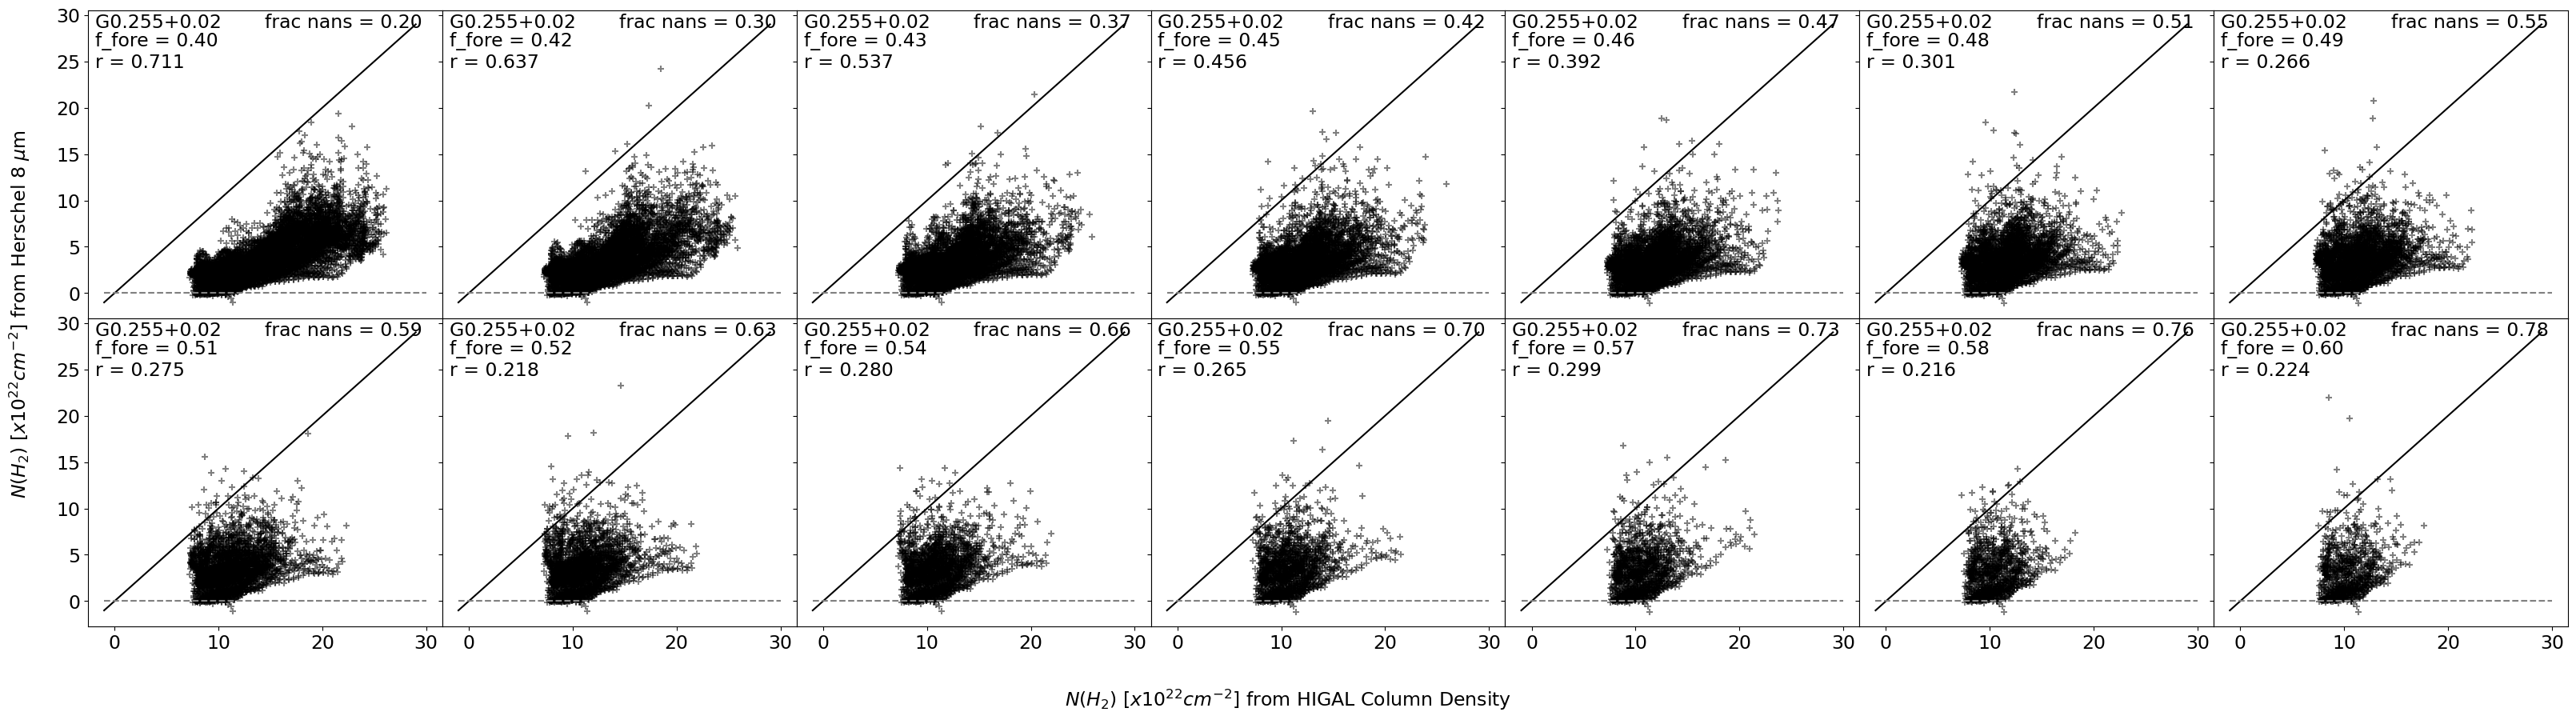

In [14]:
cloud = "G0.255+0.02"
#f_fore_matrix = np.arange(0.2,0.9, 0.05)
f_fore_matrix=np.linspace(0.4,0.6,14)
f_fore_matrix.resize((2,7))

fig, ax = plt.subplots(2, 7, sharex=True, sharey=True, figsize = (40,10))
plt.subplots_adjust(wspace=0, hspace=0)

for i in range(2):
    for j in range(7):

        ext_list = []
        em_list = []
        
        ###Import Files###

        #Herscehl 8um
        cloud_herschel_regrid_fits = pyfits.open('./Cloud_masks/{}/{}_herschel_cutout_isolated_regrid_to_spitzer.fits'.format(cloud, cloud))

        cloud_8um_fits = pyfits.open('./Cloud_masks/{}/{}_spitzer_cutout_isolated.fits'.format(cloud, cloud))
        cloud_8um_smoothed_fits = pyfits.open('./Cloud_masks/{}/{}_smoothed_cutout_isolated.fits'.format(cloud, cloud))

        # copy the FITS data into a numpy array
        cloud_8um = cloud_8um_fits[0].data
        cloud_8um_smoothed = cloud_8um_smoothed_fits[0].data
        cloud_hers_regrid = cloud_herschel_regrid_fits[0].data


        h_cloud_8um = pyfits.getheader('./Cloud_masks/{}/{}_herschel_cutout_isolated_regrid_to_spitzer.fits'.format(cloud, cloud))

        #Get the avg column density from herschel
        cloud_avg_hers= np.nanmean(cloud_hers_regrid) #finds average ignoring nans

        #Calculate a 2D array for the whole cloud#
        cloud_ext_N = cloud_extinction_calc_8um(cloud_hers_regrid, f_fore_matrix[i,j], cloud_8um_smoothed, cloud_8um)

        em_list.append(np.nanmedian(cloud_hers_regrid)/10**22)
        ext_list.append(np.nanmedian(cloud_ext_N)/10**22)

        #Calculate correlation coefficient
        xy = pd.DataFrame({'Herschel': cloud_hers_regrid.flatten(), 'Ext Col Den': cloud_ext_N.flatten()})
        corr_coeff = xy['Herschel'].corr(xy['Ext Col Den'], method='pearson')
        
        #find the fraction of pixels that are now nans
        num_ExtN_notnans = len(np.where(np.isnan(cloud_ext_N).flatten()==False)[0])
        num_smoothed_notnans = len(np.where(np.isnan(cloud_8um_smoothed).flatten()==False)[0])
        frac_nans = 1- (num_ExtN_notnans/num_smoothed_notnans)
        

        #Make plot similar to Fig 3 in Battersby 2010
        x = np.arange(-1,30)
        y = np.arange(-1,30)

        ax[i,j].scatter(cloud_hers_regrid/10**22,cloud_ext_N/10**22, marker='+', color = 'k', alpha=0.5)
        ax[i,j].plot(x,y, c='black')
        ax[i,j].hlines(0,-1, 30, linestyle='--', color='gray')


        ax[i,j].text(.02, .99, '{}  '.format(cloud), ha='left', va='top', transform=ax[i,j].transAxes)
        ax[i,j].text(.02, .93, 'f_fore = {:.2f}'.format(f_fore_matrix[i,j]), ha='left', va='top', transform=ax[i,j].transAxes)
        ax[i,j].text(.02, .86, 'r = {:.3f}'.format(corr_coeff), ha='left', va='top', transform=ax[i,j].transAxes)

        ax[i,j].text(.5, .99, 'frac nans = {:.2f}'.format(frac_nans), ha='left', va='top', transform=ax[i,j].transAxes)

fig.text(0.5, 0.01, r"$N(H_{2})$ [$x10^{22} cm^{-2}$] from HIGAL Column Density", ha='center')
fig.text(0.1, 0.5, r"$N(H_{2})$ [$x10^{22} cm^{-2}$] from Herschel 8 $\mu$m", va='center', rotation='vertical')

plt.savefig("./{}_8um_ExtN_different_ffore.png".format(cloud))

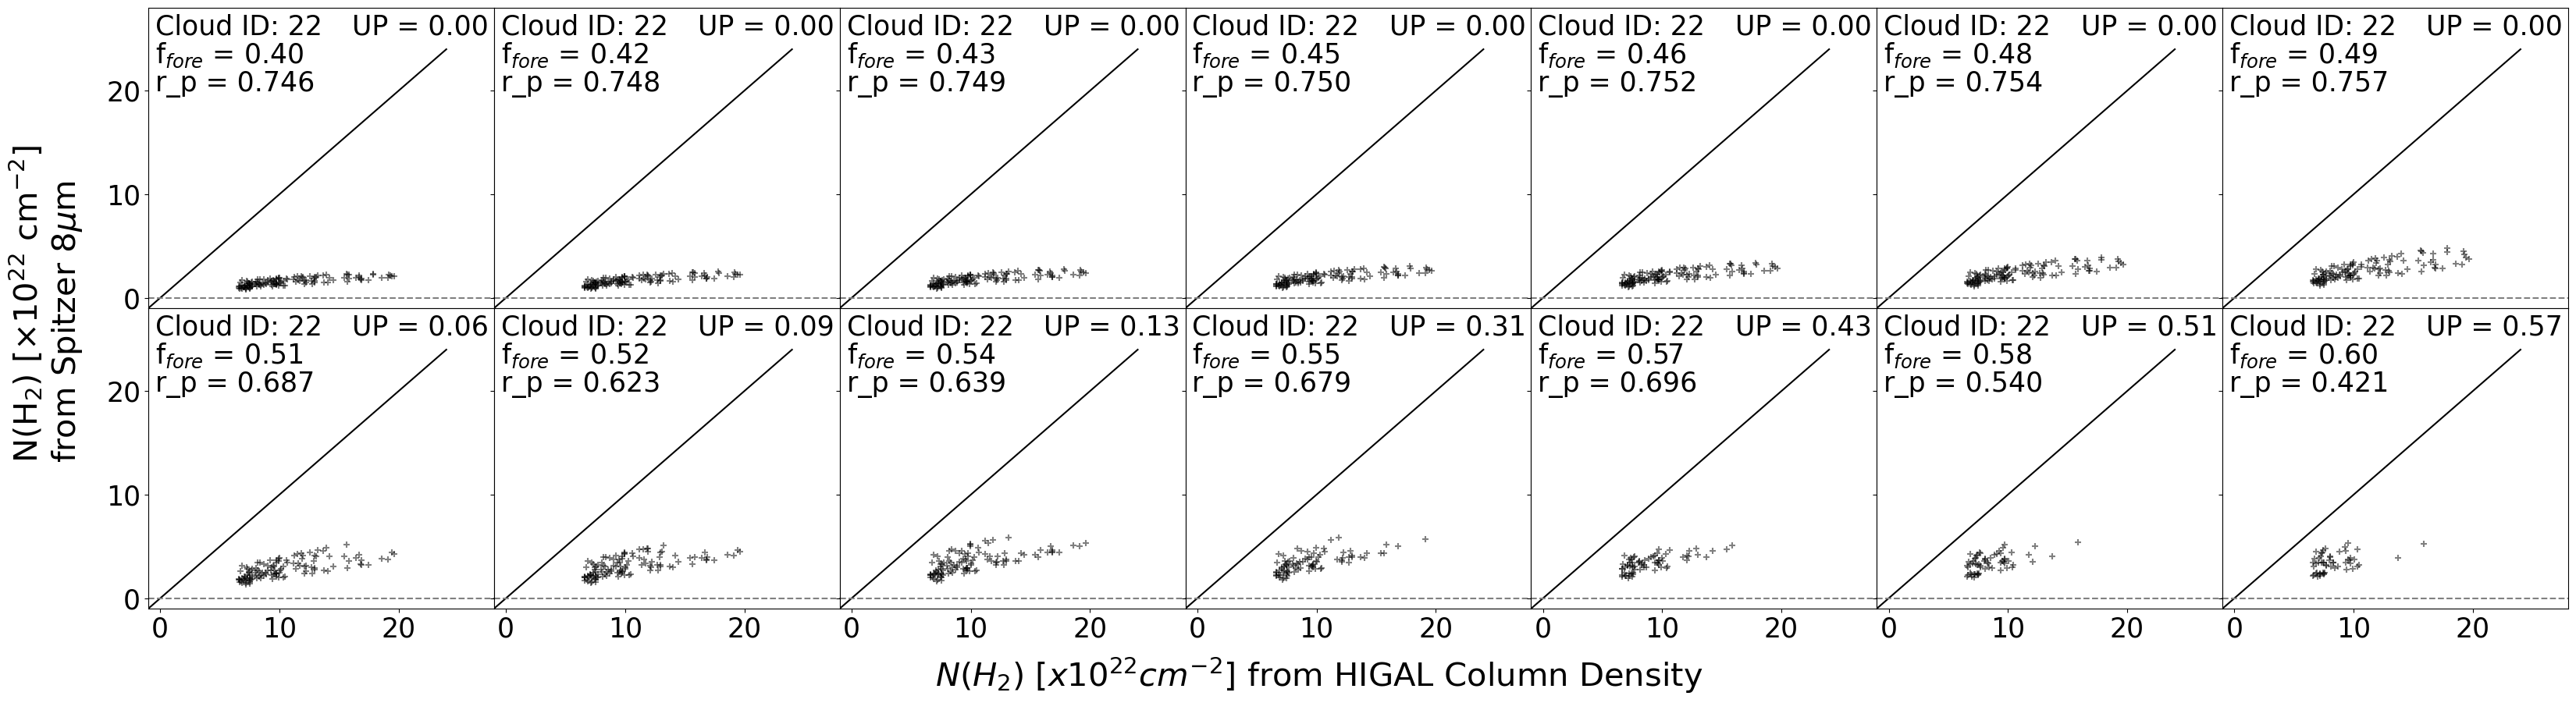

In [36]:
#cloud = "G0.255+0.02"
cloud_id = 17
cloud = "G0.255+0.02"

cloud_id = 22
cloud = "G0.413+0.048"
#f_fore_matrix = np.arange(0.2,0.9, 0.05)
f_fore_matrix = np.linspace(0.4,0.6, 14)
f_fore_matrix.resize((2,7))

fig, ax = plt.subplots(2, 7, sharex=True, sharey=True, figsize = (40,10))
plt.subplots_adjust(wspace=0, hspace=0)

for i in range(2):
    for j in range(7):
        ext_list_8_conv = []
        em_list_8_conv = []



        regrid_to_nans_file = './Cloud_masks/{}/{}_ExtN8um_ffore{:.2f}_cutout_smoothed_conv36_regrid_isolated.fits'.format(cloud, cloud, f_fore_matrix[i,j])

        regrid_to_nans_data = pyfits.open(regrid_to_nans_file)[0].data

        cloud_hers = './Cloud_masks/{}/{}_herschel_cutout_isolated.fits'.format(cloud,cloud)
        cloud_hers_data = pyfits.open(cloud_hers)[0].data

        wcs = WCS(pyfits.open(regrid_to_nans_file)[0].header)

        em_list_8_conv.append(np.nanmedian(cloud_hers_data)/10**22)
        ext_list_8_conv.append(np.nanmedian(regrid_to_nans_data)/10**22)



        plt.rcParams.update({'font.size': 17})
        

        x = np.arange(-1,25)
        y = np.arange(-1,25)

        #Calculate correlation coefficient
        xy = pd.DataFrame({'Herschel': cloud_hers_data.flatten(), 'Ext Col Den': regrid_to_nans_data.flatten()})
        corr_coeff_p = xy['Herschel'].corr(xy['Ext Col Den'], method='pearson')
        corr_coeff_s = xy['Herschel'].corr(xy['Ext Col Den'], method='spearman')
        
        #find the fraction of pixels that are now nans
        num_ExtN_notnans = len(np.where(np.isnan(regrid_to_nans_data).flatten()==False)[0])
        num_hers_notnans = len(np.where(np.isnan(cloud_hers_data).flatten()==False)[0])
        frac_nans = 1- (num_ExtN_notnans/num_hers_notnans)
        

        #Make plot similar to Fig 3 in Battersby 2010
        x = np.arange(-1,25)
        y = np.arange(-1,25)

        ax[i,j].scatter(cloud_hers_data/10**22,regrid_to_nans_data/10**22, marker='+', color = 'k', alpha=0.5)
        ax[i,j].plot(x,y, c='black')
        ax[i,j].hlines(0,-1, 30, linestyle='--', color='gray')


        text_font_size = 25
        #ax[i,j].text(.02, .99, '{}  '.format(cloud), ha='left', va='top', transform=ax[i,j].transAxes)
        ax[i,j].text(.02, .98, 'Cloud ID: {}  '.format(cloud_id), fontsize=text_font_size, ha='left', va='top', transform=ax[i,j].transAxes)
        ax[i,j].text(.02, .89, r'f$_{fore}$ =' + ' {:.2f}'.format(f_fore_matrix[i,j]), fontsize=text_font_size, ha='left', va='top', transform=ax[i,j].transAxes)
        ax[i,j].text(.02, .79, 'r_p = {:.3f}'.format(corr_coeff_p), fontsize=text_font_size, ha='left', va='top', transform=ax[i,j].transAxes)
        ax[i,j].text(.59, .98, 'UP = {:.2f}'.format(frac_nans), fontsize=text_font_size, ha='left', va='top', transform=ax[i,j].transAxes)
        ax[i,j].set_ylim(-1,28)
        ax[i,j].set_xlim(-1,28)


        ax[i,j].tick_params(labelsize=25)

fig.text(0.5, 0.01, r"$N(H_{2})$ [$x10^{22} cm^{-2}$] from HIGAL Column Density", fontsize=30,  ha='center')
fig.text(0.08, 0.5, r"N(H$_{2}$) [$\times10^{22}$ cm$^{-2}$]" + "\nfrom Spitzer 8$\mu$m", fontsize= 30, va='center', rotation='vertical')

plt.savefig("./paper_figs/Figs/{}_8um_ExtN_different_ffore_regridded_to_herschel_subset.pdf".format(cloud),bbox_inches='tight')

# Compare to 70um

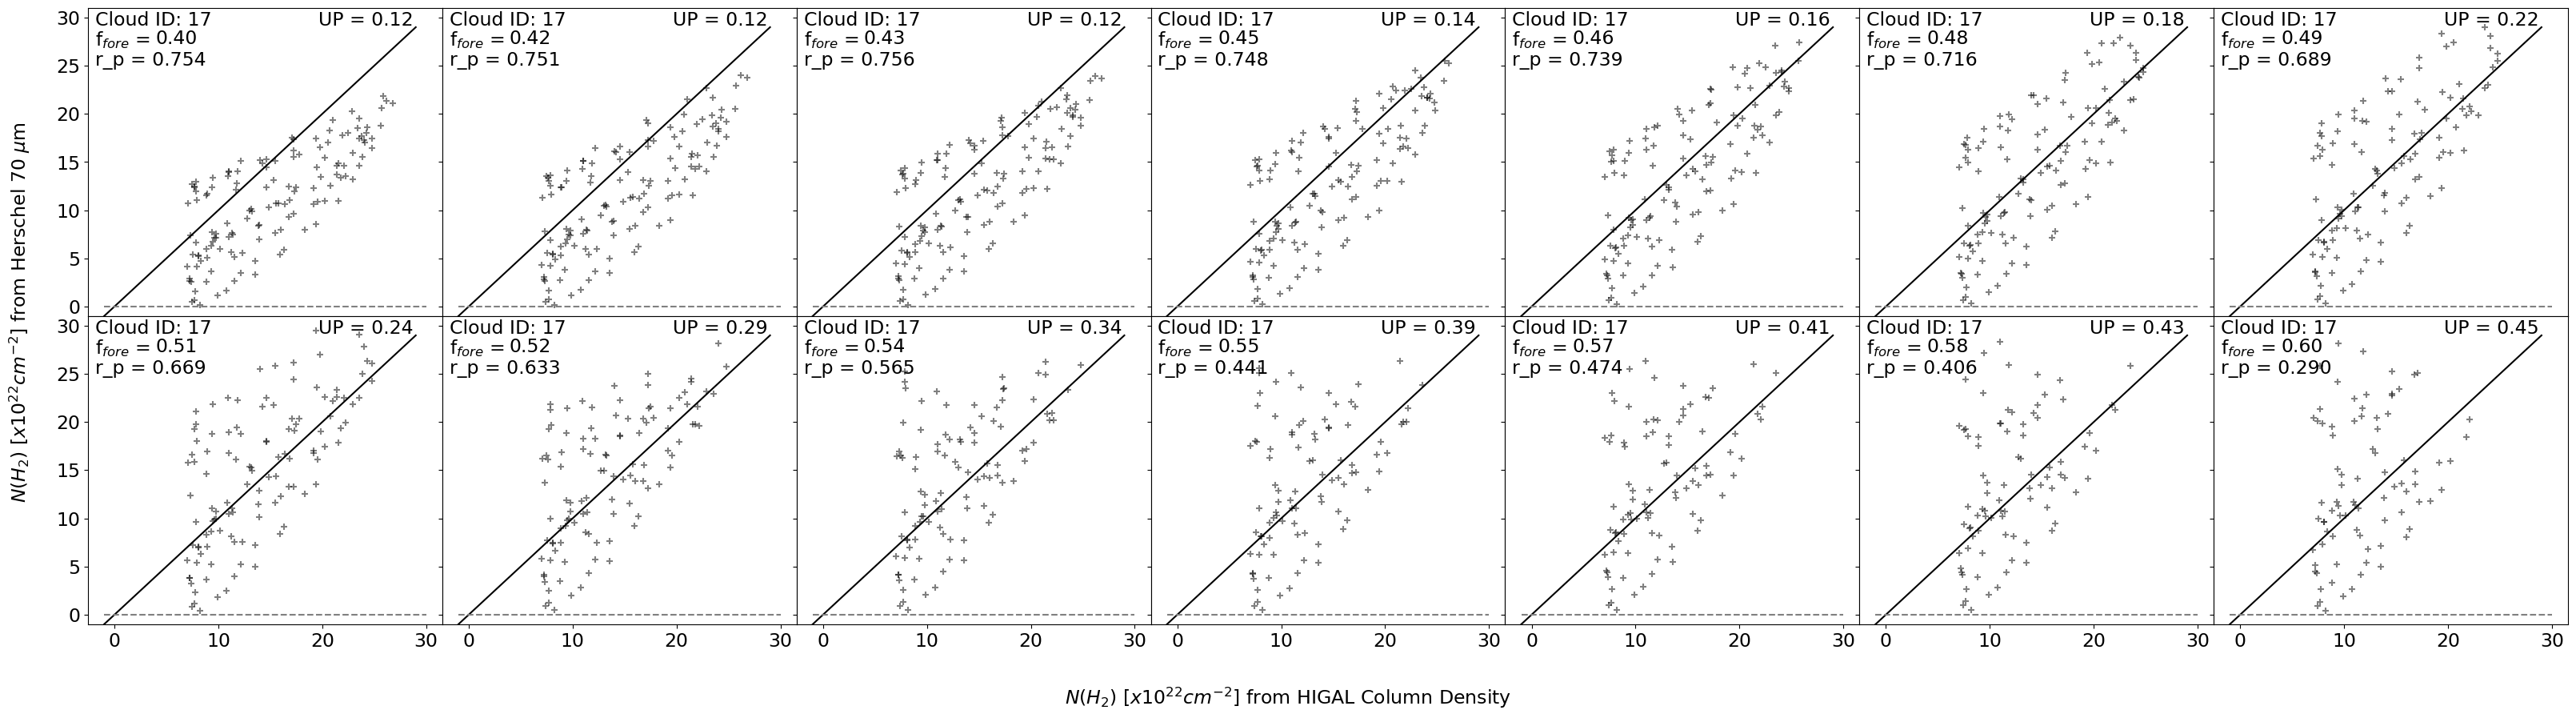

In [21]:
cloud = "G0.255+0.02"

#f_fore_matrix = np.arange(0.2,0.9, 0.05)
f_fore_matrix = np.linspace(0.4,0.6, 14)
f_fore_matrix.resize((2,7))

fig, ax = plt.subplots(2, 7, sharex=True, sharey=True, figsize = (40,10))
plt.subplots_adjust(wspace=0, hspace=0)

for i in range(2):
    for j in range(7):
        ext_list_70_conv = []
        em_list_70_conv = []



        regrid_to_nans_file = './Cloud_masks/{}/{}_ExtN70um_sources_to_nans_ffore{:.2f}_cutout_smoothed_conv36_regrid_isolated.fits'.format(cloud, cloud, f_fore_matrix[i,j])

        regrid_to_nans_data = pyfits.open(regrid_to_nans_file)[0].data

        cloud_hers = './Cloud_masks/{}/{}_herschel_cutout_isolated.fits'.format(cloud,cloud)
        cloud_hers_data = pyfits.open(cloud_hers)[0].data

        wcs = WCS(pyfits.open(regrid_to_nans_file)[0].header)

        em_list_70_conv.append(np.nanmedian(cloud_hers_data)/10**22)
        ext_list_70_conv.append(np.nanmedian(regrid_to_nans_data)/10**22)



        plt.rcParams.update({'font.size': 17})
        

        x = np.arange(-1,30)
        y = np.arange(-1,30)

        #Calculate correlation coefficient
        xy = pd.DataFrame({'Herschel': cloud_hers_data.flatten(), 'Ext Col Den': regrid_to_nans_data.flatten()})
        corr_coeff_p = xy['Herschel'].corr(xy['Ext Col Den'], method='pearson')
        corr_coeff_s = xy['Herschel'].corr(xy['Ext Col Den'], method='spearman')
        
        #find the fraction of pixels that are now nans
        num_ExtN_notnans = len(np.where(np.isnan(regrid_to_nans_data).flatten()==False)[0])
        num_hers_notnans = len(np.where(np.isnan(cloud_hers_data).flatten()==False)[0])
        frac_nans = 1- (num_ExtN_notnans/num_hers_notnans)
        

        #Make plot similar to Fig 3 in Battersby 2010
        x = np.arange(-1,30)
        y = np.arange(-1,30)

        ax[i,j].scatter(cloud_hers_data/10**22,regrid_to_nans_data/10**22, marker='+', color = 'k', alpha=0.5)
        ax[i,j].plot(x,y, c='black')
        ax[i,j].hlines(0,-1, 30, linestyle='--', color='gray')


        #ax[i,j].text(.02, .99, '{}  '.format(cloud), ha='left', va='top', transform=ax[i,j].transAxes)
        ax[i,j].text(.02, .99, 'Cloud ID: {}  '.format(cloud_id), ha='left', va='top', transform=ax[i,j].transAxes)
        ax[i,j].text(.02, .93, r'f$_{fore}$ =', ha='left', va='top', transform=ax[i,j].transAxes)
        ax[i,j].text(.19, .93, '{:.2f}'.format(f_fore_matrix[i,j]), ha='left', va='top', transform=ax[i,j].transAxes)
        ax[i,j].text(.02, .86, 'r_p = {:.3f}'.format(corr_coeff_p), ha='left', va='top', transform=ax[i,j].transAxes)
        #ax[i,j].text(.02, .80, 'r_s = {:.3f}'.format(corr_coeff_s), ha='left', va='top', transform=ax[i,j].transAxes)

        ax[i,j].text(.65, .99, 'UP = {:.2f}'.format(frac_nans), ha='left', va='top', transform=ax[i,j].transAxes)
        ax[i,j].set_ylim(-1,31)

fig.text(0.5, 0.01, r"$N(H_{2})$ [$x10^{22} cm^{-2}$] from HIGAL Column Density", ha='center')
fig.text(0.1, 0.5, r"$N(H_{2})$ [$x10^{22} cm^{-2}$] from Herschel 70 $\mu$m", va='center', rotation='vertical')

#plt.tight_layout(pad=0.0)

plt.savefig("./paper_figs/Figs/{}_70um_ExtN_different_ffore_regridded_to_herschel_subset_2.pdf".format(cloud),bbox_inches='tight')

In [17]:
def plot_six_panel_cloud_8um(cloud):

    example_8um=pyfits.open('./Cloud_masks/{}/{}_spitzer_cutout_isolated.fits'.format(cloud, cloud))[0].data
    wcs_8um = WCS(pyfits.open('./Cloud_masks/{}/{}_spitzer_cutout_isolated.fits'.format(cloud, cloud))[0].header)

    example_8um_RAW=pyfits.open('./Cloud_masks/{}/{}_spitzer_RAW_cutout_isolated.fits'.format(cloud, cloud))[0].data
    wcs_8um_RAW = WCS(pyfits.open('./Cloud_masks/{}/{}_spitzer_RAW_cutout_isolated.fits'.format(cloud, cloud))[0].header)

    example_8um_smoothed=pyfits.open('./Cloud_masks/{}/{}_smoothed_cutout_isolated.fits'.format(cloud, cloud))[0].data
    wcs_8um_smoothed = WCS(pyfits.open('./Cloud_masks/{}/{}_smoothed_cutout_isolated.fits'.format(cloud, cloud))[0].header)

    example_8um_ExtN=pyfits.open('./Cloud_masks/{}/{}_8umExtN_ffore0.50.fits'.format(cloud, cloud))[0].data
    wcs_8um_ExtN = WCS(pyfits.open('./Cloud_masks/{}/{}_8umExtN_ffore0.50.fits'.format(cloud, cloud))[0].header)
    
    example_8um_ExtN_conv_regrid = pyfits.open('./Cloud_masks/{}/{}_ExtN8um_ffore0.50_cutout_smoothed_conv36_regrid_isolated.fits'.format(cloud, cloud))[0].data
    wcs_8um_ExtN_conv_regrid = WCS(pyfits.open('./Cloud_masks/{}/{}_ExtN8um_ffore0.50_cutout_smoothed_conv36_regrid_isolated.fits'.format(cloud, cloud))[0].header)
    
    example_hershel = pyfits.open('./Cloud_masks/{}/{}_herschel_cutout_isolated.fits'.format(cloud, cloud))[0].data
    wcs_herschel = WCS(pyfits.open('./Cloud_masks/{}/{}_herschel_cutout_isolated.fits'.format(cloud, cloud))[0].header)


    fxsz = 25
    xyrat = 2./3.
    fysz = fxsz * xyrat
    ds = 0.05
    fig = plt.figure( figsize=(fxsz,fysz), dpi=300)
    gs = GridSpec(12, 12, figure=fig)
    gs.update(left=ds, right=1-ds, bottom=ds, top=1-ds, hspace=0, wspace=0)

    mpl.rc('image', cmap='gray')

    axes1 = plt.subplot(gs[1:5, 0:3], projection=wcs_8um)
    axes2 = plt.subplot(gs[1:5, 4:7], projection=wcs_8um_RAW)
    axes3 = plt.subplot(gs[1:5, 8:11], projection=wcs_8um_smoothed)

    axes4 = plt.subplot(gs[6:10, 0:3], projection=wcs_8um_ExtN)
    axes5 = plt.subplot(gs[6:10, 4:7], projection=wcs_herschel)
    axes6 = plt.subplot(gs[6:10, 8:11], projection=wcs_herschel)

    #match 8um, 8um RAW colorscales 
    im_8um = axes1.imshow(example_8um) #, vmin=292.255, vmax=954.855)
    vmin_8um, vmax_8um = im_8um.get_clim()
    im_8um_RAW = axes2.imshow(example_8um_RAW, vmin=vmin_8um, vmax=vmax_8um)
    
    im_8um_smoothed = axes3.imshow(example_8um_smoothed)

    
    

    #match 8um Ext and 8um Ext Conv/Regrid colorscales 
    im_8um_ExtN = axes4.imshow(example_8um_ExtN)
    vmin_8Ext, vmax_8Ext = im_8um_ExtN.get_clim()
    im_8um_ExtN_conv_regrid = axes5.imshow(example_8um_ExtN_conv_regrid, vmin=vmin_8Ext, vmax=vmax_8Ext)


    im_hershel = axes6.imshow(example_hershel)

    ax_list = [axes1,axes2,axes3,axes4,axes5,axes6]

    from string import ascii_lowercase as alc

    for j in range(len(ax_list)):
        ax_list[j].set_facecolor('gray')
        ax_list[j].set_xlabel('Galactic Longitude')
        ax_list[j].set_ylabel('Galactic Latitude')
        #ax_list[j].text(0.07, 0.92,'({})'.format(alc[j]), ha='center', va='center', transform=ax_list[j].transAxes)

        
    ax_list[0].text(0.85, 0.92,r'Spitzer 8$\mu m$', ha='center', va='center', transform=ax_list[0].transAxes,
               bbox=dict(facecolor='white', edgecolor='k', alpha=1))  
    ax_list[1].text(0.80, 0.92,r'Spitzer 8$\mu m$ RAW', ha='center', va='center', transform=ax_list[1].transAxes,
               bbox=dict(facecolor='white', edgecolor='k', alpha=1))
    ax_list[2].text(0.75, 0.92,'Spitzer 8$\mu m$ smoothed', ha='center', va='center', transform=ax_list[2].transAxes,
               bbox=dict(facecolor='white', edgecolor='k', alpha=1))
    ax_list[3].text(0.85, 0.92,r'8$\mu m$ ExtN', ha='center', va='center', transform=ax_list[3].transAxes,
               bbox=dict(facecolor='white', edgecolor='k', alpha=1))
    ax_list[4].text(0.83, 0.92,"8$\mu m$ ExtN\nConv+Regrid", ha='center', va='center', transform=ax_list[4].transAxes,
               bbox=dict(facecolor='white', edgecolor='k', alpha=1))
    ax_list[5].text(0.81, 0.92,r'Herschel N(H2)', ha='center', va='center', transform=ax_list[5].transAxes,
               bbox=dict(facecolor='white', edgecolor='k', alpha=1))
    plt.savefig('./paper_figs/Figs/{}_8um_six_panel.png'.format(cloud))


    plt.show()


In [16]:



def plot_six_panel_cloud_8um(cloud):

    example_8um=pyfits.open('./Cloud_masks/{}/{}_spitzer_cutout_isolated.fits'.format(cloud, cloud))[0].data
    wcs_8um = WCS(pyfits.open('./Cloud_masks/{}/{}_spitzer_cutout_isolated.fits'.format(cloud, cloud))[0].header)

    example_8um_RAW=pyfits.open('./Cloud_masks/{}/{}_spitzer_RAW_cutout_isolated.fits'.format(cloud, cloud))[0].data
    wcs_8um_RAW = WCS(pyfits.open('./Cloud_masks/{}/{}_spitzer_RAW_cutout_isolated.fits'.format(cloud, cloud))[0].header)

    example_8um_smoothed=pyfits.open('./Cloud_masks/{}/{}_smoothed_cutout_isolated.fits'.format(cloud, cloud))[0].data
    wcs_8um_smoothed = WCS(pyfits.open('./Cloud_masks/{}/{}_smoothed_cutout_isolated.fits'.format(cloud, cloud))[0].header)

    example_8um_ExtN=pyfits.open('./Cloud_masks/{}/{}_8umExtN_ffore0.50.fits'.format(cloud, cloud))[0].data
    wcs_8um_ExtN = WCS(pyfits.open('./Cloud_masks/{}/{}_8umExtN_ffore0.50.fits'.format(cloud, cloud))[0].header)
    
    example_8um_ExtN_conv_regrid = pyfits.open('./Cloud_masks/{}/{}_ExtN8um_ffore0.50_cutout_smoothed_conv36_regrid_isolated.fits'.format(cloud, cloud))[0].data
    wcs_8um_ExtN_conv_regrid = WCS(pyfits.open('./Cloud_masks/{}/{}_ExtN8um_ffore0.50_cutout_smoothed_conv36_regrid_isolated.fits'.format(cloud, cloud))[0].header)
    
    example_hershel = pyfits.open('./Cloud_masks/{}/{}_herschel_cutout_isolated.fits'.format(cloud, cloud))[0].data
    wcs_herschel = WCS(pyfits.open('./Cloud_masks/{}/{}_herschel_cutout_isolated.fits'.format(cloud, cloud))[0].header)
    
    
    
    

    plt.rcParams.update({'font.size': 10})
    plt.rcParams['axes.facecolor']='grey'
    fig, ax = plt.subplots(2, 3, subplot_kw={'projection': wcs_8um}, figsize = (10,8), dpi = 300)
    ax[1,1].remove()
    ax[1,2].remove()
    ax_5 = fig.add_subplot(2,3,5, projection=wcs_herschel)
    ax_6 = fig.add_subplot(2,3,6, projection=wcs_herschel, sharex=ax_5, sharey=ax_5)
    
    #plt.subplots_adjust(wspace=0, hspace=0)

    
    
    mpl.rc('image', cmap='Blues_r')


    #match 8um and 8um masked colorscales 
    im_8um = ax[0,0].imshow(example_8um, cmap='hot')
    vmin_8um, vmax_8um = im_8um.get_clim()
    
    im_8um_RAW = ax[0,1].imshow(example_8um_RAW, vmin=vmin_8um, vmax=vmax_8um, cmap='hot')
    
    
    im_8um_smoothed = ax[0,2].imshow(example_8um_smoothed, vmin=vmin_8um, vmax=vmax_8um, cmap='Oranges')
    
    

    #match 8um Ext and 8um Ext Conv/Regrid colorscales 
    im_herschel = ax_6.imshow(example_hershel)
    vmin_hers, vmax_hers = im_herschel.get_clim()
        
        
    im_8um_ExtN = ax[1,0].imshow(example_8um_ExtN, vmin=vmin_hers, vmax=vmax_hers)
    vmin_8Ext, vmax_8Ext = im_8um_ExtN.get_clim()
    
    
    
    
    im_8um_ExtN_conv_regrid = ax_5.imshow(example_8um_ExtN_conv_regrid, vmin=vmin_hers, vmax=vmax_hers)


    
    
    
    
    
    ###BEAUTIFY PLOTS####    

    for i in range(2):
        for j in range(3):
            lon = ax[i,j].coords['glon']
            lat = ax[i,j].coords['glat']
            lon.set_ticks_visible(False)
            lon.set_ticklabel_visible(False)
            lat.set_ticks_visible(False)
            lat.set_ticklabel_visible(False)
            lon.set_axislabel('')
            lat.set_axislabel('')
            ax[i,j].set_facecolor('grey')
            
            
            
    #ax[0,0] and ax[1,0] can keep labels and ticks, the rest dont need them

    lon = ax[0,0].coords['glon']
    lat = ax[0,0].coords['glat']
    lon.set_major_formatter('d.dd')
    lat.set_major_formatter('d.dd')
    lon.set_ticks_visible(True)
    lon.set_ticklabel_visible(True)
    lat.set_ticks_visible(True)
    lat.set_ticklabel_visible(True)
    lon.set_ticks_position('b')
    lon.set_ticklabel_position('b')
    lon.set_axislabel_position('b')
    lat.set_ticks_position('l')
    lat.set_ticklabel_position('l')
    lat.set_axislabel_position('l')
    
    ax[0,0].set_facecolor('gray')
    ax[0,0].set_xlabel('Galactic Longitude')
    ax[0,0].set_ylabel('Galactic Latitude')
    ax[0,0].set_facecolor('grey')


    lon = ax[1,0].coords['glon']
    lat = ax[1,0].coords['glat']
    lon.set_major_formatter('d.dd')
    lat.set_major_formatter('d.dd')
    lon.set_ticks_visible(True)
    lon.set_ticklabel_visible(True)
    lat.set_ticks_visible(True)
    lat.set_ticklabel_visible(True)
    lon.set_ticks_position('b')
    lon.set_ticklabel_position('b')
    lon.set_axislabel_position('b')
    lat.set_ticks_position('l')
    lat.set_ticklabel_position('l')
    lat.set_axislabel_position('l')
    
    ax[1,0].set_facecolor('gray')
    ax[1,0].set_xlabel('Galactic Longitude')
    ax[1,0].set_ylabel('Galactic Latitude')
    ax[1,0].set_facecolor('grey')

    
    
    
    
    
    
    
    lon = ax_5.coords['glon']
    lat = ax_5.coords['glat']
    lon.set_ticks_visible(False)
    lon.set_ticklabel_visible(False)
    lat.set_ticks_visible(False)
    lat.set_ticklabel_visible(False)
    lon.set_axislabel('')
    lat.set_axislabel('')
    ax_5.set_facecolor('grey')

    lon = ax_6.coords['glon']
    lat = ax_6.coords['glat']
    lon.set_ticks_visible(False)
    lon.set_ticklabel_visible(False)
    lat.set_ticks_visible(False)
    lat.set_ticklabel_visible(False)
    lon.set_axislabel('')
    lat.set_axislabel('')
    
    plt.tight_layout(w_pad = 0.5, h_pad=6)
    
    
    
    
    
    cb1 = fig.colorbar(im_8um, ax=ax[0,0], location='top',pad=0.0)
    cb2 = fig.colorbar(im_8um_RAW, ax=ax[0,1], location='top',pad=0.0)
    cb3 = fig.colorbar(im_8um_smoothed, ax=ax[0,2], location='top',pad=0.0)
    cb4 = fig.colorbar(im_8um_ExtN, ax=ax[1,0], location='top',pad=0.0)
    cb5 = fig.colorbar(im_8um_ExtN_conv_regrid, ax=ax_5, location='top',pad=0.0)
    cb6 = fig.colorbar(im_herschel, ax=ax_6, location='top',pad=0.0)

    
    cb1.set_label(label = r'[MJy/sr]', labelpad=-14, x=0.94, rotation=0, fontsize = 7)
    cb2.set_label(label = r'[MJy/sr]', labelpad=-14, x=0.94, rotation=0, fontsize = 7)
    cb3.set_label(label = r'[MJy/sr]', labelpad=-14, x=0.94, rotation=0, fontsize = 7)
    
    cb4.set_label(label = r'[cm$^{-2}$]', labelpad=-14, x=0.94, rotation=0, fontsize = 7)
    cb5.set_label(label = r'[cm$^{-2}$]', labelpad=-14, x=0.94, rotation=0, fontsize = 7)
    cb6.set_label(label = r'[cm$^{-2}$]', labelpad=-14, x=1.02, rotation=0, fontsize = 7)

    
    from string import ascii_lowercase as alc

    for m in range(len(fig.axes[6:])):
        fig.axes[m].text(0.07, 0.92,'({})'.format(alc[m]), ha='center', va='center', transform=fig.axes[m].transAxes)
    
    
       
    ax[0,0].text(0.85, 0.92,'Spitzer 8$\mu m$ \nResidual', ha='center', va='center', transform=ax[0,0].transAxes,
               bbox=dict(facecolor='white', edgecolor='k', alpha=1), fontsize = 8)  
     
    ax[0,1].text(0.8, 0.95,'Spitzer 8$\mu m$ Raw', ha='center', va='center', transform=ax[0,1].transAxes,
               bbox=dict(facecolor='white', edgecolor='k', alpha=1), fontsize = 8)
    ax[0,2].text(0.85, 0.92,'Spitzer 8$\mu m$\nSmoothed', ha='center', va='center', transform=ax[0,2].transAxes,
               bbox=dict(facecolor='white', edgecolor='k', alpha=1), fontsize = 8)
    ax[1,0].text(0.875, 0.95,r'8$\mu m$ ExtN', ha='center', va='center', transform=ax[1,0].transAxes,
               bbox=dict(facecolor='white', edgecolor='k', alpha=1), fontsize = 8)
    ax_5.text(0.76, 0.92,"8$\mu m$ ExtN\nConvolved+Rescaled", ha='center', va='center', transform=ax_5.transAxes,
               bbox=dict(facecolor='white', edgecolor='k', alpha=1), fontsize = 8)
    ax_6.text(0.82, 0.95,r'Herschel N(H2)', ha='center', va='center', transform=ax_6.transAxes,
               bbox=dict(facecolor='white', edgecolor='k', alpha=1), fontsize = 8)

    
    

    
    
    plt.savefig('./paper_figs/Figs/{}_8um_six_panel.png'.format(cloud),bbox_inches='tight')


    plt.show()


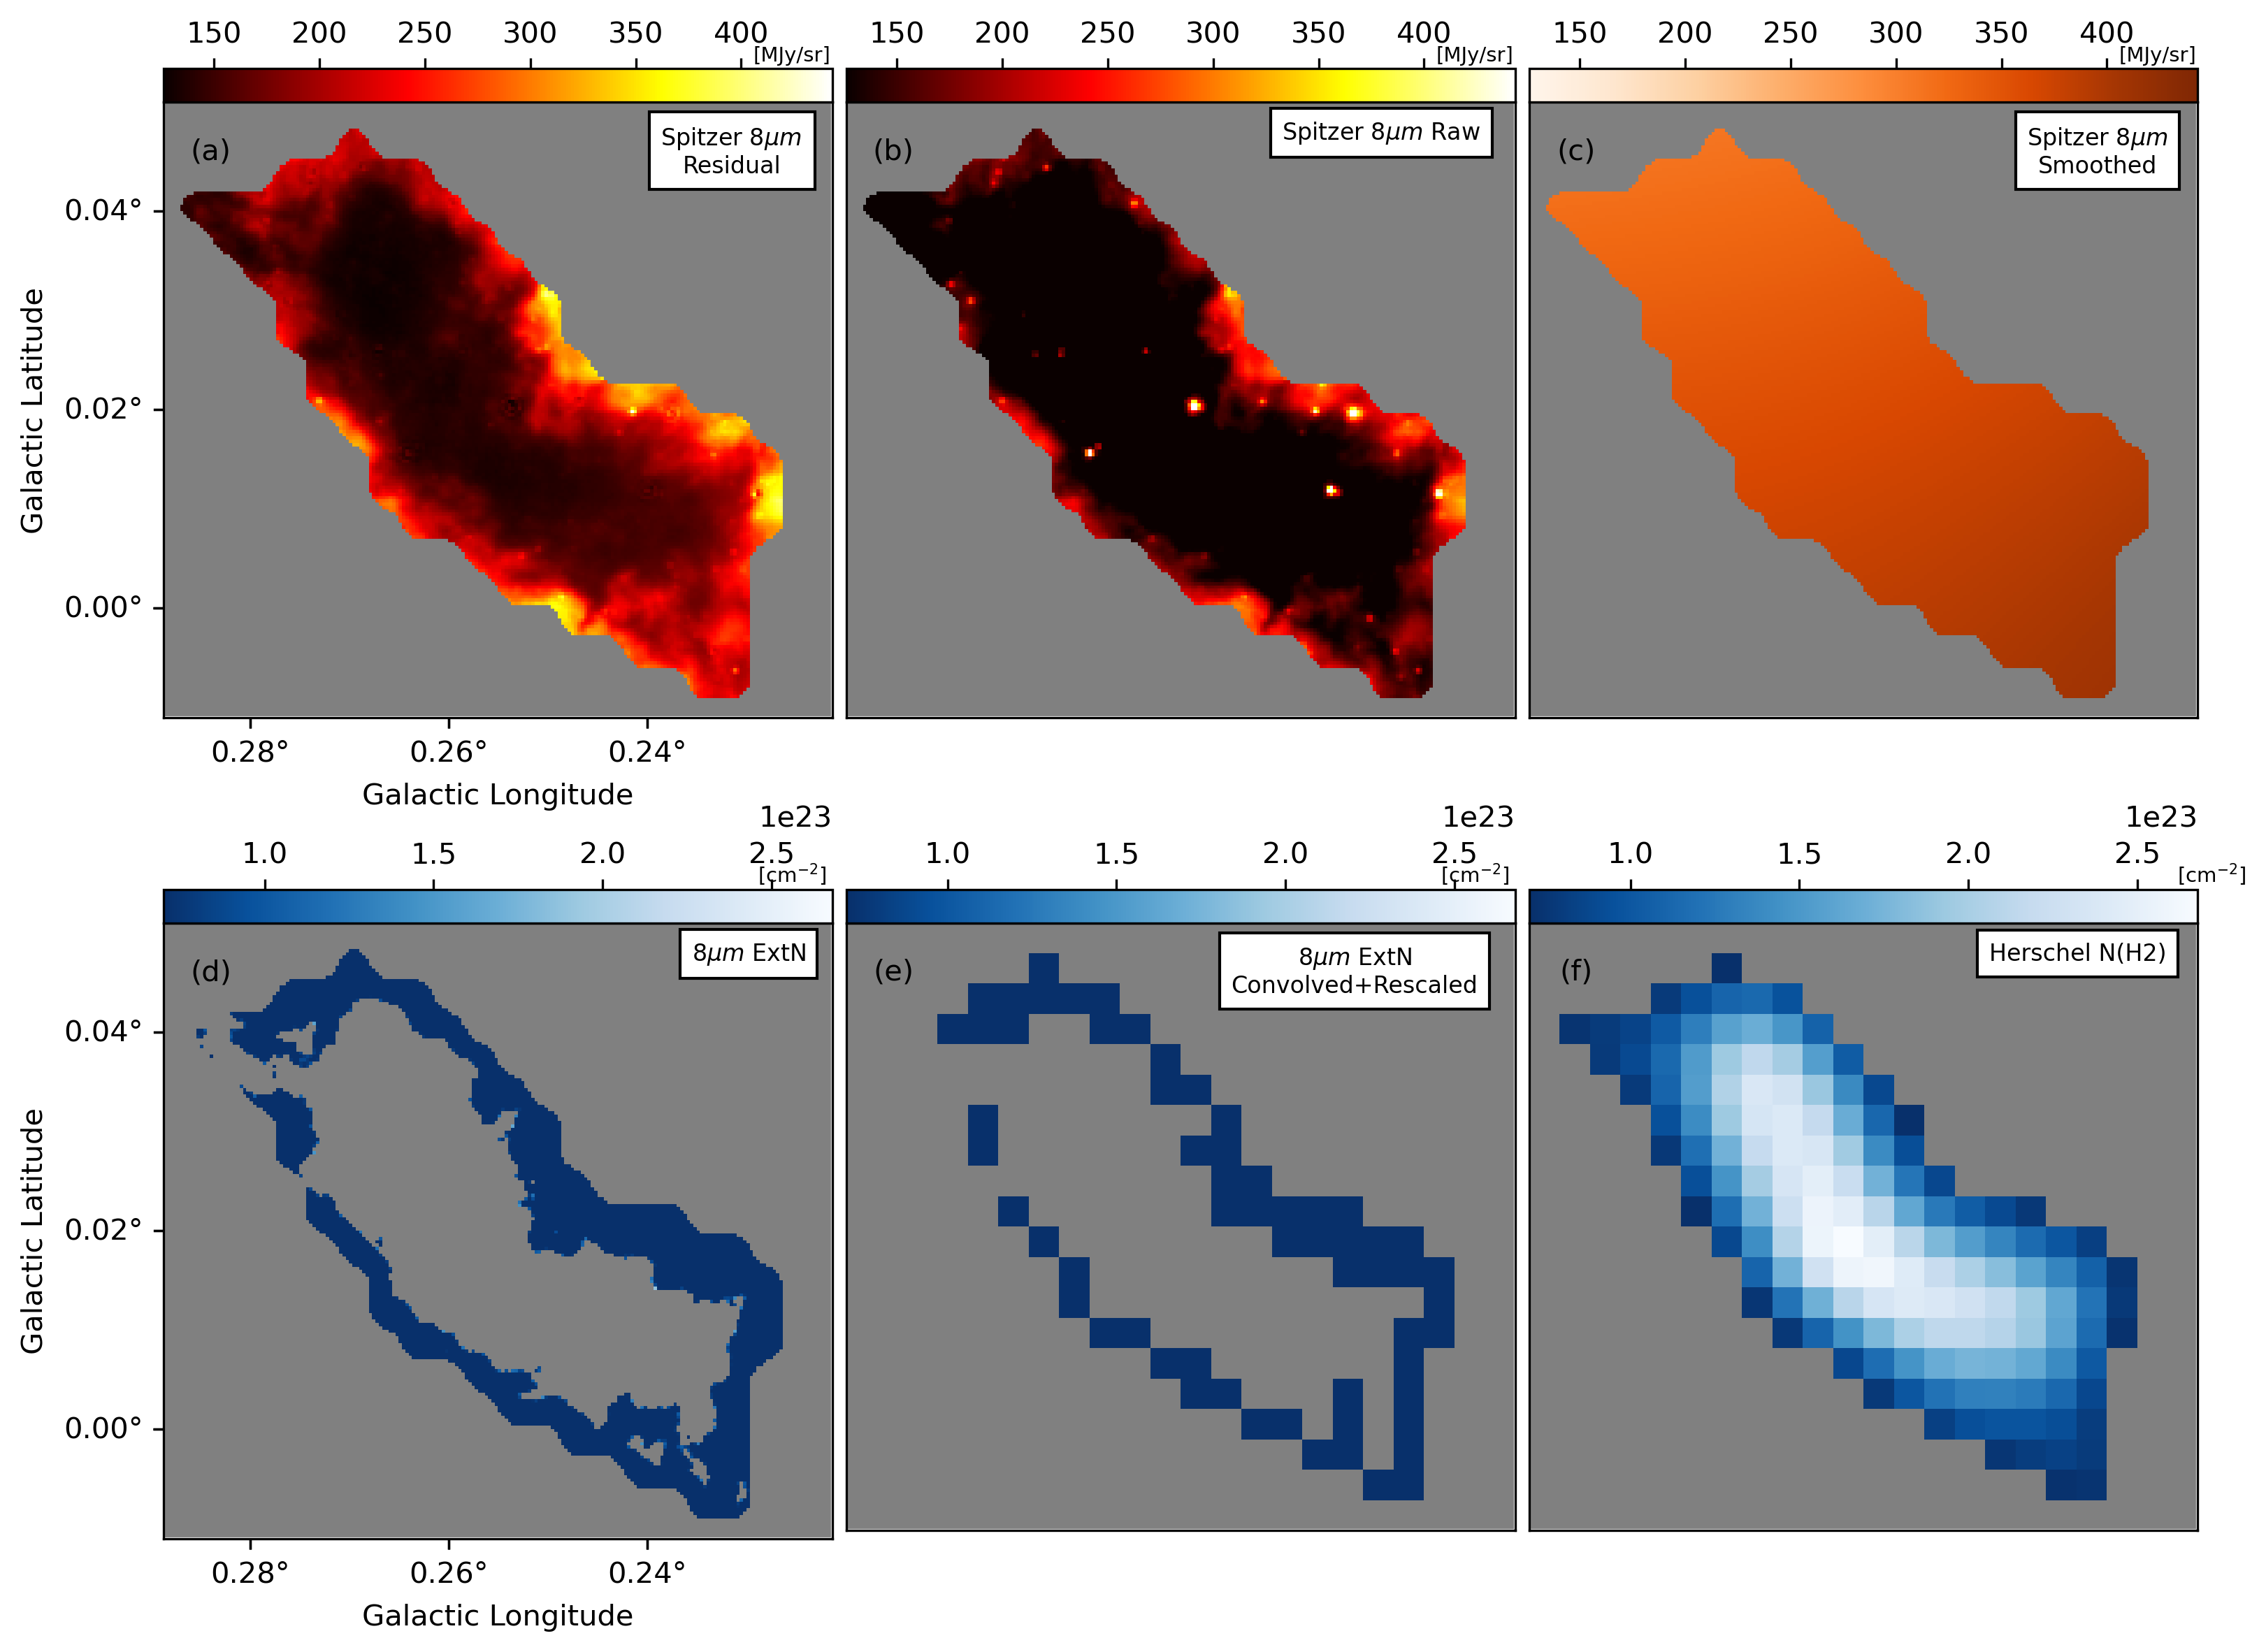

In [17]:
plot_six_panel_cloud_8um("G0.255+0.02")


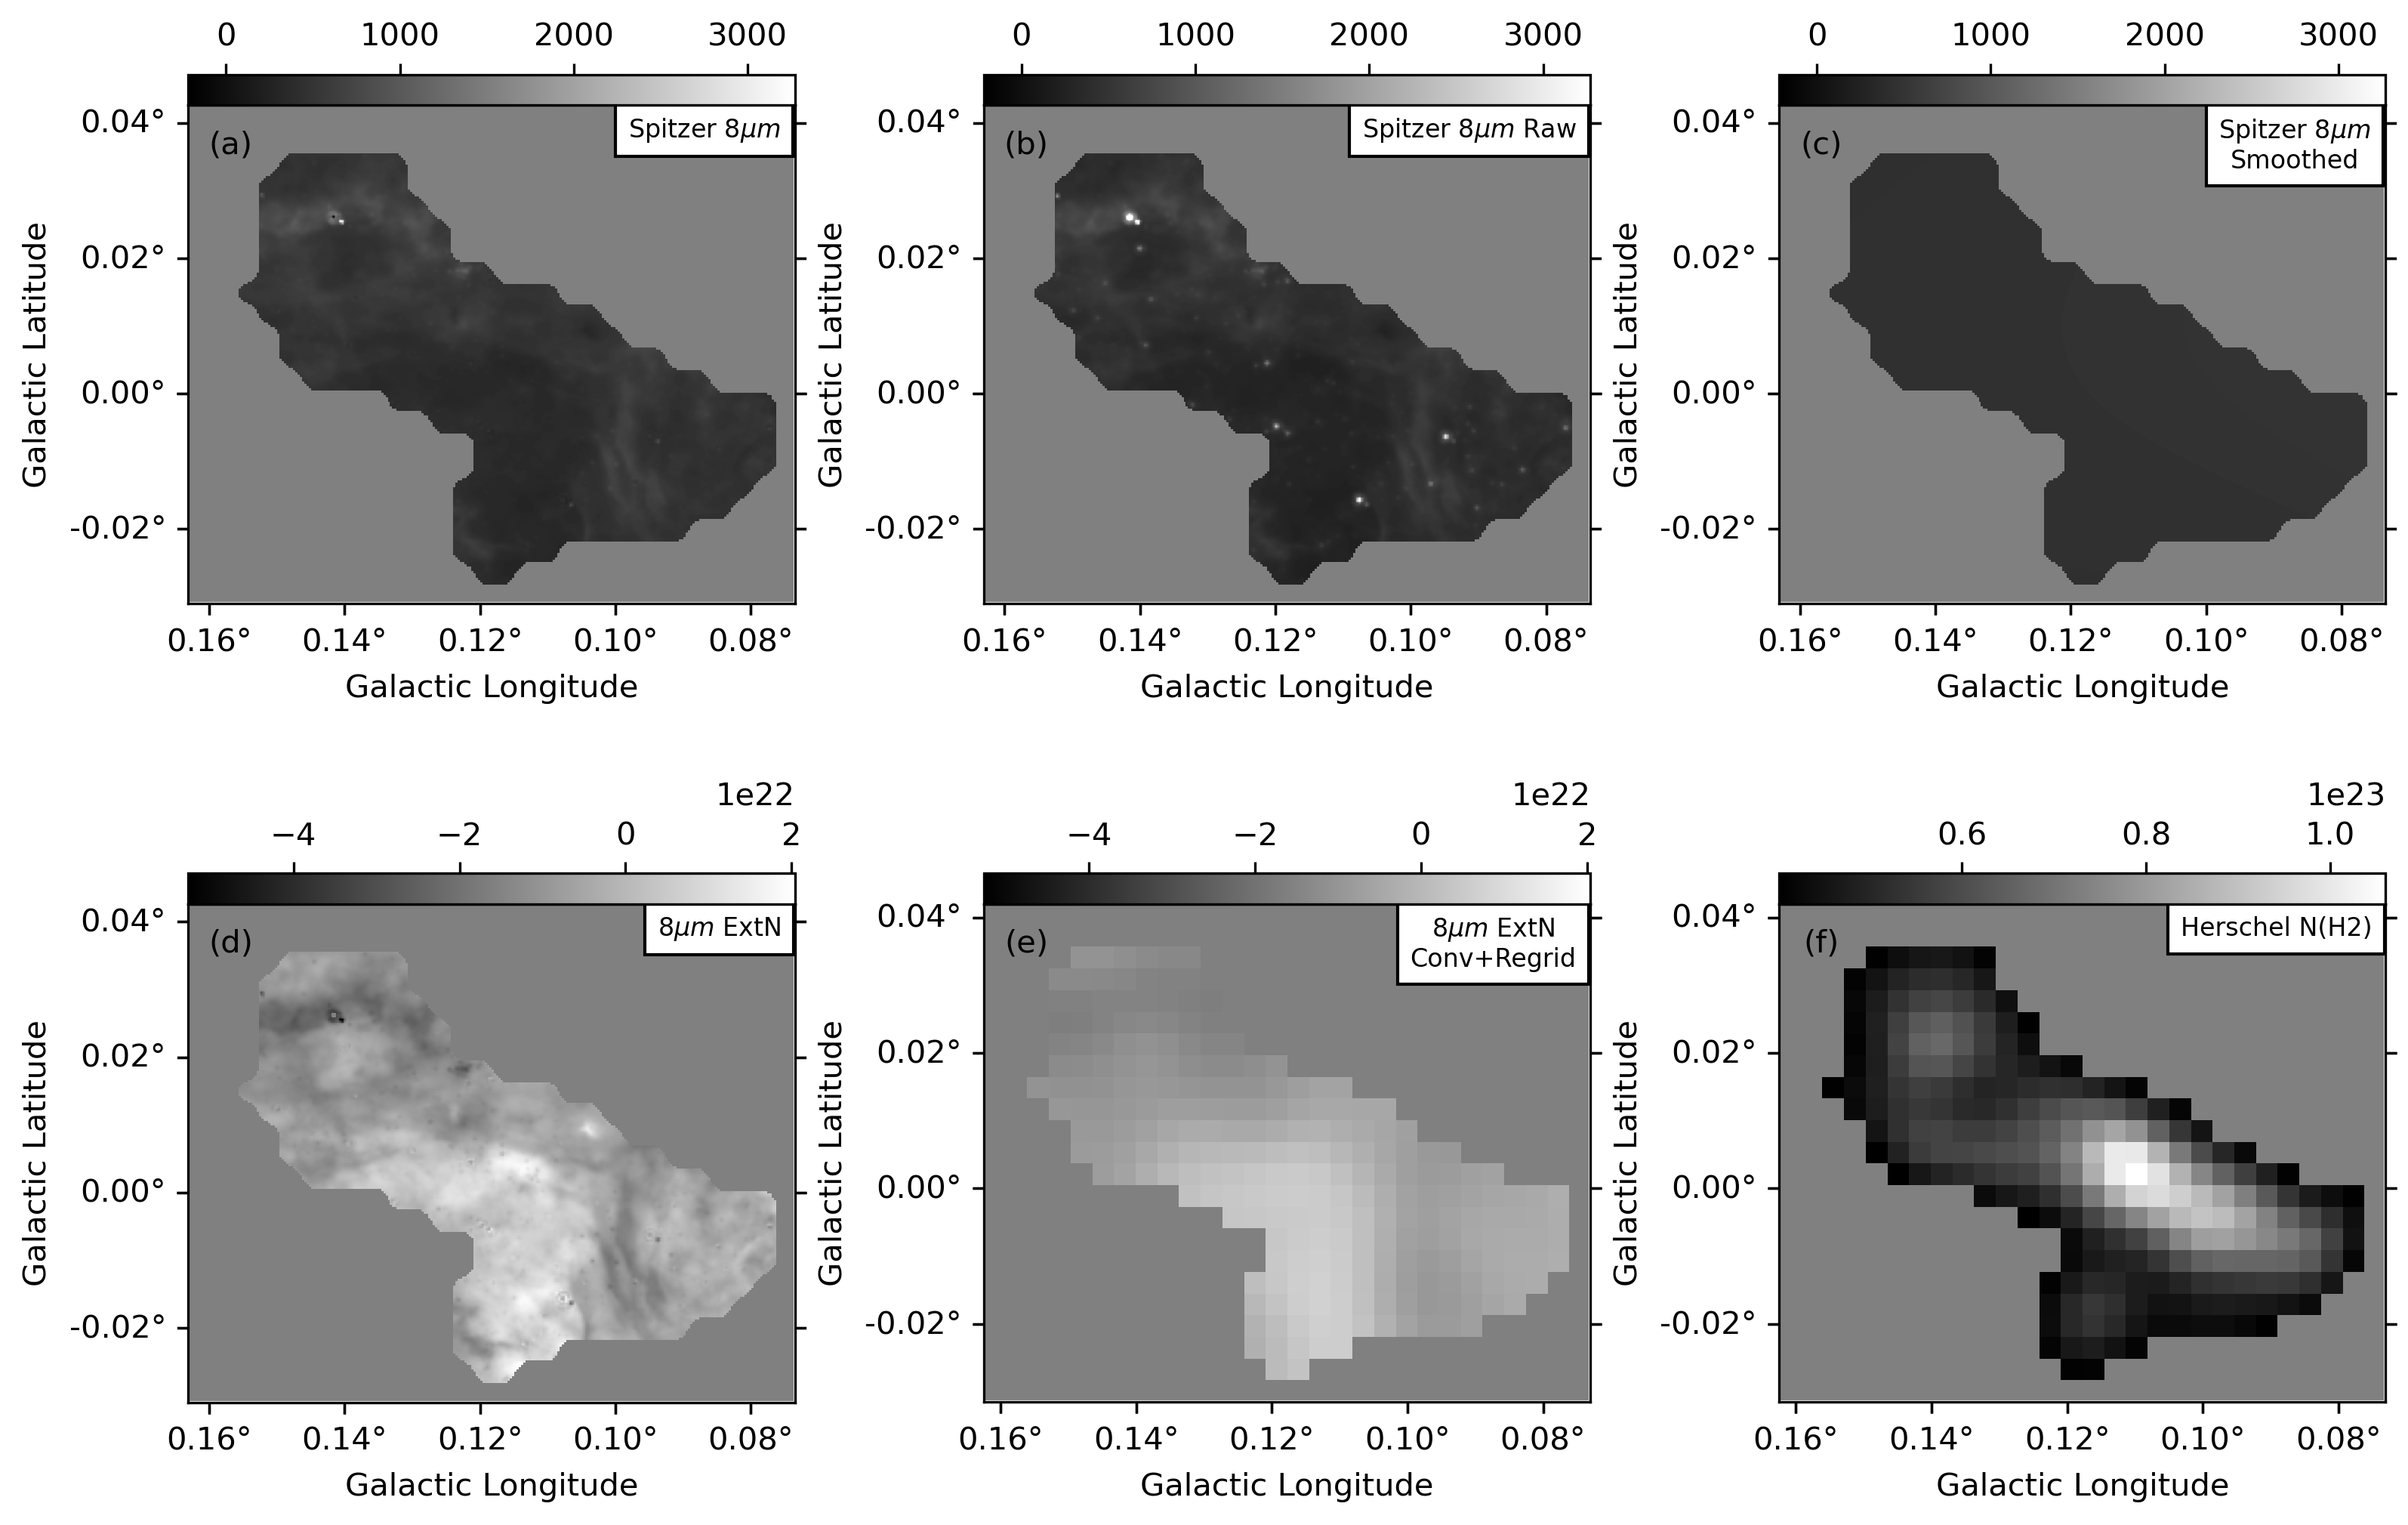

In [96]:
plot_six_panel_cloud_8um("G0.116+0.003")


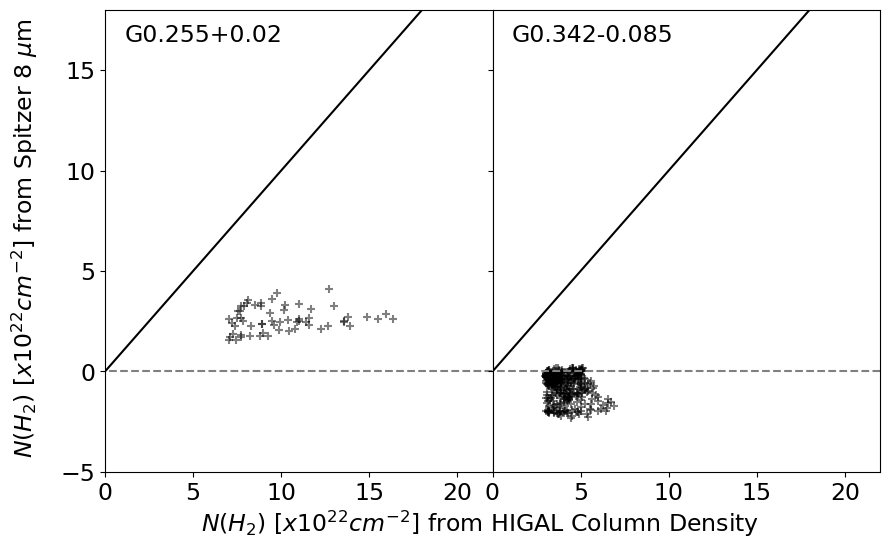

In [66]:
###Comparison plot of Brick and Sailfish###


plot_cloud_list = ["G0.255+0.02", "G0.342-0.085"]


f_fore=0.50

fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize = (10,6))

plt.subplots_adjust(wspace=0, hspace=0)
plt.xlim(0,22)
plt.ylim(-5,18)

for i in range(2):

        regrid_to_nans_file = './Cloud_masks/{}/{}_ExtN8um_ffore{:.2f}_cutout_smoothed_conv36_regrid_isolated.fits'.format(plot_cloud_list[i], plot_cloud_list[i], f_fore)

        regrid_to_nans_data = pyfits.open(regrid_to_nans_file)[0].data

        cloud_hers = './Cloud_masks/{}/{}_herschel_cutout_isolated.fits'.format(plot_cloud_list[i],plot_cloud_list[i])
        cloud_hers_data = pyfits.open(cloud_hers)[0].data

        wcs = WCS(pyfits.open(regrid_to_nans_file)[0].header)



        plt.rcParams.update({'font.size': 17})
        

        x = np.arange(-1,30)
        y = np.arange(-1,30)


        ax[i].scatter(cloud_hers_data/1E22,regrid_to_nans_data/1E22, 
                marker='+', color = 'k', alpha=0.5, label = "f_fore={}".format(f_fore))





        ax[i].plot(x,y, c='black')
        ax[i].hlines(0,-1, 30, linestyle='--', color='gray')


        ax[i].text(.05, .97, '{}'.format(plot_cloud_list[i]), ha='left', va='top', transform=ax[i].transAxes)


fig.text(0.5, 0.01, r"$N(H_{2})$ [$x10^{22} cm^{-2}$] from HIGAL Column Density", ha='center')
fig.text(0.03, 0.5, r"$N(H_{2})$ [$x10^{22} cm^{-2}$] from Spitzer 8 $\mu$m", va='center', rotation='vertical')


plt.savefig('./paper_figs/Figs/8um_brick_sailfish_comparison.pdf')